In [1]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

# cloning repo
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git

# moving into project dir
%cd bsc-thesis/src
%ls

/content
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 828, done.
remote: Counting objects: 100% (208/208), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 828 (delta 114), reused 108 (delta 43), pack-reused 620 (from 1)
Receiving objects: 100% (828/828), 26.87 MiB | 18.87 MiB/s, done.
Resolving deltas: 100% (468/468), done.
Filtering content: 100% (32/32), 1.75 GiB | 56.11 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [2]:
!pip install numpy==1.26.3 # necessary for bug fix
!pip install peft==0.10.0
!pip install ta
!pip install pykalman
!pip install PyWavelets
!pip install curl-cffi

## specific packages for time moe
# need a different version of accelerate because of bug "ImportError: cannot import name 'clear_device_cache' from 'accelerate.utils.memory'"
!pip install -U accelerate==0.32.0 # standard google colab version is 1.6.0 (apr 1, 2025), but for stability, we use time moe's 0.28.0 (mar 12, 2024)
!pip install transformers==4.40.1 # standard google colab version is 4.51.3, but time moe repo requirements mention/prefer 4.40.1 for stability
!pip install datasets==2.18.0
FLASH_ATTN = False # set to true if using this
if FLASH_ATTN:
  !pip install flash-attn==2.6.3 # optional but recommended by the repo

In [3]:
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm # note: using tqdm.auto usually automatically chooses the right import based on whether you're in CLI, notebook or somewhere else
import torch.nn as nn
import itertools
from pykalman import KalmanFilter
import ast
import re
from tabulate import tabulate
from datetime import datetime

# Custom Imports
from models.statistical_models import create_dataset, default_normalize, rmse_metric, acc_metric, kalman_filter_average, kalman_filter_regression, kalman_filter_regression_multivariate
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from preprocessing.wavelet_denoising import wav_den
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade, get_gt_yoy_returns_test_dev
from backtesting.utils import calculate_return_uncertainty
from utils.visualization import plot_return_uncertainty, plot_comparison
from utils.helpers import _get_train_dev_frac

import wandb
wandb.login()

## workflow imports
from models.statistical_models import execute_kalman_workflow
from models.transformer_model import execute_transformer_workflow
from models.time_moe_model import execute_timemoe_workflow

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, _get_filename, gather_pairs_data_cached, gather_data_cached_using_truncate

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

inspect_func = False
if inspect_func:
  import inspect
  print(inspect.getsource(execute_kalman_workflow)) # in this case, check whether tqdm was actually added

wandb: Currently logged in as: davidmoerdijk (davidmoerdijk-smart-backoffice) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
# Goal: plot test MSE vs profitability

### DATA GATHER ###
start_year = 2008
end_year = 2024
startDateStr = f'{start_year}-01-01'
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01'
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if not pairs_data_filtered:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.


### DATA GATHER ###

### EXTRA VARS ###

verbose = False

### EXTRA VARS ###

In [21]:
### Definition of trade functions ###

def trade(
        S1: pd.Series,
        S2: pd.Series,
        spread: pd.Series, # model-predicted spread for the strategy
        window_long: int,
        window_short: int,
        position_threshold: float = 1.0,
        clearing_threshold: float = 0.5,
        risk_fraction: float = 0.1 # could be used again
    ):
    if len(spread) != len(S1) or len(spread) != len(S2):
        raise ValueError("Length of S1, S2, and spread must be the same")
    # Compute rolling mean and rolling standard deviation

    ma_long = spread.rolling(window=window_long, center=False).mean()
    ma_short = spread.rolling(window=window_short, center=False).mean()
    std = spread.rolling(window=window_short, center=False).std()
    zscore = (ma_long - ma_short)/std

    # Calculate initial cash based on average range of S1, S2 and Spread_Close, as these also determine the size of the trades
    s2_spread = max(S2) - min(S2)
    s1_spread = max(S1) - min(S1)
    spread_spread = max(spread) - min(spread)
    avg_spread = (s2_spread + s1_spread + spread_spread) / 3
    initial_cash = avg_spread * len(spread) # the absolute returns are correlated to the length of the spread, times the average range.
    # overwrite initial_cash to standard value
    initial_cash = 10000

    # Simulate trading
    # Start with no money and no positions
    cash = initial_cash # initial cash amount, perhaps not hardcoded in the future
    qty_s1 = 0
    qty_s2 = 0
    returns = [initial_cash]

    for i in range(len(spread)):
        # Sell short if the z-score is > 1
        if zscore.iloc[i] > position_threshold:
            # print(f"[NEW] Step {i}: SELL SHORT, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, cash={cash:.2f}, qty_s1={qty_s1}, qty_s2={qty_s2}")
            cash += S1.iloc[i] - S2.iloc[i] * spread.iloc[i]
            qty_s1 -= 1
            qty_s2 += spread.iloc[i]
        # Buy long if the z-score is < 1
        elif zscore.iloc[i] < -position_threshold:
            # print(f"[NEW] Step {i}: BUY LONG, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, cash={cash:.2f}, qty_s1={qty_s1}, qty_s2={qty_s2}")
            cash -= S1.iloc[i] - S2.iloc[i] * spread.iloc[i]
            qty_s1 += 1
            qty_s2 -= spread.iloc[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore.iloc[i]) < clearing_threshold:
            # print(f"[NEW] Step {i}: CLEAR POSITION, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, cash={cash:.2f}, qty_s1={qty_s1}, qty_s2={qty_s2}")
            cash += qty_s1 * S1.iloc[i] - S2.iloc[i] * qty_s2
            qty_s1 = 0
            qty_s2 = 0
        returns.append(cash) # append the current cash value to returns
    # If at any point returns is 0, all values after that is zero
    zero_from_this_idx = -1
    for i in range(len(returns)):
        if returns[i] <= 0:
            zero_from_this_idx = i
            break
    if zero_from_this_idx > -1:
        returns[zero_from_this_idx:] = [0] * (len(returns) - zero_from_this_idx)

    # Shrink returns by a factor such that returns are not inflated.
    returns_series = pd.Series(returns)
    alpha = 0.1  # Shrinking/stretching factor
    returns_uninflated = returns_series[0] + alpha * (returns_series - returns_series[0])
    # turn back into list
    returns_uninflated = returns_uninflated.tolist()
    return returns_uninflated

def trade_original(S1, S2, spread, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ma1 = spread.rolling(window=window1, center=False).mean()
    ma2 = spread.rolling(window=window2, center=False).mean()
    std = spread.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(spread)):
        # Sell short if the z-score is > 1
        if zscore.iloc[i] > 1:
            # print(f"[OLD] Step {i}: SELL SHORT, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, money={money:.2f}, countS1={countS1}, countS2={countS2}")
            money += S1.iloc[i] - S2.iloc[i] * spread.iloc[i]
            countS1 -= 1
            countS2 += spread.iloc[i]
        # Buy long if the z-score is < 1
        elif zscore.iloc[i] < -1:
            # print(f"[OLD] Step {i}: BUY LONG, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, money={money:.2f}, countS1={countS1}, countS2={countS2}")
            money -= S1.iloc[i] - S2.iloc[i] * spread.iloc[i]
            countS1 += 1
            countS2 -= spread.iloc[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore.iloc[i]) < 0.5:
            # print(f"[OLD] Step {i}: CLEAR POSITION, z={zscore.iloc[i]:.2f}, S1={S1.iloc[i]:.2f}, S2={S2.iloc[i]:.2f}, spread={spread.iloc[i]:.2f}, money={money:.2f}, countS1={countS1}, countS2={countS2}")
            money += countS1 * S1.iloc[i] - S2.iloc[i] * countS2
            countS1 = 0
            countS2 = 0
    return money


### Definition of trade functions ###

In [25]:
### Gathering of results ###
execute_nn_workflows = True
execute_kalman_workflows = True
seed = 3178749
torch.manual_seed(seed)
np.random.seed(seed)

# Extract the most highly cointegrated pairs
for i in tqdm(range(len(pairs_data_filtered[:40]))):
  ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
  pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)

  burn_in = 30

  pairs_timeseries_df_burned_in = pairs_timeseries_df.iloc[burn_in:].copy()

  total_len = len(pairs_timeseries_df_burned_in)
  train_size = int(total_len * train_frac)
  dev_size   = int(total_len * dev_frac)
  test_size  = total_len - train_size - dev_size # not used, but for clarity

  train = pairs_timeseries_df_burned_in.iloc[:train_size]
  dev   = pairs_timeseries_df_burned_in.iloc[train_size:train_size + dev_size]
  test  = pairs_timeseries_df_burned_in.iloc[train_size + dev_size:]

  ## Getting timeseries ##
  # 0. timeseries needed for all
  short_look_back = 1 # look_back is 1 in the case of kalman filter
  long_look_back = 20

  S1_short = test['S1_close'].iloc[short_look_back:] # kalman way
  S2_short = test['S1_close'].iloc[short_look_back:]
  spread_gt_short = test['Spread_Close'].iloc[short_look_back:]

  S1_long = test['S1_close'].iloc[long_look_back:] # kalman way
  S2_long = test['S1_close'].iloc[long_look_back:]
  spread_gt_long = test['Spread_Close'].iloc[long_look_back:]

  # 1. artificial noise
  std_devs = np.random.uniform(0.1, 1.0, 4)
  spreads_with_noise = []
  test_nmse_artificial_noise = []
  test_mse_artificial_noise = []

  for std_dev in std_devs:
      noise = np.random.normal(0, std_dev, size=len(spread_gt_long))
      spread_gt_artificial_noise = spread_gt_long + noise
      mse = np.mean((spread_gt_artificial_noise - spread_gt_long) ** 2)
      var = np.var(spread_gt_long)
      nmse = mse / var

      spreads_with_noise.append(spread_gt_artificial_noise)
      test_nmse_artificial_noise.append(nmse)

  if execute_kalman_workflows:
    # 2. kalman predictions
    predicted_spread_kalman_without_ta, test_mse_kalman_without_ta = execute_kalman_workflow(pairs_timeseries_df, verbose=verbose, add_technical_indicators=False, train_frac=train_frac, dev_frac=dev_frac, return_predicted_spread=True)
    predicted_spread_kalman_with_ta, test_mse_kalman_with_ta = execute_kalman_workflow(pairs_timeseries_df, verbose=verbose, add_technical_indicators=True, train_frac=train_frac, dev_frac=dev_frac, return_predicted_spread=True)
  if execute_nn_workflows:
    # 3. Transformer predictions
    predicted_spread_transformer_without_ta, test_mse_transformer_without_ta = execute_transformer_workflow(pairs_timeseries_df, verbose=verbose, add_technical_indicators=False, epochs=200, train_frac=train_frac, dev_frac=dev_frac, return_predicted_spread=True)
    predicted_spread_transformer_with_ta, test_mse_transformer_with_ta = execute_transformer_workflow(pairs_timeseries_df, verbose=verbose, add_technical_indicators=True, epochs=200, train_frac=train_frac, dev_frac=dev_frac, return_predicted_spread=True)

    # 4. Time-MoE predictions
    predicted_spread_timemoe, test_mse_timemoe = execute_timemoe_workflow(pairs_timeseries_df, verbose=verbose, load_finetuned=True, train_frac=train_frac, dev_frac=dev_frac, return_predicted_spread=True)

  ## Getting timeseries ##

  ## Getting trade func results ##

  returns_gt = trade(S1_long, S2_long, spread_gt_long, 30, 5)
  gt_yoy = ((returns_gt[-1] / returns_gt[0])**(365 / len(returns_gt)) - 1)
  profit_original_gt = trade_original(S1_long, S2_long, spread_gt_long, 30, 5)

  returns_with_noise = []
  yoy_with_noise = []
  profit_original_with_noise = []

  for spread_noise in spreads_with_noise:
      returns = trade(S1_long, S2_long, spread_noise, 30, 5)
      yoy = ((returns[-1] / returns[0])**(365 / len(returns)) - 1)
      profit = trade_original(S1_long, S2_long, spread_noise, 30, 5)

      returns_with_noise.append(returns)
      yoy_with_noise.append(yoy)
      profit_original_with_noise.append(profit)

  if execute_kalman_workflows:
    returns_kalman_without_ta = trade(S1_short, S2_short, predicted_spread_kalman_without_ta, 30, 5)
    profit_original_kalman_without_ta = trade_original(S1_short, S2_short, predicted_spread_kalman_without_ta, 30, 5)
    kalman_without_ta_yoy = ((returns_kalman_without_ta[-1] / returns_kalman_without_ta[0])**(365 / len(returns_kalman_without_ta)) - 1)

    returns_kalman_with_ta = trade(S1_short, S2_short, predicted_spread_kalman_with_ta, 30, 5)
    profit_original_kalman_with_ta = trade_original(S1_short, S2_short, predicted_spread_kalman_with_ta, 30, 5)
    kalman_with_ta_yoy = ((returns_kalman_with_ta[-1] / returns_kalman_with_ta[0])**(365 / len(returns_kalman_with_ta)) - 1)
  if execute_nn_workflows:
    returns_transformer_without_ta = trade(S1_long, S2_long, predicted_spread_transformer_without_ta, 30, 5)
    profit_original_transformer_without_ta = trade_original(S1_long, S2_long, predicted_spread_transformer_without_ta, 30, 5)
    transformer_without_ta_yoy = ((returns_transformer_without_ta[-1] / returns_transformer_without_ta[0])**(365 / len(returns_transformer_without_ta)) - 1)

    returns_transformer_with_ta = trade(S1_long, S2_long, predicted_spread_transformer_with_ta, 30, 5)
    profit_original_transformer_with_ta = trade_original(S1_long, S2_long, predicted_spread_transformer_with_ta, 30, 5)
    transformer_with_ta_yoy = ((returns_transformer_with_ta[-1] / returns_transformer_with_ta[0])**(365 / len(returns_transformer_with_ta)) - 1)

    returns_timemoe = trade(S1_long, S2_long, predicted_spread_timemoe, 30, 5)
    profit_original_timemoe = trade_original(S1_long, S2_long, predicted_spread_timemoe, 30, 5)
    timemoe_yoy = ((returns_timemoe[-1] / returns_timemoe[0])**(365 / len(returns_timemoe)) - 1)

  if profit_original_gt < 0:
    continue
  print("--ORIGINAL METHOD--")
  print(f"Profits ground truth: {profit_original_gt}")
  for idx, std_dev in enumerate(std_devs):
      print(f"Profits GT + artificial noise ({std_dev:.2f} std dev): {profit_original_with_noise[idx]} | Test MSE: {test_nmse_artificial_noise[idx]}")
  if execute_kalman_workflows:
    print(f"Profits Kalman Predictions (TA): {profit_original_kalman_with_ta} | Test MSE: {test_mse_kalman_with_ta}")
    print(f"Profits Kalman Predictions (no TA): {profit_original_kalman_without_ta} | Test MSE: {test_mse_kalman_without_ta}")
  if execute_nn_workflows:
    print(f"Profits Transformer Predictions (TA): {profit_original_transformer_with_ta} | Test MSE: {test_mse_transformer_with_ta}")
    print(f"Profits Transformer Predictions (no TA): {profit_original_transformer_without_ta} | Test MSE: {test_mse_transformer_without_ta}")
    print(f"Profits TimeMoE Predictions (no TA): {profit_original_timemoe} | Test MSE: {test_mse_timemoe}")

  print("--NEW METHOD--")
  print(f"Profits ground truth: {gt_yoy}")
  for idx, std_dev in enumerate(std_devs):
      print(f"Profits GT + artificial noise ({std_dev:.2f} std dev): {yoy_with_noise[idx]} | Test MSE: {test_nmse_artificial_noise[idx]}")
  if execute_kalman_workflows:
    print(f"Profits Kalman Predictions (TA): {kalman_with_ta_yoy} | Test MSE: {test_mse_kalman_with_ta}")
    print(f"Profits Kalman Predictions (no TA): {kalman_without_ta_yoy} | Test MSE: {test_mse_kalman_without_ta}")
  if execute_nn_workflows:
    print(f"Profits Transformer Predictions (TA): {transformer_with_ta_yoy} | Test MSE: {test_mse_transformer_with_ta}")
    print(f"Profits Transformer Predictions (no TA): {transformer_without_ta_yoy} | Test MSE: {test_mse_transformer_without_ta}")
    print(f"Profits TimeMoE Predictions (no TA): {timemoe_yoy} | Test MSE: {test_mse_timemoe}")


### Gathering of results ###

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 010 | train MSE 0.008027 | val MSE 0.000465
Epoch 020 | train MSE 0.006751 | val MSE 0.000718
Epoch 030 | train MSE 0.006938 | val MSE 0.000900
Epoch 040 | train MSE 0.005097 | val MSE 0.000252
Epoch 050 | train MSE 0.004641 | val MSE 0.002114
Epoch 060 | train MSE 0.004110 | val MSE 0.000253
Epoch 070 | train MSE 0.003752 | val MSE 0.000275
Epoch 080 | train MSE 0.002825 | val MSE 0.000297
Epoch 090 | train MSE 0.002412 | val MSE 0.000216
Epoch 100 | train MSE 0.001864 | val MSE 0.000364
Epoch 110 | train MSE 0.001361 | val MSE 0.000214
Epoch 120 | train MSE 0.001240 | val MSE 0.000341
Epoch 130 | train MSE 0.000973 | val MSE 0.000128
Epoch 140 | train MSE 0.000796 | val MSE 0.000131
Epoch 150 | train MSE 0.000740 | val MSE 0.000111
Epoch 160 | train MSE 0.000769 | val MSE 0.000152
Epoch 170 | train MSE 0.000662 | val MSE 0.000224
Epoch 180 | train MSE 0.000570 | val MSE 0.000219
Epoch 190 | train MSE 0.000606 | val MSE 0.000145
Epoch 200 | train MSE 0.000432 | val MSE 0.000106


/content/bsc-thesis/src/models/time_moe_model.py:99: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X = torch.tensor(X, dtype=torch.float32)


2025-05-26 16:27:24,186 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/891 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/227M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]


100%|██████████| 1/1 [00:00<00:00, 4288.65it/s]


Step,Training Loss
1,0.033900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


configuration_time_moe.py:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Maple728/TimeMoE-50M:
- configuration_time_moe.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


--ORIGINAL METHOD--
Profits ground truth: 1470.8779359874563
Profits GT + artificial noise (0.87 std dev): 288.85798221053284 | Test MSE: 4.28503429747237
Profits GT + artificial noise (0.27 std dev): 2015.8091014986303 | Test MSE: 0.45562150743700375
Profits GT + artificial noise (0.22 std dev): 1083.7255424769983 | Test MSE: 0.30320464577755774
Profits GT + artificial noise (0.18 std dev): 757.9713090004484 | Test MSE: 0.21441482780731047
Profits Kalman Predictions (TA): 172680.26718509773 | Test MSE: 4.55029788417205
Profits Kalman Predictions (no TA): -4879.840350124712 | Test MSE: 13.496223643035892
Profits Transformer Predictions (TA): 908.284036438303 | Test MSE: 0.4532272219657898
Profits Transformer Predictions (no TA): 1364.5736949462837 | Test MSE: 0.08727648854255676
Profits TimeMoE Predictions (no TA): -772.0130020188018 | Test MSE: 0.4826519876448017
--NEW METHOD--
Profits ground truth: 0.02323832896284439
Profits GT + artificial noise (0.87 std dev): 0.004548294131991648

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2563.76it/s]


Step,Training Loss
1,0.022500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 010 | train MSE 0.002741 | val MSE 0.000714
Epoch 020 | train MSE 0.002909 | val MSE 0.000178
Epoch 030 | train MSE 0.002722 | val MSE 0.000117
Epoch 040 | train MSE 0.002089 | val MSE 0.000298
Epoch 050 | train MSE 0.001879 | val MSE 0.000175
Epoch 060 | train MSE 0.001271 | val MSE 0.000105
Epoch 070 | train MSE 0.001363 | val MSE 0.000082
Epoch 080 | train MSE 0.001189 | val MSE 0.000069
Epoch 090 | train MSE 0.001129 | val MSE 0.000135
Epoch 100 | train MSE 0.000990 | val MSE 0.000715
Epoch 110 | train MSE 0.001199 | val MSE 0.000119
Epoch 120 | train MSE 0.016226 | val MSE 0.011889
Epoch 130 | train MSE 0.001295 | val MSE 0.000184
Epoch 140 | train MSE 0.001310 | val MSE 0.000154
Epoch 150 | train MSE 0.001264 | val MSE 0.000229
Epoch 160 | train MSE 0.001242 | val MSE 0.000178
Epoch 170 | train MSE 0.001418 | val MSE 0.000350
Epoch 180 | train MSE 0.001412 | val MSE 0.000705
Epoch 190 | train MSE 0.001283 | val MSE 0.001069
Early stopping triggered.
Epoch 010 | train MSE 0.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1227.84it/s]


Step,Training Loss
1,0.023300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 1190.600523965895
Profits GT + artificial noise (0.16 std dev): 2156.675483195668 | Test MSE: 0.055699347550457926
Profits GT + artificial noise (0.90 std dev): 2370.666531440281 | Test MSE: 1.8036107747394567
Profits GT + artificial noise (0.89 std dev): 1277.2756965447636 | Test MSE: 1.8179289094871114
Profits GT + artificial noise (0.33 std dev): 3398.910255528882 | Test MSE: 0.2726520375374508
Profits Kalman Predictions (TA): 16249.335140973482 | Test MSE: 4.04371371905866
Profits Kalman Predictions (no TA): -730.6573385969905 | Test MSE: 5.877897449105987
Profits Transformer Predictions (TA): 2273.431189303289 | Test MSE: 2.4812655448913574
Profits Transformer Predictions (no TA): 2016.506947819566 | Test MSE: 0.6438403725624084
Profits TimeMoE Predictions (no TA): 430.32222113756825 | Test MSE: 1.617758642269447
--NEW METHOD--
Profits ground truth: 0.01879524784710318
Profits GT + artificial noise (0.16 std dev): 0.034139569224254984 | Te

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1968.23it/s]


Step,Training Loss
1,0.033000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 949.7243379603599
Profits GT + artificial noise (0.16 std dev): 1278.407178521385 | Test MSE: 0.2929040622226196
Profits GT + artificial noise (0.90 std dev): 1476.5576186097685 | Test MSE: 9.484580086168886
Profits GT + artificial noise (0.89 std dev): 787.53718221899 | Test MSE: 9.559874322375864
Profits GT + artificial noise (0.33 std dev): 819.5375466522336 | Test MSE: 1.4337850061106676
Profits Kalman Predictions (TA): 375158.78441185475 | Test MSE: 2.568115548357019
Profits Kalman Predictions (no TA): 1973.0178186218973 | Test MSE: 6.2777509554407915
Profits Transformer Predictions (TA): 978.4504766949333 | Test MSE: 0.13608941435813904
Profits Transformer Predictions (no TA): 1270.054977410823 | Test MSE: 0.07755640149116516
Profits TimeMoE Predictions (no TA): 534.4716901613157 | Test MSE: 0.25634834857889044
--NEW METHOD--
Profits ground truth: 0.014982404574510166
Profits GT + artificial noise (0.16 std dev): 0.02018643974947687 | Tes

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3320.91it/s]


Step,Training Loss
1,0.012700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 010 | train MSE 0.014336 | val MSE 0.000810
Epoch 020 | train MSE 0.012334 | val MSE 0.003447
Epoch 030 | train MSE 0.012098 | val MSE 0.000169
Epoch 040 | train MSE 0.010817 | val MSE 0.000865
Epoch 050 | train MSE 0.009049 | val MSE 0.000234
Epoch 060 | train MSE 0.007799 | val MSE 0.000811
Epoch 070 | train MSE 0.007052 | val MSE 0.000534
Epoch 080 | train MSE 0.005836 | val MSE 0.000968
Epoch 090 | train MSE 0.005039 | val MSE 0.002075
Epoch 100 | train MSE 0.004097 | val MSE 0.000118
Epoch 110 | train MSE 0.003210 | val MSE 0.000411
Epoch 120 | train MSE 0.002779 | val MSE 0.000184
Epoch 130 | train MSE 0.001957 | val MSE 0.000222
Epoch 140 | train MSE 0.001603 | val MSE 0.000112
Epoch 150 | train MSE 0.001477 | val MSE 0.000228
Epoch 160 | train MSE 0.001166 | val MSE 0.000125
Epoch 170 | train MSE 0.001168 | val MSE 0.000164
Epoch 180 | train MSE 0.000886 | val MSE 0.000277
Epoch 190 | train MSE 0.000860 | val MSE 0.000186
Epoch 200 | train MSE 0.000783 | val MSE 0.000189


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2978.91it/s]


Step,Training Loss
1,0.039200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 010 | train MSE 0.004858 | val MSE 0.000288
Epoch 020 | train MSE 0.004349 | val MSE 0.000139
Epoch 030 | train MSE 0.004011 | val MSE 0.000566
Epoch 040 | train MSE 0.004026 | val MSE 0.004915
Epoch 050 | train MSE 0.003199 | val MSE 0.000325
Epoch 060 | train MSE 0.002515 | val MSE 0.000079
Epoch 070 | train MSE 0.003421 | val MSE 0.000993
Epoch 080 | train MSE 0.001885 | val MSE 0.000276
Epoch 090 | train MSE 0.001542 | val MSE 0.000169
Epoch 100 | train MSE 0.001214 | val MSE 0.000125
Epoch 110 | train MSE 0.001040 | val MSE 0.000141
Epoch 120 | train MSE 0.001006 | val MSE 0.000057
Epoch 130 | train MSE 0.000875 | val MSE 0.000317
Epoch 140 | train MSE 0.000783 | val MSE 0.000111
Epoch 150 | train MSE 0.000781 | val MSE 0.000254
Epoch 160 | train MSE 0.000789 | val MSE 0.000652
Epoch 170 | train MSE 0.000750 | val MSE 0.000069
Epoch 180 | train MSE 0.000673 | val MSE 0.000055
Epoch 190 | train MSE 0.000618 | val MSE 0.000173
Epoch 200 | train MSE 0.000706 | val MSE 0.000320


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2538.92it/s]


Step,Training Loss
1,0.021600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 010 | train MSE 0.003732 | val MSE 0.009009
Epoch 020 | train MSE 0.003661 | val MSE 0.021686
Epoch 030 | train MSE 0.003607 | val MSE 0.013669
Epoch 040 | train MSE 0.003201 | val MSE 0.019083
Epoch 050 | train MSE 0.002996 | val MSE 0.045281
Epoch 060 | train MSE 0.003082 | val MSE 0.122020
Epoch 070 | train MSE 0.002487 | val MSE 0.069769
Epoch 080 | train MSE 0.002156 | val MSE 0.067917
Epoch 090 | train MSE 0.001857 | val MSE 0.057120
Epoch 100 | train MSE 0.001582 | val MSE 0.000431
Epoch 110 | train MSE 0.001534 | val MSE 0.008045
Epoch 120 | train MSE 0.001395 | val MSE 0.018934
Epoch 130 | train MSE 0.001205 | val MSE 0.022399
Epoch 140 | train MSE 0.001145 | val MSE 0.022549
Epoch 150 | train MSE 0.001117 | val MSE 0.027797
Epoch 160 | train MSE 0.001166 | val MSE 0.019729
Epoch 170 | train MSE 0.000958 | val MSE 0.028989
Epoch 180 | train MSE 0.000976 | val MSE 0.038659
Epoch 190 | train MSE 0.000909 | val MSE 0.024639
Epoch 200 | train MSE 0.000897 | val MSE 0.026074


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2870.84it/s]


Step,Training Loss
1,0.012000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 67839.62882847499
Profits GT + artificial noise (0.16 std dev): 70479.0644323012 | Test MSE: 0.0013581205355561441
Profits GT + artificial noise (0.90 std dev): 54346.897591679626 | Test MSE: 0.04397754981070415
Profits GT + artificial noise (0.89 std dev): 59246.753337992566 | Test MSE: 0.04432666974992846
Profits GT + artificial noise (0.33 std dev): 66818.31636872352 | Test MSE: 0.0066480910015218435
Profits Kalman Predictions (TA): 29736.022473050554 | Test MSE: 3.030969326891587
Profits Kalman Predictions (no TA): 11074.124250577172 | Test MSE: 1.1727571088846236
Profits Transformer Predictions (TA): 9160.231757273727 | Test MSE: 35.268646240234375
Profits Transformer Predictions (no TA): -5499.191166172222 | Test MSE: 36.34163284301758
Profits TimeMoE Predictions (no TA): -43124.84788754759 | Test MSE: 40.98501100164946
--NEW METHOD--
Profits ground truth: 1.258505251688303
Profits GT + artificial noise (0.16 std dev): 1.3146347884696747 

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1548.86it/s]


Step,Training Loss
1,0.011700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 37695.74918726723
Profits GT + artificial noise (0.16 std dev): 35723.41307986837 | Test MSE: 0.0027736864524941854
Profits GT + artificial noise (0.90 std dev): 6663.698327910118 | Test MSE: 0.08981524903744141
Profits GT + artificial noise (0.89 std dev): 35103.02058221884 | Test MSE: 0.09052825588798982
Profits GT + artificial noise (0.33 std dev): 27159.221915242168 | Test MSE: 0.013577380993152177
Profits Kalman Predictions (TA): 24974.177159752944 | Test MSE: 2.169843550245165
Profits Kalman Predictions (no TA): 4857.034006265326 | Test MSE: 2.4362740625757544
Profits Transformer Predictions (TA): 6456.386227650492 | Test MSE: 43.8288688659668
Profits Transformer Predictions (no TA): -312.71766891843527 | Test MSE: 50.90504455566406
Profits TimeMoE Predictions (no TA): -3662.252352990472 | Test MSE: 66.5286778692726
--NEW METHOD--
Profits ground truth: 0.6540945162215357
Profits GT + artificial noise (0.16 std dev): 0.6169721932215675 | T

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2468.69it/s]


Step,Training Loss
1,0.015900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 010 | train MSE 0.009405 | val MSE 0.001844
Epoch 020 | train MSE 0.008667 | val MSE 0.000651
Epoch 030 | train MSE 0.008307 | val MSE 0.000234
Epoch 040 | train MSE 0.007109 | val MSE 0.001264
Epoch 050 | train MSE 0.006485 | val MSE 0.002019
Epoch 060 | train MSE 0.005519 | val MSE 0.000866
Epoch 070 | train MSE 0.005262 | val MSE 0.001626
Epoch 080 | train MSE 0.003974 | val MSE 0.000131
Epoch 090 | train MSE 0.003291 | val MSE 0.000107
Epoch 100 | train MSE 0.002709 | val MSE 0.000262
Epoch 110 | train MSE 0.002072 | val MSE 0.000080
Epoch 120 | train MSE 0.001901 | val MSE 0.000134
Epoch 130 | train MSE 0.001432 | val MSE 0.000096
Epoch 140 | train MSE 0.001176 | val MSE 0.000090
Epoch 150 | train MSE 0.000982 | val MSE 0.000087
Epoch 160 | train MSE 0.000901 | val MSE 0.000135
Epoch 170 | train MSE 0.000726 | val MSE 0.000089
Epoch 180 | train MSE 0.000571 | val MSE 0.000085
Epoch 190 | train MSE 0.000609 | val MSE 0.000108
Epoch 200 | train MSE 0.000682 | val MSE 0.000079


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2668.13it/s]


Step,Training Loss
1,0.035300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 3082.655521971456
Profits GT + artificial noise (0.16 std dev): 3380.5120281002987 | Test MSE: 0.09387130877772723
Profits GT + artificial noise (0.90 std dev): 1804.8277495076873 | Test MSE: 3.0396640426896955
Profits GT + artificial noise (0.89 std dev): 812.2770500012753 | Test MSE: 3.063794703229311
Profits GT + artificial noise (0.33 std dev): 2000.5029336424634 | Test MSE: 0.4595063448699967
Profits Kalman Predictions (TA): 266795.55028989445 | Test MSE: 10.42207713027438
Profits Kalman Predictions (no TA): 1342.3560811051393 | Test MSE: 3.745861407435601
Profits Transformer Predictions (TA): 2816.8753575149553 | Test MSE: 0.4650163948535919
Profits Transformer Predictions (no TA): 3299.7650215692556 | Test MSE: 0.0938505232334137
Profits TimeMoE Predictions (no TA): 4123.993916610558 | Test MSE: 0.47840530970685813
--NEW METHOD--
Profits ground truth: 0.048925353744611266
Profits GT + artificial noise (0.16 std dev): 0.05369768255061458 

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3477.86it/s]


Step,Training Loss
1,0.011700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 33579.7629081964
Profits GT + artificial noise (0.16 std dev): 31447.991772764988 | Test MSE: 0.004949140520613121
Profits GT + artificial noise (0.90 std dev): 66245.47995215771 | Test MSE: 0.16025902566616493
Profits GT + artificial noise (0.89 std dev): 47112.68645634988 | Test MSE: 0.16153125710110264
Profits GT + artificial noise (0.33 std dev): 82022.82632722185 | Test MSE: 0.024226374389429192
Profits Kalman Predictions (TA): 528998.9717952455 | Test MSE: 0.06182313783465808
Profits Kalman Predictions (no TA): 22484.502193743647 | Test MSE: 4.665539198247322
Profits Transformer Predictions (TA): 63567.51422724979 | Test MSE: 5.72358512878418
Profits Transformer Predictions (no TA): -56264.15529024412 | Test MSE: 11.391334533691406
Profits TimeMoE Predictions (no TA): 129797.11225247214 | Test MSE: 33.63710197479598
--NEW METHOD--
Profits ground truth: -0.15275142982180867
Profits GT + artificial noise (0.16 std dev): -0.15275142982180867

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1543.73it/s]


Step,Training Loss
1,0.011900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 74235.6630597142
Profits GT + artificial noise (0.16 std dev): 64109.09912069645 | Test MSE: 0.007723590749694491
Profits GT + artificial noise (0.90 std dev): 43679.734150155586 | Test MSE: 0.2500990066931667
Profits GT + artificial noise (0.89 std dev): 22620.87173599153 | Test MSE: 0.2520844413158915
Profits GT + artificial noise (0.33 std dev): 73703.70957230263 | Test MSE: 0.037807494120140735
Profits Kalman Predictions (TA): 21340.463427346356 | Test MSE: 0.2957115783039213
Profits Kalman Predictions (no TA): 9495.373582104963 | Test MSE: 5.608421172698604
Profits Transformer Predictions (TA): 16862.641200313417 | Test MSE: 31.58678436279297
Profits Transformer Predictions (no TA): 38324.00547824543 | Test MSE: 35.78907775878906
Profits TimeMoE Predictions (no TA): -27774.328134060248 | Test MSE: 32.638502172726376
--NEW METHOD--
Profits ground truth: 1.3953837775691307
Profits GT + artificial noise (0.16 std dev): 1.1800327772190013 | Te

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2413.29it/s]


Step,Training Loss
1,0.011600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 52968.3721329829
Profits GT + artificial noise (0.16 std dev): 49230.77474082836 | Test MSE: 0.002524750203567917
Profits GT + artificial noise (0.90 std dev): 48733.06756076685 | Test MSE: 0.0817543987666207
Profits GT + artificial noise (0.89 std dev): 49792.07583222296 | Test MSE: 0.08240341379477889
Profits GT + artificial noise (0.33 std dev): 48443.35548340576 | Test MSE: 0.012358821378514115
Profits Kalman Predictions (TA): 14785.167451076171 | Test MSE: 1.0112591530596413
Profits Kalman Predictions (no TA): 7239.8733317950955 | Test MSE: 2.5158169654135976
Profits Transformer Predictions (TA): 9659.878377466157 | Test MSE: 23.957107543945312
Profits Transformer Predictions (no TA): -8606.341729172022 | Test MSE: 35.51682662963867
Profits TimeMoE Predictions (no TA): 25415.027792792825 | Test MSE: 19.053963476256836
--NEW METHOD--
Profits ground truth: -0.15275142982180867
Profits GT + artificial noise (0.16 std dev): -0.1527514298218086

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2474.52it/s]


Step,Training Loss
1,0.032200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 2583.2875257115847
Profits GT + artificial noise (0.16 std dev): 1873.8529089971946 | Test MSE: 0.10518571898619868
Profits GT + artificial noise (0.90 std dev): 1218.8899199823545 | Test MSE: 3.406038031960122
Profits GT + artificial noise (0.89 std dev): 259.05715798775947 | Test MSE: 3.433077187070672
Profits GT + artificial noise (0.33 std dev): 1386.1769424594133 | Test MSE: 0.5148911407884708
Profits Kalman Predictions (TA): 244791.50093473733 | Test MSE: 8.024302110087051
Profits Kalman Predictions (no TA): 1642.8739598339941 | Test MSE: 2.638884650732853
Profits Transformer Predictions (TA): 1765.882461010392 | Test MSE: 0.6657041907310486
Profits Transformer Predictions (no TA): 3042.2707218005608 | Test MSE: 0.19431059062480927
Profits TimeMoE Predictions (no TA): 1401.9150278962036 | Test MSE: 0.8940939353007106
--NEW METHOD--
Profits ground truth: 0.04094208619022721
Profits GT + artificial noise (0.16 std dev): 0.02963880313526146 

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3530.56it/s]


Step,Training Loss
1,0.034500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 010 | train MSE 0.003557 | val MSE 0.002016
Epoch 020 | train MSE 0.003664 | val MSE 0.005037
Epoch 030 | train MSE 0.003779 | val MSE 0.003113
Epoch 040 | train MSE 0.003188 | val MSE 0.006039
Epoch 050 | train MSE 0.002920 | val MSE 0.009822
Epoch 060 | train MSE 0.002997 | val MSE 0.019588
Epoch 070 | train MSE 0.002528 | val MSE 0.015920
Epoch 080 | train MSE 0.002245 | val MSE 0.019084
Epoch 090 | train MSE 0.002010 | val MSE 0.001416
Epoch 100 | train MSE 0.001694 | val MSE 0.002980
Epoch 110 | train MSE 0.001511 | val MSE 0.003448
Epoch 120 | train MSE 0.001358 | val MSE 0.005001
Epoch 130 | train MSE 0.001208 | val MSE 0.004778
Epoch 140 | train MSE 0.001200 | val MSE 0.003306
Epoch 150 | train MSE 0.001099 | val MSE 0.006709
Epoch 160 | train MSE 0.001148 | val MSE 0.003472
Epoch 170 | train MSE 0.000973 | val MSE 0.007039
Epoch 180 | train MSE 0.000932 | val MSE 0.004208
Epoch 190 | train MSE 0.000902 | val MSE 0.005330
Epoch 200 | train MSE 0.000946 | val MSE 0.007817


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3802.63it/s]


Step,Training Loss
1,0.011500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 62178.68051562224
Profits GT + artificial noise (0.16 std dev): 57688.70793797884 | Test MSE: 0.0020550511727588216
Profits GT + artificial noise (0.90 std dev): 50367.955275403285 | Test MSE: 0.06654498842147204
Profits GT + artificial noise (0.89 std dev): 53975.10406799174 | Test MSE: 0.06707326210687259
Profits GT + artificial noise (0.33 std dev): 52217.19800573168 | Test MSE: 0.010059613157745414
Profits Kalman Predictions (TA): 14088.36694611475 | Test MSE: 0.526416162656324
Profits Kalman Predictions (no TA): 8199.623143988565 | Test MSE: 2.0199087775321196
Profits Transformer Predictions (TA): 6100.592977564225 | Test MSE: 14.15307331085205
Profits Transformer Predictions (no TA): -18999.088804971325 | Test MSE: 21.087034225463867
Profits TimeMoE Predictions (no TA): 36538.5568988841 | Test MSE: 14.881720078760482
--NEW METHOD--
Profits ground truth: 1.1398243143848976
Profits GT + artificial noise (0.16 std dev): 1.047363238936684 | T

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2820.65it/s]


Step,Training Loss
1,0.011500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 010 | train MSE 0.004165 | val MSE 0.001781
Epoch 020 | train MSE 0.003213 | val MSE 0.003971
Epoch 030 | train MSE 0.003007 | val MSE 0.000959
Epoch 040 | train MSE 0.002490 | val MSE 0.000974
Epoch 050 | train MSE 0.002189 | val MSE 0.001335
Epoch 060 | train MSE 0.001956 | val MSE 0.000829
Epoch 070 | train MSE 0.001658 | val MSE 0.001640
Epoch 080 | train MSE 0.001464 | val MSE 0.001075
Epoch 090 | train MSE 0.001390 | val MSE 0.001265
Epoch 100 | train MSE 0.001027 | val MSE 0.000759
Epoch 110 | train MSE 0.001076 | val MSE 0.001082
Epoch 120 | train MSE 0.000958 | val MSE 0.001339
Epoch 130 | train MSE 0.000798 | val MSE 0.001231
Epoch 140 | train MSE 0.000771 | val MSE 0.000583
Epoch 150 | train MSE 0.000682 | val MSE 0.002236
Epoch 160 | train MSE 0.000745 | val MSE 0.000667
Epoch 170 | train MSE 0.000782 | val MSE 0.001372
Epoch 180 | train MSE 0.000767 | val MSE 0.001960
Epoch 190 | train MSE 0.000685 | val MSE 0.000435
Epoch 200 | train MSE 0.000633 | val MSE 0.001791


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3106.89it/s]


Step,Training Loss
1,0.019500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 010 | train MSE 0.003676 | val MSE 0.001201
Epoch 020 | train MSE 0.003378 | val MSE 0.001167
Epoch 030 | train MSE 0.003683 | val MSE 0.003037
Epoch 040 | train MSE 0.002973 | val MSE 0.000535
Epoch 050 | train MSE 0.002556 | val MSE 0.001429
Epoch 060 | train MSE 0.002516 | val MSE 0.000790
Epoch 070 | train MSE 0.002184 | val MSE 0.001099
Epoch 080 | train MSE 0.002010 | val MSE 0.000565
Epoch 090 | train MSE 0.001779 | val MSE 0.000610
Epoch 100 | train MSE 0.001612 | val MSE 0.000316
Epoch 110 | train MSE 0.001596 | val MSE 0.000754
Epoch 120 | train MSE 0.001356 | val MSE 0.000294
Epoch 130 | train MSE 0.001269 | val MSE 0.000723
Epoch 140 | train MSE 0.001196 | val MSE 0.000290
Epoch 150 | train MSE 0.001164 | val MSE 0.000265
Epoch 160 | train MSE 0.001248 | val MSE 0.000242
Epoch 170 | train MSE 0.001051 | val MSE 0.000560
Epoch 180 | train MSE 0.001130 | val MSE 0.000461
Epoch 190 | train MSE 0.001012 | val MSE 0.000922
Epoch 200 | train MSE 0.001022 | val MSE 0.000322


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3785.47it/s]


Step,Training Loss
1,0.013500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 010 | train MSE 0.003487 | val MSE 0.001198
Epoch 020 | train MSE 0.003632 | val MSE 0.002424
Epoch 030 | train MSE 0.003720 | val MSE 0.000631
Epoch 040 | train MSE 0.003713 | val MSE 0.004833
Epoch 050 | train MSE 0.002758 | val MSE 0.004001
Epoch 060 | train MSE 0.002604 | val MSE 0.003925
Epoch 070 | train MSE 0.002338 | val MSE 0.008544
Epoch 080 | train MSE 0.002029 | val MSE 0.000088
Epoch 090 | train MSE 0.001709 | val MSE 0.000610
Epoch 100 | train MSE 0.001580 | val MSE 0.003665
Epoch 110 | train MSE 0.001456 | val MSE 0.001793
Epoch 120 | train MSE 0.001186 | val MSE 0.002019
Epoch 130 | train MSE 0.001089 | val MSE 0.003487
Epoch 140 | train MSE 0.000999 | val MSE 0.002840
Epoch 150 | train MSE 0.000979 | val MSE 0.008568
Epoch 160 | train MSE 0.000994 | val MSE 0.003588
Epoch 170 | train MSE 0.000875 | val MSE 0.005056
Epoch 180 | train MSE 0.000844 | val MSE 0.001965
Epoch 190 | train MSE 0.000808 | val MSE 0.003867
Epoch 200 | train MSE 0.000812 | val MSE 0.002460


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2309.64it/s]


Step,Training Loss
1,0.011800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 77154.62138069046
Profits GT + artificial noise (0.16 std dev): 75111.62911648284 | Test MSE: 0.0031562429369384744
Profits GT + artificial noise (0.90 std dev): 58890.18134723277 | Test MSE: 0.10220288062801094
Profits GT + artificial noise (0.89 std dev): 43718.53939982469 | Test MSE: 0.10301422786374792
Profits GT + artificial noise (0.33 std dev): 71825.65259820453 | Test MSE: 0.015450020611819344
Profits Kalman Predictions (TA): 4414.559193105093 | Test MSE: 0.6942553108905783
Profits Kalman Predictions (no TA): 12605.26514795537 | Test MSE: 3.1483612614787027
Profits Transformer Predictions (TA): 31279.24513838517 | Test MSE: 14.449697494506836
Profits Transformer Predictions (no TA): 13975.97190287393 | Test MSE: 11.73383903503418
Profits TimeMoE Predictions (no TA): 102593.2951964753 | Test MSE: 11.00559572696556
--NEW METHOD--
Profits ground truth: 1.4588213288206195
Profits GT + artificial noise (0.16 std dev): 1.4143576143094059 | Te

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1209.08it/s]


Step,Training Loss
1,0.011800


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 38874.79020037223
Profits GT + artificial noise (0.16 std dev): 52758.942312199695 | Test MSE: 0.0091706455341279
Profits GT + artificial noise (0.90 std dev): 45366.688429878115 | Test MSE: 0.2969563527056681
Profits GT + artificial noise (0.89 std dev): 24446.87700209417 | Test MSE: 0.29931376880217925
Profits GT + artificial noise (0.33 std dev): 43480.73411480343 | Test MSE: 0.044890924227588065
Profits Kalman Predictions (TA): 28812.47750104281 | Test MSE: 0.44699784079936516
Profits Kalman Predictions (no TA): 11445.5709030799 | Test MSE: 7.4087755889765115
Profits Transformer Predictions (TA): 56009.34930457186 | Test MSE: 10.284334182739258
Profits Transformer Predictions (no TA): 33461.82360783765 | Test MSE: 13.420235633850098
Profits TimeMoE Predictions (no TA): 24731.719713815546 | Test MSE: 15.04875479269389
--NEW METHOD--
Profits ground truth: -0.15275142982180867
Profits GT + artificial noise (0.16 std dev): -0.15275142982180867 

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3274.24it/s]


Step,Training Loss
1,0.011300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 102490.58497475006
Profits GT + artificial noise (0.16 std dev): 108539.96187693169 | Test MSE: 0.002929770513894912
Profits GT + artificial noise (0.90 std dev): 51708.264200285696 | Test MSE: 0.09486943561749817
Profits GT + artificial noise (0.89 std dev): 78315.7793960187 | Test MSE: 0.09562256560631266
Profits GT + artificial noise (0.33 std dev): 84327.59359225849 | Test MSE: 0.01434142292972022
Profits Kalman Predictions (TA): 515812.90866467153 | Test MSE: 0.03044823067580539
Profits Kalman Predictions (no TA): 22950.085000596468 | Test MSE: 2.0089800018839425
Profits Transformer Predictions (TA): 88742.54006733929 | Test MSE: 1.0219441652297974
Profits Transformer Predictions (no TA): 35046.592494044584 | Test MSE: 0.7493233680725098
Profits TimeMoE Predictions (no TA): -26460.632821161606 | Test MSE: 39.02476472815328
--NEW METHOD--
Profits ground truth: -0.15275142982180867
Profits GT + artificial noise (0.16 std dev): -0.15275142982

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2664.74it/s]


Step,Training Loss
1,0.022900


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 010 | train MSE 0.002647 | val MSE 0.000409
Epoch 020 | train MSE 0.002406 | val MSE 0.000381
Epoch 030 | train MSE 0.001874 | val MSE 0.000159
Epoch 040 | train MSE 0.001995 | val MSE 0.000102
Epoch 050 | train MSE 0.001821 | val MSE 0.000584
Epoch 060 | train MSE 0.001556 | val MSE 0.000316
Epoch 070 | train MSE 0.001418 | val MSE 0.001076
Epoch 080 | train MSE 0.001100 | val MSE 0.000075
Epoch 090 | train MSE 0.001064 | val MSE 0.000353
Epoch 100 | train MSE 0.000998 | val MSE 0.000078
Epoch 110 | train MSE 0.000776 | val MSE 0.000248
Epoch 120 | train MSE 0.000725 | val MSE 0.000068
Epoch 130 | train MSE 0.000664 | val MSE 0.000346
Epoch 140 | train MSE 0.000639 | val MSE 0.001769
Epoch 150 | train MSE 0.000734 | val MSE 0.000729
Epoch 160 | train MSE 0.000641 | val MSE 0.000304
Epoch 170 | train MSE 0.000718 | val MSE 0.000062
Epoch 180 | train MSE 0.000524 | val MSE 0.000098
Epoch 190 | train MSE 0.000602 | val MSE 0.000329
Early stopping triggered.
Epoch 010 | train MSE 0.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2714.76it/s]


Step,Training Loss
1,0.020700


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 010 | train MSE 0.003665 | val MSE 0.000734
Epoch 020 | train MSE 0.003458 | val MSE 0.002472
Epoch 030 | train MSE 0.003787 | val MSE 0.000781
Epoch 040 | train MSE 0.003480 | val MSE 0.001352
Epoch 050 | train MSE 0.002910 | val MSE 0.001395
Epoch 060 | train MSE 0.002775 | val MSE 0.003127
Epoch 070 | train MSE 0.002696 | val MSE 0.005104
Epoch 080 | train MSE 0.002173 | val MSE 0.001506
Epoch 090 | train MSE 0.001937 | val MSE 0.001296
Epoch 100 | train MSE 0.001767 | val MSE 0.001106
Epoch 110 | train MSE 0.001602 | val MSE 0.001877
Epoch 120 | train MSE 0.001490 | val MSE 0.001703
Epoch 130 | train MSE 0.001254 | val MSE 0.002030
Epoch 140 | train MSE 0.001160 | val MSE 0.001301
Epoch 150 | train MSE 0.001138 | val MSE 0.002658
Epoch 160 | train MSE 0.001142 | val MSE 0.002499
Epoch 170 | train MSE 0.001026 | val MSE 0.000914
Epoch 180 | train MSE 0.000985 | val MSE 0.000496
Epoch 190 | train MSE 0.001072 | val MSE 0.004673
Epoch 200 | train MSE 0.001014 | val MSE 0.000598


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2681.78it/s]


Step,Training Loss
1,0.011600


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 75069.05711833114
Profits GT + artificial noise (0.16 std dev): 72218.41730328405 | Test MSE: 0.002441351384505066
Profits GT + artificial noise (0.90 std dev): 51511.07756868651 | Test MSE: 0.07905384633149495
Profits GT + artificial noise (0.89 std dev): 58479.615487167765 | Test MSE: 0.07968142276868839
Profits GT + artificial noise (0.33 std dev): 67664.83145751704 | Test MSE: 0.011950578572346512
Profits Kalman Predictions (TA): 19267.23795945586 | Test MSE: 0.7787357316755228
Profits Kalman Predictions (no TA): 12724.78226181689 | Test MSE: 2.0521190842505868
Profits Transformer Predictions (TA): 15666.633875550126 | Test MSE: 10.064231872558594
Profits Transformer Predictions (no TA): -35604.14982904427 | Test MSE: 9.490232467651367
Profits TimeMoE Predictions (no TA): 68989.05021695262 | Test MSE: 15.465535008726647
--NEW METHOD--
Profits ground truth: 1.4134342241163433
Profits GT + artificial noise (0.16 std dev): 1.351897152675734 | 

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2816.86it/s]


Step,Training Loss
1,0.013500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 010 | train MSE 0.005744 | val MSE 0.000295
Epoch 020 | train MSE 0.005313 | val MSE 0.000171
Epoch 030 | train MSE 0.004663 | val MSE 0.000112
Epoch 040 | train MSE 0.004264 | val MSE 0.001797
Epoch 050 | train MSE 0.003625 | val MSE 0.001062
Epoch 060 | train MSE 0.002927 | val MSE 0.000197
Epoch 070 | train MSE 0.002735 | val MSE 0.001220
Epoch 080 | train MSE 0.002114 | val MSE 0.011549
Epoch 090 | train MSE 0.001712 | val MSE 0.000112
Epoch 100 | train MSE 0.001461 | val MSE 0.000250
Epoch 110 | train MSE 0.001301 | val MSE 0.000609
Epoch 120 | train MSE 0.001018 | val MSE 0.000222
Epoch 130 | train MSE 0.000749 | val MSE 0.000068
Epoch 140 | train MSE 0.000737 | val MSE 0.000483
Epoch 150 | train MSE 0.000675 | val MSE 0.001065
Epoch 160 | train MSE 0.000678 | val MSE 0.000360
Epoch 170 | train MSE 0.000683 | val MSE 0.000169
Epoch 180 | train MSE 0.000662 | val MSE 0.000070
Epoch 190 | train MSE 0.000628 | val MSE 0.000492
Epoch 200 | train MSE 0.000560 | val MSE 0.000187


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2145.42it/s]


Step,Training Loss
1,0.022300


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 010 | train MSE 0.003183 | val MSE 0.001115
Epoch 020 | train MSE 0.003146 | val MSE 0.002788
Epoch 030 | train MSE 0.003332 | val MSE 0.001343
Epoch 040 | train MSE 0.003200 | val MSE 0.003799
Epoch 050 | train MSE 0.002429 | val MSE 0.003182
Epoch 060 | train MSE 0.002330 | val MSE 0.005029
Epoch 070 | train MSE 0.002038 | val MSE 0.007729
Epoch 080 | train MSE 0.001818 | val MSE 0.001120
Epoch 090 | train MSE 0.001660 | val MSE 0.002949
Epoch 100 | train MSE 0.001473 | val MSE 0.002250
Epoch 110 | train MSE 0.001348 | val MSE 0.002765
Epoch 120 | train MSE 0.001223 | val MSE 0.001014
Epoch 130 | train MSE 0.001009 | val MSE 0.004741
Epoch 140 | train MSE 0.000966 | val MSE 0.003858
Epoch 150 | train MSE 0.000966 | val MSE 0.002067
Epoch 160 | train MSE 0.000919 | val MSE 0.002224
Early stopping triggered.
Epoch 010 | train MSE 0.004894 | val MSE 0.003023
Epoch 020 | train MSE 0.004690 | val MSE 0.008929
Epoch 030 | train MSE 0.004496 | val MSE 0.005708
Epoch 040 | train MSE 0.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2142.14it/s]


Step,Training Loss
1,0.012000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 53567.73362475187
Profits GT + artificial noise (0.16 std dev): 48979.09466310992 | Test MSE: 0.003945086736883887
Profits GT + artificial noise (0.90 std dev): 41586.169451451315 | Test MSE: 0.12774657619606192
Profits GT + artificial noise (0.89 std dev): 30632.96269132054 | Test MSE: 0.12876070447536925
Profits GT + artificial noise (0.33 std dev): 52716.46104138754 | Test MSE: 0.01931146385689617
Profits Kalman Predictions (TA): 11729.113644539733 | Test MSE: 0.29099620774949164
Profits Kalman Predictions (no TA): 8805.31752705001 | Test MSE: 3.4587856922118716
Profits Transformer Predictions (TA): 22398.29990719825 | Test MSE: 9.6251220703125
Profits Transformer Predictions (no TA): -26736.029299818623 | Test MSE: 13.021491050720215
Profits TimeMoE Predictions (no TA): -2852.5617490529403 | Test MSE: 21.476567034828502
--NEW METHOD--
Profits ground truth: 0.9638180782064996
Profits GT + artificial noise (0.16 std dev): 0.8722933897769933 |

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2939.25it/s]


Step,Training Loss
1,0.031500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 42246.06250188687
Profits GT + artificial noise (0.16 std dev): 33593.25970001795 | Test MSE: 0.0521863418818456
Profits GT + artificial noise (0.90 std dev): 12161.586152213473 | Test MSE: 1.6898554947536337
Profits GT + artificial noise (0.89 std dev): 10812.085629471896 | Test MSE: 1.7032705724504515
Profits GT + artificial noise (0.33 std dev): 19800.581164175346 | Test MSE: 0.25545563945468924
Profits Kalman Predictions (TA): 1757786.5955427305 | Test MSE: 5.326083853320714
Profits Kalman Predictions (no TA): 297.6556209780599 | Test MSE: 3.4157881971719712
Profits Transformer Predictions (TA): 41109.48253456848 | Test MSE: 0.08021923154592514
Profits Transformer Predictions (no TA): 42841.67139186857 | Test MSE: 0.05109419673681259
Profits TimeMoE Predictions (no TA): 37840.61487634349 | Test MSE: 0.9283430588342675
--NEW METHOD--
Profits ground truth: 0.7409028524567847
Profits GT + artificial noise (0.16 std dev): 0.5772255050908917 | T

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2471.60it/s]


Step,Training Loss
1,0.012200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 10164.856424753667
Profits GT + artificial noise (0.16 std dev): 18517.614456263178 | Test MSE: 0.016651631818125127
Profits GT + artificial noise (0.90 std dev): 15513.20317993546 | Test MSE: 0.5391995397604606
Profits GT + artificial noise (0.89 std dev): 19013.945915556473 | Test MSE: 0.5434800263123768
Profits GT + artificial noise (0.33 std dev): 12567.912896651449 | Test MSE: 0.08151085323616032
Profits Kalman Predictions (TA): 263592.3364960688 | Test MSE: 0.07069403463448908
Profits Kalman Predictions (no TA): 280.10295226659457 | Test MSE: 8.235703350404696
Profits Transformer Predictions (TA): 3395.815270720861 | Test MSE: 1.1188770532608032
Profits Transformer Predictions (no TA): 4504.2112027584335 | Test MSE: 0.3792218565940857
Profits TimeMoE Predictions (no TA): -20632.325816897814 | Test MSE: 42.941130799375294
--NEW METHOD--
Profits ground truth: -0.15275142982180867
Profits GT + artificial noise (0.16 std dev): -0.152751429821

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3013.15it/s]


Step,Training Loss
1,0.012100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 73397.22427257964
Profits GT + artificial noise (0.16 std dev): 65327.12219091611 | Test MSE: 0.004906116985848134
Profits GT + artificial noise (0.90 std dev): 48101.28656847189 | Test MSE: 0.1588658727068916
Profits GT + artificial noise (0.89 std dev): 29097.666642811317 | Test MSE: 0.16012704446527692
Profits GT + artificial noise (0.33 std dev): 63582.837582539505 | Test MSE: 0.024015771304624442
Profits Kalman Predictions (TA): 15847.987508154376 | Test MSE: 0.7796434466201442
Profits Kalman Predictions (no TA): 12884.181019060225 | Test MSE: 3.696651392836669
Profits Transformer Predictions (TA): 54353.92186235392 | Test MSE: 3.795909881591797
Profits Transformer Predictions (no TA): 80543.56695341703 | Test MSE: 2.4935097694396973
Profits TimeMoE Predictions (no TA): 41593.53169028557 | Test MSE: 8.829343412640302
--NEW METHOD--
Profits ground truth: 1.3772739451186253
Profits GT + artificial noise (0.16 std dev): 1.2055429110651037 | T

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 512.38it/s]


Step,Training Loss
1,0.012100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 32153.73926256879
Profits GT + artificial noise (0.16 std dev): 28352.864962416854 | Test MSE: 0.009485811624270655
Profits GT + artificial noise (0.90 std dev): 30043.613075002795 | Test MSE: 0.30716180359535816
Profits GT + artificial noise (0.89 std dev): 19364.0591585528 | Test MSE: 0.30960023662914066
Profits GT + artificial noise (0.33 std dev): 37624.2439351547 | Test MSE: 0.04643368335169247
Profits Kalman Predictions (TA): 15840.923248291296 | Test MSE: 0.6973108205008665
Profits Kalman Predictions (no TA): 2896.3137683431373 | Test MSE: 6.798080600190027
Profits Transformer Predictions (TA): 24340.267873391414 | Test MSE: 3.7345526218414307
Profits Transformer Predictions (no TA): 10372.878677928064 | Test MSE: 0.6586830019950867
Profits TimeMoE Predictions (no TA): 17743.99314684818 | Test MSE: 16.834060934491763
--NEW METHOD--
Profits ground truth: 0.5505700295488045
Profits GT + artificial noise (0.16 std dev): 0.48098909904647247 

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2461.45it/s]


Step,Training Loss
1,0.013400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 10178.140900970817
Profits GT + artificial noise (0.16 std dev): 2453.8894938723365 | Test MSE: 0.021326194902760037
Profits GT + artificial noise (0.90 std dev): -7507.237197820231 | Test MSE: 0.6905674231815214
Profits GT + artificial noise (0.89 std dev): 3098.4528521660764 | Test MSE: 0.6960495579946059
Profits GT + artificial noise (0.33 std dev): 4825.289066551934 | Test MSE: 0.10439315268263903
Profits Kalman Predictions (TA): 18977.891883560238 | Test MSE: 0.8788647354407361
Profits Kalman Predictions (no TA): 4829.915483385617 | Test MSE: 13.114862476911398
Profits Transformer Predictions (TA): -2388.717007203195 | Test MSE: 45.99989318847656
Profits Transformer Predictions (no TA): 10134.40692438816 | Test MSE: 22.16390037536621
Profits TimeMoE Predictions (no TA): 3967.5359040216026 | Test MSE: 44.92389594635319
--NEW METHOD--
Profits ground truth: -0.15275142982180867
Profits GT + artificial noise (0.16 std dev): -0.1527514298218086

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2720.04it/s]


Step,Training Loss
1,0.016500


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 77042.46048504388
Profits GT + artificial noise (0.16 std dev): 77575.2745820741 | Test MSE: 0.0030186121832175084
Profits GT + artificial noise (0.90 std dev): 110250.27357014467 | Test MSE: 0.09774623398377918
Profits GT + artificial noise (0.89 std dev): 134701.52548748368 | Test MSE: 0.09852220170855486
Profits GT + artificial noise (0.33 std dev): 81322.77306014593 | Test MSE: 0.014776308852523736
Profits Kalman Predictions (TA): 1303366.9371867594 | Test MSE: 1474.4402771577256
Profits Kalman Predictions (no TA): 4367.76707083877 | Test MSE: 3.2632686629733216
Profits Transformer Predictions (TA): 68990.84923397552 | Test MSE: 3.3106374740600586
Profits Transformer Predictions (no TA): 96341.26332330912 | Test MSE: 0.14037224650382996
Profits TimeMoE Predictions (no TA): -229192.3033132952 | Test MSE: 53.84978946008117
--NEW METHOD--
Profits ground truth: -0.15275142982180867
Profits GT + artificial noise (0.16 std dev): -0.15275142982180

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3486.54it/s]


Step,Training Loss
1,0.025100


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 1964.6447268125694
Profits GT + artificial noise (0.16 std dev): 753.4940639186999 | Test MSE: 0.13682537040764928
Profits GT + artificial noise (0.90 std dev): 650.0341847984623 | Test MSE: 4.43056737965191
Profits GT + artificial noise (0.89 std dev): 145.99828521270413 | Test MSE: 4.4657398579043655
Profits GT + artificial noise (0.33 std dev): 1363.8851362526057 | Test MSE: 0.6697693540246019
Profits Kalman Predictions (TA): 218937.38461782812 | Test MSE: 5.921169829315444
Profits Kalman Predictions (no TA): 1119.7793227723519 | Test MSE: 10.98543744871588
Profits Transformer Predictions (TA): 1315.9460479025665 | Test MSE: 0.7624503970146179
Profits Transformer Predictions (no TA): 2038.696386966979 | Test MSE: 0.15734830498695374
Profits TimeMoE Predictions (no TA): -3504.2993237379987 | Test MSE: 2.201052986174564
--NEW METHOD--
Profits ground truth: 0.03108286126494586
Profits GT + artificial noise (0.16 std dev): 0.011880116295541532 |

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3175.10it/s]


Step,Training Loss
1,0.026200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 24181.13455723205
Profits GT + artificial noise (0.16 std dev): 15233.227133652977 | Test MSE: 0.14381765412890665
Profits GT + artificial noise (0.90 std dev): 2713.983189597269 | Test MSE: 4.656985799513481
Profits GT + artificial noise (0.89 std dev): 2701.771578334506 | Test MSE: 4.693955721810035
Profits GT + artificial noise (0.33 std dev): 6790.713378681419 | Test MSE: 0.7039970512505654
Profits Kalman Predictions (TA): 677842.420991824 | Test MSE: 7.389710268403581
Profits Kalman Predictions (no TA): 807.6054777756779 | Test MSE: 17.80386679625688
Profits Transformer Predictions (TA): 16987.71793094837 | Test MSE: 0.8699944019317627
Profits Transformer Predictions (no TA): 23369.437380682633 | Test MSE: 0.06149843707680702
Profits TimeMoE Predictions (no TA): 24853.401850681323 | Test MSE: 0.4730311688518178
--NEW METHOD--
Profits ground truth: 0.4059680186101706
Profits GT + artificial noise (0.16 std dev): 0.2499100144889661 | Test MS

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2458.56it/s]


Step,Training Loss
1,0.011200


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 81181.66100970066
Profits GT + artificial noise (0.16 std dev): 75804.43767801562 | Test MSE: 0.0020492985138981417
Profits GT + artificial noise (0.90 std dev): 95237.62713821637 | Test MSE: 0.0663587105212664
Profits GT + artificial noise (0.89 std dev): 99469.5335723515 | Test MSE: 0.06688550542193522
Profits GT + artificial noise (0.33 std dev): 102969.2035190935 | Test MSE: 0.01003145350725397
Profits Kalman Predictions (TA): 633760.3980196603 | Test MSE: 0.12108122895458535
Profits Kalman Predictions (no TA): 27823.647018686464 | Test MSE: 2.0202573251510922
Profits Transformer Predictions (TA): 44088.971940538424 | Test MSE: 3.3842148780822754
Profits Transformer Predictions (no TA): 104798.83369347834 | Test MSE: 6.170065402984619
Profits TimeMoE Predictions (no TA): 14265.465051952255 | Test MSE: 40.91242743178661
--NEW METHOD--
Profits ground truth: -0.15275142982180867
Profits GT + artificial noise (0.16 std dev): -0.1527514298218086

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4350.94it/s]


Step,Training Loss
1,0.012400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 4527899.066387479
Profits GT + artificial noise (0.16 std dev): 4455682.719191163 | Test MSE: 5.223106057376784e-05
Profits GT + artificial noise (0.90 std dev): 4751105.791109937 | Test MSE: 0.0016913035389072902
Profits GT + artificial noise (0.89 std dev): 4845922.744630816 | Test MSE: 0.0017047301120395992
Profits GT + artificial noise (0.33 std dev): 4603128.406852812 | Test MSE: 0.00025567454044733614
Profits Kalman Predictions (TA): 45288296.54399811 | Test MSE: 0.0025921084147430508
Profits Kalman Predictions (no TA): 224547.55325481942 | Test MSE: 0.17341703157633792
Profits Transformer Predictions (TA): -1120783.904580839 | Test MSE: 3.8452937602996826
Profits Transformer Predictions (no TA): -355979.5256140905 | Test MSE: 3.265977621078491
Profits TimeMoE Predictions (no TA): 8133800.950254989 | Test MSE: 42.13102402544516
--NEW METHOD--
Profits ground truth: -0.15275142982180867
Profits GT + artificial noise (0.16 std dev): -0.15275

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1246.45it/s]


Step,Training Loss
1,0.011000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--ORIGINAL METHOD--
Profits ground truth: 3870.391761821536
Profits GT + artificial noise (0.16 std dev): 3276.5538879944875 | Test MSE: 0.011854954717235654
Profits GT + artificial noise (0.90 std dev): 4234.7670101576605 | Test MSE: 0.3838774600130624
Profits GT + artificial noise (0.89 std dev): 3360.0417815123537 | Test MSE: 0.386924907542227
Profits GT + artificial noise (0.33 std dev): 4318.294630802356 | Test MSE: 0.05803079749974454
Profits Kalman Predictions (TA): 17807.851875228414 | Test MSE: 0.12433220768467973
Profits Kalman Predictions (no TA): -679.9725670669322 | Test MSE: 2.2369295535448663
Profits Transformer Predictions (TA): 4751.8511895656775 | Test MSE: 3.2208094596862793
Profits Transformer Predictions (no TA): 3855.5964226853416 | Test MSE: 0.6916753053665161
Profits TimeMoE Predictions (no TA): -11957.685869425588 | Test MSE: 5.455690938431644
--NEW METHOD--
Profits ground truth: 0.0615638065641515
Profits GT + artificial noise (0.16 std dev): 0.052031143441340

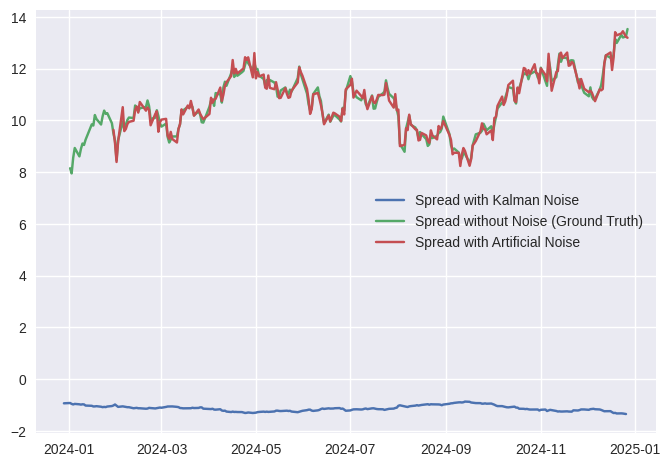

In [64]:
plt.plot(predicted_spread_kalman_without_ta, label="Spread with Kalman Noise")
plt.plot(spread_gt_short, label="Spread without Noise (Ground Truth)")
plt.plot(spread_noise, label="Spread with Artificial Noise")
plt.legend()
plt.show()

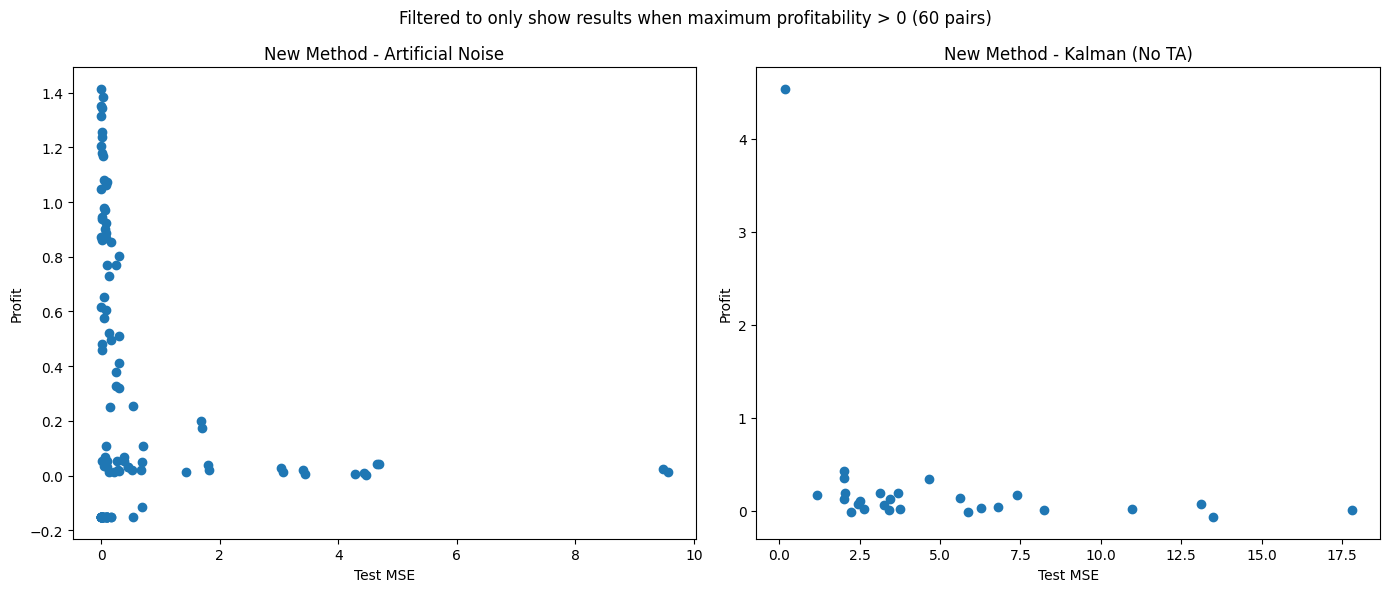

In [6]:
import re
import matplotlib.pyplot as plt

# Helper function to extract values from each block
def extract_values(method_block):
    artificial = []
    kalman_no_ta = None
    kalman_no_ta_mse = None

    # Artificial noise
    for match in re.finditer(
        r'Profits GT \+ artificial noise \((.*?) std dev\): ([\-\d\.e]+) \| Test MSE: ([\d\.e\-]+)', method_block
    ):
        profit = float(match.group(2))
        mse = float(match.group(3))
        artificial.append((mse, profit))
    # Kalman no TA
    kalman_match = re.search(
        r'Profits Kalman Predictions \(no TA\): ([\-\d\.e]+) \| Test MSE: ([\d\.e\-]+)', method_block
    )
    if kalman_match:
        kalman_no_ta = float(kalman_match.group(1))
        kalman_no_ta_mse = float(kalman_match.group(2))
    return artificial, (kalman_no_ta_mse, kalman_no_ta)

# Split data into blocks per method (original/new)
original_blocks = re.findall(r'--ORIGINAL METHOD--\n(.*?)(?=--NEW METHOD--|$)', logs, re.DOTALL)
new_blocks = re.findall(r'--NEW METHOD--\n(.*?)(?=--ORIGINAL METHOD--|$)', logs, re.DOTALL)

# Initialize lists
original_artificial, original_kalman = [], []
new_artificial, new_kalman = [], []

for block in original_blocks:
    art, kal = extract_values(block)
    original_artificial.append(art)
    original_kalman.append(kal)
for block in new_blocks:
    art, kal = extract_values(block)
    new_artificial.append(art)
    new_kalman.append(kal)

# Flatten for plotting
def flatten_artificial(artificial):
    mses, profits = [], []
    for entry in artificial:
        for mse, profit in entry:
            mses.append(mse)
            profits.append(profit)
    return mses, profits

def flatten_kalman(kalman):
    mses, profits = zip(*kalman)
    return list(mses), list(profits)

orig_art_mse, orig_art_profit = flatten_artificial(original_artificial)
new_art_mse, new_art_profit = flatten_artificial(new_artificial)
orig_kalman_mse, orig_kalman_profit = flatten_kalman(original_kalman)
new_kalman_mse, new_kalman_profit = flatten_kalman(new_kalman)

# PLOTTING
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Bottom-left: new method, artificial noise
axs[0].scatter(new_art_mse, new_art_profit)
axs[0].set_title('New Method - Artificial Noise')
axs[0].set_xlabel('Test MSE')
axs[0].set_ylabel('Profit')

# Bottom-right: new method, Kalman-caused noise (no TA)
axs[1].scatter(new_kalman_mse, new_kalman_profit)
axs[1].set_title('New Method - Kalman (No TA)')
axs[1].set_xlabel('Test MSE')
axs[1].set_ylabel('Profit')

fig.suptitle("Filtered to only show results when maximum profitability > 0 (60 pairs)")
fig.tight_layout()
plt.show()


<ipython-input-43-587e6035cf32>:97: RuntimeWarning: invalid value encountered in log
  return a * np.log(x + b) + c


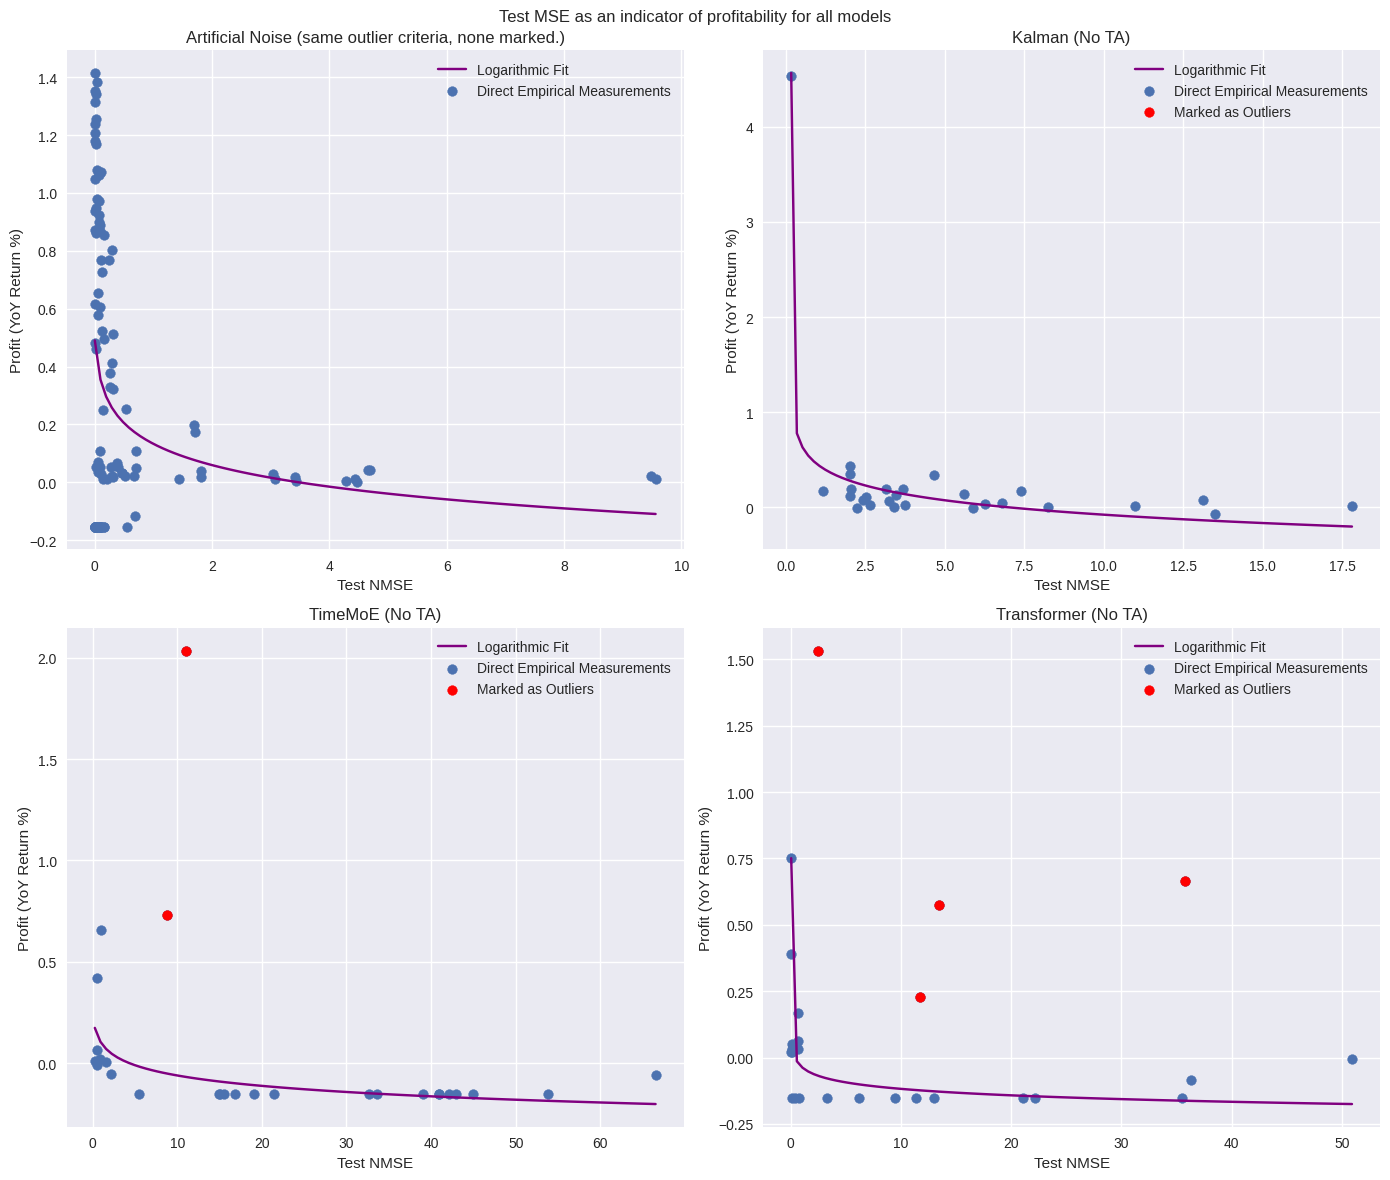

In [43]:
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

# Helper function to extract values from each block
def extract_values(method_block):
    artificial = []

    # Artificial noise extraction
    for match in re.finditer(
        r'Profits GT \+ artificial noise \((.*?) std dev\): ([\-\d\.e]+) \| Test MSE: ([\d\.e\-]+)', method_block
    ):
        profit = float(match.group(2))
        mse = float(match.group(3))
        artificial.append((mse, profit))

    # Model predictions extraction
    model_results = {}
    for model in ['Kalman', 'Transformer', 'TimeMoE']:
        # With TA (if present)
        ta_pat = fr'Profits {model} Predictions \(TA\): ([\-\d\.e]+) \| Test MSE: ([\d\.e\-]+)'
        ta_match = re.search(ta_pat, method_block)
        if ta_match:
            model_results[f'{model}_TA'] = (float(ta_match.group(2)), float(ta_match.group(1)))
        # No TA (always search)
        no_ta_pat = fr'Profits {model} Predictions \(no TA\): ([\-\d\.e]+) \| Test MSE: ([\d\.e\-]+)'
        no_ta_match = re.search(no_ta_pat, method_block)
        if no_ta_match:
            model_results[f'{model}_no_TA'] = (float(no_ta_match.group(2)), float(no_ta_match.group(1)))

    return artificial, model_results

# Split data into blocks per method (original/new)
original_blocks = re.findall(r'--ORIGINAL METHOD--\n(.*?)(?=--NEW METHOD--|$)', logs, re.DOTALL)
new_blocks = re.findall(r'--NEW METHOD--\n(.*?)(?=--ORIGINAL METHOD--|$)', logs, re.DOTALL)

# Collect all model types for dynamic plotting
all_models = set()

def collect_model_keys(blocks):
    keys = set()
    for block in blocks:
        _, model_dict = extract_values(block)
        keys.update(model_dict.keys())
    return keys

all_models.update(collect_model_keys(original_blocks))
all_models.update(collect_model_keys(new_blocks))

# Initialize lists
original_artificial, original_models = [], []
new_artificial, new_models = [], []

for block in original_blocks:
    art, models = extract_values(block)
    original_artificial.append(art)
    original_models.append(models)
for block in new_blocks:
    art, models = extract_values(block)
    new_artificial.append(art)
    new_models.append(models)

# Flatten for plotting
def flatten_artificial(artificial):
    mses, profits = [], []
    for entry in artificial:
        for mse, profit in entry:
            mses.append(mse)
            profits.append(profit)
    return mses, profits

def flatten_model(model_results_list, model_key):
    mses, profits = [], []
    for model_dict in model_results_list:
        val = model_dict.get(model_key)
        if val is not None:
            mses.append(val[0])
            profits.append(val[1])
    return mses, profits

# Prepare flattened data for plotting
orig_art_mse, orig_art_profit = flatten_artificial(original_artificial)
new_art_mse, new_art_profit = flatten_artificial(new_artificial)

# Plotting for each model (no TA) for the NEW method
model_keys = [k for k in all_models if k.endswith('_no_TA')]
model_keys.sort()  # optional: keep it ordered

# fig, axs = plt.subplots(1, len(model_keys) + 1, figsize=(7 * (len(model_keys) + 1), 6))
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
axs = axs.flatten()  # Flatten to 1D for easy indexing

# First plot: new method, artificial noise
from scipy.optimize import curve_fit
import numpy as np
def logarithmic(x, a, b, c):
    return a * np.log(x + b) + c

x0 = np.linspace(min(new_art_mse), max(new_art_mse), 100)
popt_log, _ = curve_fit(logarithmic, new_art_mse, new_art_profit, p0=[-1e5, 2, 2e5], maxfev=5000)
y0 = logarithmic(x0, *popt_log)
axs[0].plot(x0, y0, color="purple", label="Logarithmic Fit")

axs[0].scatter(new_art_mse, new_art_profit, label="Direct Empirical Measurements")
axs[0].set_title('Artificial Noise (same outlier criteria, none marked.)')
axs[0].set_xlabel('Test NMSE')
axs[0].set_ylabel('Profit (YoY Return %)')
axs[0].legend()

# Plots for each model (no TA)
for i, key in enumerate(model_keys, 1):
    mse, profit = flatten_model(new_models, key)
    # remove outliers where mse > 1 and profit > 0.2
    if key != 'Kalman_no_TA':
      outlier_idxs = [idx for idx, (mse_val, profit_val) in enumerate(zip(mse, profit)) if mse_val > 2 and profit_val > 0.2]
      mse_cleaned, profit_cleaned = [mse[i] for i in range(len(mse)) if i not in outlier_idxs], [profit[i] for i in range(len(profit)) if i not in outlier_idxs]
      mse_outliers, profit_outliers = [mse[i] for i in outlier_idxs], [profit[i] for i in outlier_idxs]
    else:
      mse_cleaned, profit_cleaned = mse, profit
      mse_outliers, profit_outliers = [], []


    x_i = np.linspace(min(mse_cleaned), max(mse_cleaned), 100)
    popt_log, _ = curve_fit(logarithmic, mse_cleaned, profit_cleaned, p0=[-1e5, 2, 2e5], maxfev=5000)
    y_i = logarithmic(x_i, *popt_log)
    axs[i].plot(x_i, y_i, color="purple", label="Logarithmic Fit")

    axs[i].scatter(mse, profit, label="Direct Empirical Measurements")
    axs[i].scatter(mse_outliers, profit_outliers, color="red", label="Marked as Outliers")
    axs[i].set_title(f'{key.replace("_no_TA", "")} (No TA)')
    axs[i].set_xlabel('Test NMSE')
    axs[i].set_ylabel('Profit (YoY Return %)')
    axs[i].legend()

fig.suptitle("Test MSE as an indicator of profitability for all models")
fig.tight_layout()
plt.show()

In [20]:
min(new_art_mse)
for i, key in enumerate(model_keys, 1):
    x_i = np.linspace(min(new_art_mse), max(new_art_mse), 100)

5.223106057376784e-05

In [38]:
# RESULTS 40 pairs, alpha = 0.1, all models used,

logs = """
Epoch 010 | train MSE 0.008027 | val MSE 0.000465
Epoch 020 | train MSE 0.006751 | val MSE 0.000718
Epoch 030 | train MSE 0.006938 | val MSE 0.000900
Epoch 040 | train MSE 0.005097 | val MSE 0.000252
Epoch 050 | train MSE 0.004641 | val MSE 0.002114
Epoch 060 | train MSE 0.004110 | val MSE 0.000253
Epoch 070 | train MSE 0.003752 | val MSE 0.000275
Epoch 080 | train MSE 0.002825 | val MSE 0.000297
Epoch 090 | train MSE 0.002412 | val MSE 0.000216
Epoch 100 | train MSE 0.001864 | val MSE 0.000364
Epoch 110 | train MSE 0.001361 | val MSE 0.000214
Epoch 120 | train MSE 0.001240 | val MSE 0.000341
Epoch 130 | train MSE 0.000973 | val MSE 0.000128
Epoch 140 | train MSE 0.000796 | val MSE 0.000131
Epoch 150 | train MSE 0.000740 | val MSE 0.000111
Epoch 160 | train MSE 0.000769 | val MSE 0.000152
Epoch 170 | train MSE 0.000662 | val MSE 0.000224
Epoch 180 | train MSE 0.000570 | val MSE 0.000219
Epoch 190 | train MSE 0.000606 | val MSE 0.000145
Epoch 200 | train MSE 0.000432 | val MSE 0.000106
Epoch 010 | train MSE 0.007224 | val MSE 0.001268
Epoch 020 | train MSE 0.005869 | val MSE 0.000452
Epoch 030 | train MSE 0.004485 | val MSE 0.000922
Epoch 040 | train MSE 0.004101 | val MSE 0.002654
Epoch 050 | train MSE 0.003618 | val MSE 0.000211
Epoch 060 | train MSE 0.003202 | val MSE 0.000859
Epoch 070 | train MSE 0.002622 | val MSE 0.000143
Epoch 080 | train MSE 0.002430 | val MSE 0.000295
Epoch 090 | train MSE 0.001992 | val MSE 0.000271
Epoch 100 | train MSE 0.001668 | val MSE 0.000201
Epoch 110 | train MSE 0.001383 | val MSE 0.000124
Epoch 120 | train MSE 0.001242 | val MSE 0.000111
Epoch 130 | train MSE 0.001053 | val MSE 0.000150
Epoch 140 | train MSE 0.000774 | val MSE 0.000306
Epoch 150 | train MSE 0.000795 | val MSE 0.000161
Epoch 160 | train MSE 0.000632 | val MSE 0.000151
Epoch 170 | train MSE 0.000637 | val MSE 0.000131
Epoch 180 | train MSE 0.000567 | val MSE 0.000154
Epoch 190 | train MSE 0.000564 | val MSE 0.000113
Epoch 200 | train MSE 0.000537 | val MSE 0.000269
/content/bsc-thesis/src/models/time_moe_model.py:99: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X = torch.tensor(X, dtype=torch.float32)
2025-05-26 16:27:24,186 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
config.json: 100%
 891/891 [00:00<00:00, 55.2kB/s]
model.safetensors: 100%
 227M/227M [00:02<00:00, 87.4MB/s]
generation_config.json: 100%
 69.0/69.0 [00:00<00:00, 6.56kB/s]

100%|██████████| 1/1 [00:00<00:00, 4288.65it/s]
Tracking run with wandb version 0.19.11
Run data is saved locally in /content/bsc-thesis/src/wandb/run-20250526_162729-t00br2mf
Syncing run peachy-meadow-21 to Weights & Biases (docs)
View project at https://wandb.ai/davidmoerdijk-smart-backoffice/huggingface
View run at https://wandb.ai/davidmoerdijk-smart-backoffice/huggingface/runs/t00br2mf
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.033900
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
configuration_time_moe.py: 100%
 2.50k/2.50k [00:00<00:00, 225kB/s]
A new version of the following files was downloaded from https://huggingface.co/Maple728/TimeMoE-50M:
- configuration_time_moe.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
--ORIGINAL METHOD--
Profits ground truth: 1470.8779359874563
Profits GT + artificial noise (0.87 std dev): 288.85798221053284 | Test MSE: 4.28503429747237
Profits GT + artificial noise (0.27 std dev): 2015.8091014986303 | Test MSE: 0.45562150743700375
Profits GT + artificial noise (0.22 std dev): 1083.7255424769983 | Test MSE: 0.30320464577755774
Profits GT + artificial noise (0.18 std dev): 757.9713090004484 | Test MSE: 0.21441482780731047
Profits Kalman Predictions (TA): 172680.26718509773 | Test MSE: 4.55029788417205
Profits Kalman Predictions (no TA): -4879.840350124712 | Test MSE: 13.496223643035892
Profits Transformer Predictions (TA): 908.284036438303 | Test MSE: 0.4532272219657898
Profits Transformer Predictions (no TA): 1364.5736949462837 | Test MSE: 0.08727648854255676
Profits TimeMoE Predictions (no TA): -772.0130020188018 | Test MSE: 0.4826519876448017
--NEW METHOD--
Profits ground truth: 0.02323832896284439
Profits GT + artificial noise (0.87 std dev): 0.004548294131991648 | Test MSE: 4.28503429747237
Profits GT + artificial noise (0.27 std dev): 0.03189696353151361 | Test MSE: 0.45562150743700375
Profits GT + artificial noise (0.22 std dev): 0.017102874599920215 | Test MSE: 0.30320464577755774
Profits GT + artificial noise (0.18 std dev): 0.01195086039543658 | Test MSE: 0.21441482780731047
Profits Kalman Predictions (TA): 3.3005137099139157 | Test MSE: 4.55029788417205
Profits Kalman Predictions (no TA): -0.0701683267963662 | Test MSE: 13.496223643035892
Profits Transformer Predictions (TA): 0.014326968931821948 | Test MSE: 0.4532272219657898
Profits Transformer Predictions (no TA): 0.02155231798254853 | Test MSE: 0.08727648854255676
Profits TimeMoE Predictions (no TA): -0.012118987184672636 | Test MSE: 0.4826519876448017
Epoch 010 | train MSE 0.004832 | val MSE 0.000180
Epoch 020 | train MSE 0.004540 | val MSE 0.000370
Epoch 030 | train MSE 0.003872 | val MSE 0.000105
Epoch 040 | train MSE 0.003816 | val MSE 0.002242
Epoch 050 | train MSE 0.003155 | val MSE 0.000486
Epoch 060 | train MSE 0.002658 | val MSE 0.000060
Epoch 070 | train MSE 0.002381 | val MSE 0.001000
Epoch 080 | train MSE 0.002026 | val MSE 0.000478
Epoch 090 | train MSE 0.001865 | val MSE 0.000064
Epoch 100 | train MSE 0.001407 | val MSE 0.000207
Epoch 110 | train MSE 0.001072 | val MSE 0.000068
Epoch 120 | train MSE 0.001033 | val MSE 0.000085
Epoch 130 | train MSE 0.000810 | val MSE 0.000050
Epoch 140 | train MSE 0.000685 | val MSE 0.000048
Epoch 150 | train MSE 0.000701 | val MSE 0.000625
Epoch 160 | train MSE 0.000733 | val MSE 0.000850
Epoch 170 | train MSE 0.000699 | val MSE 0.000124
Epoch 180 | train MSE 0.000613 | val MSE 0.000069
Epoch 190 | train MSE 0.000539 | val MSE 0.000079
Epoch 200 | train MSE 0.000642 | val MSE 0.000825
Epoch 010 | train MSE 0.005227 | val MSE 0.000266
Epoch 020 | train MSE 0.004765 | val MSE 0.004873
Epoch 030 | train MSE 0.003501 | val MSE 0.000374
Epoch 040 | train MSE 0.003100 | val MSE 0.001341
Epoch 050 | train MSE 0.002541 | val MSE 0.000492
Epoch 060 | train MSE 0.002377 | val MSE 0.000777
Epoch 070 | train MSE 0.001876 | val MSE 0.000496
Epoch 080 | train MSE 0.001547 | val MSE 0.000069
Epoch 090 | train MSE 0.001103 | val MSE 0.000300
Epoch 100 | train MSE 0.001078 | val MSE 0.000384
Epoch 110 | train MSE 0.001215 | val MSE 0.000789
Epoch 120 | train MSE 0.000785 | val MSE 0.001268
Epoch 130 | train MSE 0.000664 | val MSE 0.000865
Epoch 140 | train MSE 0.000655 | val MSE 0.000872
Epoch 150 | train MSE 0.000607 | val MSE 0.001156
Epoch 160 | train MSE 0.000576 | val MSE 0.001081
Epoch 170 | train MSE 0.000597 | val MSE 0.001983
Epoch 180 | train MSE 0.000584 | val MSE 0.000508
Epoch 190 | train MSE 0.000589 | val MSE 0.001535
Epoch 200 | train MSE 0.000544 | val MSE 0.000482
2025-05-26 16:33:53,044 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2563.76it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.022500
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Epoch 010 | train MSE 0.002741 | val MSE 0.000714
Epoch 020 | train MSE 0.002909 | val MSE 0.000178
Epoch 030 | train MSE 0.002722 | val MSE 0.000117
Epoch 040 | train MSE 0.002089 | val MSE 0.000298
Epoch 050 | train MSE 0.001879 | val MSE 0.000175
Epoch 060 | train MSE 0.001271 | val MSE 0.000105
Epoch 070 | train MSE 0.001363 | val MSE 0.000082
Epoch 080 | train MSE 0.001189 | val MSE 0.000069
Epoch 090 | train MSE 0.001129 | val MSE 0.000135
Epoch 100 | train MSE 0.000990 | val MSE 0.000715
Epoch 110 | train MSE 0.001199 | val MSE 0.000119
Epoch 120 | train MSE 0.016226 | val MSE 0.011889
Epoch 130 | train MSE 0.001295 | val MSE 0.000184
Epoch 140 | train MSE 0.001310 | val MSE 0.000154
Epoch 150 | train MSE 0.001264 | val MSE 0.000229
Epoch 160 | train MSE 0.001242 | val MSE 0.000178
Epoch 170 | train MSE 0.001418 | val MSE 0.000350
Epoch 180 | train MSE 0.001412 | val MSE 0.000705
Epoch 190 | train MSE 0.001283 | val MSE 0.001069
Early stopping triggered.
Epoch 010 | train MSE 0.002772 | val MSE 0.000218
Epoch 020 | train MSE 0.002506 | val MSE 0.000708
Epoch 030 | train MSE 0.002303 | val MSE 0.000188
Epoch 040 | train MSE 0.001886 | val MSE 0.000577
Epoch 050 | train MSE 0.001708 | val MSE 0.000582
Epoch 060 | train MSE 0.001438 | val MSE 0.000864
Epoch 070 | train MSE 0.001404 | val MSE 0.000971
Epoch 080 | train MSE 0.001337 | val MSE 0.000108
Epoch 090 | train MSE 0.001427 | val MSE 0.000137
Epoch 100 | train MSE 0.001326 | val MSE 0.000124
Epoch 110 | train MSE 0.001385 | val MSE 0.000818
Epoch 120 | train MSE 0.000997 | val MSE 0.000301
Epoch 130 | train MSE 0.000945 | val MSE 0.000151
Epoch 140 | train MSE 0.001001 | val MSE 0.000343
Epoch 150 | train MSE 0.000733 | val MSE 0.000506
Epoch 160 | train MSE 0.000676 | val MSE 0.001661
Epoch 170 | train MSE 0.000704 | val MSE 0.000706
Epoch 180 | train MSE 0.000798 | val MSE 0.000650
Epoch 190 | train MSE 0.000702 | val MSE 0.000648
Epoch 200 | train MSE 0.000904 | val MSE 0.001537
2025-05-26 16:40:06,364 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1227.84it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.023300
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 1190.600523965895
Profits GT + artificial noise (0.16 std dev): 2156.675483195668 | Test MSE: 0.055699347550457926
Profits GT + artificial noise (0.90 std dev): 2370.666531440281 | Test MSE: 1.8036107747394567
Profits GT + artificial noise (0.89 std dev): 1277.2756965447636 | Test MSE: 1.8179289094871114
Profits GT + artificial noise (0.33 std dev): 3398.910255528882 | Test MSE: 0.2726520375374508
Profits Kalman Predictions (TA): 16249.335140973482 | Test MSE: 4.04371371905866
Profits Kalman Predictions (no TA): -730.6573385969905 | Test MSE: 5.877897449105987
Profits Transformer Predictions (TA): 2273.431189303289 | Test MSE: 2.4812655448913574
Profits Transformer Predictions (no TA): 2016.506947819566 | Test MSE: 0.6438403725624084
Profits TimeMoE Predictions (no TA): 430.32222113756825 | Test MSE: 1.617758642269447
--NEW METHOD--
Profits ground truth: 0.01879524784710318
Profits GT + artificial noise (0.16 std dev): 0.034139569224254984 | Test MSE: 0.055699347550457926
Profits GT + artificial noise (0.90 std dev): 0.03754971934740392 | Test MSE: 1.8036107747394567
Profits GT + artificial noise (0.89 std dev): 0.020168508365380422 | Test MSE: 1.8179289094871114
Profits GT + artificial noise (0.33 std dev): 0.053992722185353115 | Test MSE: 0.2726520375374508
Profits Kalman Predictions (TA): 0.24477179315009612 | Test MSE: 4.04371371905866
Profits Kalman Predictions (no TA): -0.010607443437920971 | Test MSE: 5.877897449105987
Profits Transformer Predictions (TA): 0.035999674942329696 | Test MSE: 2.4812655448913574
Profits Transformer Predictions (no TA): 0.031908068935980305 | Test MSE: 0.6438403725624084
Profits TimeMoE Predictions (no TA): 0.00677850129224189 | Test MSE: 1.617758642269447
Epoch 010 | train MSE 0.012728 | val MSE 0.000748
Epoch 020 | train MSE 0.010653 | val MSE 0.001167
Epoch 030 | train MSE 0.010880 | val MSE 0.000452
Epoch 040 | train MSE 0.009179 | val MSE 0.000350
Epoch 050 | train MSE 0.007420 | val MSE 0.000853
Epoch 060 | train MSE 0.006302 | val MSE 0.000505
Epoch 070 | train MSE 0.006065 | val MSE 0.000654
Epoch 080 | train MSE 0.004869 | val MSE 0.000168
Epoch 090 | train MSE 0.004358 | val MSE 0.000744
Epoch 100 | train MSE 0.003569 | val MSE 0.000423
Epoch 110 | train MSE 0.002752 | val MSE 0.000278
Epoch 120 | train MSE 0.002303 | val MSE 0.000135
Epoch 130 | train MSE 0.001758 | val MSE 0.000142
Epoch 140 | train MSE 0.001441 | val MSE 0.000119
Epoch 150 | train MSE 0.001226 | val MSE 0.000133
Epoch 160 | train MSE 0.000942 | val MSE 0.000113
Epoch 170 | train MSE 0.000825 | val MSE 0.000147
Epoch 180 | train MSE 0.000778 | val MSE 0.000256
Epoch 190 | train MSE 0.000750 | val MSE 0.000145
Epoch 200 | train MSE 0.000654 | val MSE 0.000171
Epoch 010 | train MSE 0.007796 | val MSE 0.000917
Epoch 020 | train MSE 0.006729 | val MSE 0.005022
Epoch 030 | train MSE 0.005721 | val MSE 0.000348
Epoch 040 | train MSE 0.005246 | val MSE 0.000566
Epoch 050 | train MSE 0.004606 | val MSE 0.000957
Epoch 060 | train MSE 0.004474 | val MSE 0.000168
Epoch 070 | train MSE 0.003855 | val MSE 0.000206
Epoch 080 | train MSE 0.003909 | val MSE 0.000285
Epoch 090 | train MSE 0.003287 | val MSE 0.000194
Epoch 100 | train MSE 0.003159 | val MSE 0.000455
Epoch 110 | train MSE 0.002744 | val MSE 0.000169
Epoch 120 | train MSE 0.002386 | val MSE 0.000587
Epoch 130 | train MSE 0.002068 | val MSE 0.000226
Epoch 140 | train MSE 0.002095 | val MSE 0.000355
Epoch 150 | train MSE 0.001741 | val MSE 0.000320
Epoch 160 | train MSE 0.001605 | val MSE 0.000594
Epoch 170 | train MSE 0.001507 | val MSE 0.000229
Epoch 180 | train MSE 0.001542 | val MSE 0.000173
Epoch 190 | train MSE 0.001246 | val MSE 0.000358
Epoch 200 | train MSE 0.001114 | val MSE 0.000258
2025-05-26 16:46:27,082 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1968.23it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.033000
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 949.7243379603599
Profits GT + artificial noise (0.16 std dev): 1278.407178521385 | Test MSE: 0.2929040622226196
Profits GT + artificial noise (0.90 std dev): 1476.5576186097685 | Test MSE: 9.484580086168886
Profits GT + artificial noise (0.89 std dev): 787.53718221899 | Test MSE: 9.559874322375864
Profits GT + artificial noise (0.33 std dev): 819.5375466522336 | Test MSE: 1.4337850061106676
Profits Kalman Predictions (TA): 375158.78441185475 | Test MSE: 2.568115548357019
Profits Kalman Predictions (no TA): 1973.0178186218973 | Test MSE: 6.2777509554407915
Profits Transformer Predictions (TA): 978.4504766949333 | Test MSE: 0.13608941435813904
Profits Transformer Predictions (no TA): 1270.054977410823 | Test MSE: 0.07755640149116516
Profits TimeMoE Predictions (no TA): 534.4716901613157 | Test MSE: 0.25634834857889044
--NEW METHOD--
Profits ground truth: 0.014982404574510166
Profits GT + artificial noise (0.16 std dev): 0.02018643974947687 | Test MSE: 0.2929040622226196
Profits GT + artificial noise (0.90 std dev): 0.02332843861172229 | Test MSE: 9.484580086168886
Profits GT + artificial noise (0.89 std dev): 0.012418070389690117 | Test MSE: 9.559874322375864
Profits GT + artificial noise (0.33 std dev): 0.012923839591356234 | Test MSE: 1.4337850061106676
Profits Kalman Predictions (TA): -0.14205346835406496 | Test MSE: 2.568115548357019
Profits Kalman Predictions (no TA): 0.02881939001299383 | Test MSE: 6.2777509554407915
Profits Transformer Predictions (TA): 0.015436838692451937 | Test MSE: 0.13608941435813904
Profits Transformer Predictions (no TA): 0.020054079297813 | Test MSE: 0.07755640149116516
Profits TimeMoE Predictions (no TA): 0.008421586454176344 | Test MSE: 0.25634834857889044
Epoch 010 | train MSE 0.003262 | val MSE 0.003217
Epoch 020 | train MSE 0.003277 | val MSE 0.000964
Epoch 030 | train MSE 0.003413 | val MSE 0.003675
Epoch 040 | train MSE 0.002984 | val MSE 0.002094
Epoch 050 | train MSE 0.002543 | val MSE 0.001645
Epoch 060 | train MSE 0.002632 | val MSE 0.000969
Epoch 070 | train MSE 0.002346 | val MSE 0.000764
Epoch 080 | train MSE 0.002059 | val MSE 0.000240
Epoch 090 | train MSE 0.001821 | val MSE 0.000723
Epoch 100 | train MSE 0.001680 | val MSE 0.000418
Epoch 110 | train MSE 0.001535 | val MSE 0.000226
Epoch 120 | train MSE 0.001364 | val MSE 0.000427
Epoch 130 | train MSE 0.001322 | val MSE 0.000621
Epoch 140 | train MSE 0.001123 | val MSE 0.000196
Epoch 150 | train MSE 0.001170 | val MSE 0.000453
Epoch 160 | train MSE 0.001196 | val MSE 0.000163
Epoch 170 | train MSE 0.001061 | val MSE 0.000168
Epoch 180 | train MSE 0.000898 | val MSE 0.002055
Epoch 190 | train MSE 0.000913 | val MSE 0.000283
Epoch 200 | train MSE 0.000945 | val MSE 0.000169
Epoch 010 | train MSE 0.003784 | val MSE 0.002121
Epoch 020 | train MSE 0.003972 | val MSE 0.001431
Epoch 030 | train MSE 0.003213 | val MSE 0.002599
Epoch 040 | train MSE 0.002889 | val MSE 0.000634
Epoch 050 | train MSE 0.002682 | val MSE 0.000779
Epoch 060 | train MSE 0.002389 | val MSE 0.000747
Epoch 070 | train MSE 0.002190 | val MSE 0.000462
Epoch 080 | train MSE 0.001896 | val MSE 0.001375
Epoch 090 | train MSE 0.001861 | val MSE 0.001783
Epoch 100 | train MSE 0.001672 | val MSE 0.001155
Epoch 110 | train MSE 0.001557 | val MSE 0.000810
Epoch 120 | train MSE 0.001321 | val MSE 0.000316
Epoch 130 | train MSE 0.001254 | val MSE 0.000687
Epoch 140 | train MSE 0.001368 | val MSE 0.002951
Epoch 150 | train MSE 0.001294 | val MSE 0.000850
Epoch 160 | train MSE 0.001154 | val MSE 0.000329
Epoch 170 | train MSE 0.000990 | val MSE 0.000303
Epoch 180 | train MSE 0.001075 | val MSE 0.000421
Epoch 190 | train MSE 0.001032 | val MSE 0.000372
Epoch 200 | train MSE 0.000990 | val MSE 0.000495
2025-05-26 16:52:47,540 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3320.91it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.012700
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Epoch 010 | train MSE 0.014336 | val MSE 0.000810
Epoch 020 | train MSE 0.012334 | val MSE 0.003447
Epoch 030 | train MSE 0.012098 | val MSE 0.000169
Epoch 040 | train MSE 0.010817 | val MSE 0.000865
Epoch 050 | train MSE 0.009049 | val MSE 0.000234
Epoch 060 | train MSE 0.007799 | val MSE 0.000811
Epoch 070 | train MSE 0.007052 | val MSE 0.000534
Epoch 080 | train MSE 0.005836 | val MSE 0.000968
Epoch 090 | train MSE 0.005039 | val MSE 0.002075
Epoch 100 | train MSE 0.004097 | val MSE 0.000118
Epoch 110 | train MSE 0.003210 | val MSE 0.000411
Epoch 120 | train MSE 0.002779 | val MSE 0.000184
Epoch 130 | train MSE 0.001957 | val MSE 0.000222
Epoch 140 | train MSE 0.001603 | val MSE 0.000112
Epoch 150 | train MSE 0.001477 | val MSE 0.000228
Epoch 160 | train MSE 0.001166 | val MSE 0.000125
Epoch 170 | train MSE 0.001168 | val MSE 0.000164
Epoch 180 | train MSE 0.000886 | val MSE 0.000277
Epoch 190 | train MSE 0.000860 | val MSE 0.000186
Epoch 200 | train MSE 0.000783 | val MSE 0.000189
Epoch 010 | train MSE 0.007940 | val MSE 0.001617
Epoch 020 | train MSE 0.006931 | val MSE 0.001367
Epoch 030 | train MSE 0.006246 | val MSE 0.000561
Epoch 040 | train MSE 0.006176 | val MSE 0.001689
Epoch 050 | train MSE 0.005078 | val MSE 0.000588
Epoch 060 | train MSE 0.004745 | val MSE 0.000793
Epoch 070 | train MSE 0.004524 | val MSE 0.001247
Epoch 080 | train MSE 0.004109 | val MSE 0.000331
Epoch 090 | train MSE 0.003521 | val MSE 0.000175
Epoch 100 | train MSE 0.003187 | val MSE 0.000648
Epoch 110 | train MSE 0.002786 | val MSE 0.000751
Epoch 120 | train MSE 0.002690 | val MSE 0.000177
Epoch 130 | train MSE 0.002157 | val MSE 0.001078
Epoch 140 | train MSE 0.001955 | val MSE 0.000166
Epoch 150 | train MSE 0.001862 | val MSE 0.000210
Epoch 160 | train MSE 0.001750 | val MSE 0.000428
Epoch 170 | train MSE 0.001625 | val MSE 0.000353
Epoch 180 | train MSE 0.001734 | val MSE 0.001063
Epoch 190 | train MSE 0.001750 | val MSE 0.000907
Epoch 200 | train MSE 0.001923 | val MSE 0.000234
2025-05-26 16:59:06,843 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2978.91it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.039200
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Epoch 010 | train MSE 0.004858 | val MSE 0.000288
Epoch 020 | train MSE 0.004349 | val MSE 0.000139
Epoch 030 | train MSE 0.004011 | val MSE 0.000566
Epoch 040 | train MSE 0.004026 | val MSE 0.004915
Epoch 050 | train MSE 0.003199 | val MSE 0.000325
Epoch 060 | train MSE 0.002515 | val MSE 0.000079
Epoch 070 | train MSE 0.003421 | val MSE 0.000993
Epoch 080 | train MSE 0.001885 | val MSE 0.000276
Epoch 090 | train MSE 0.001542 | val MSE 0.000169
Epoch 100 | train MSE 0.001214 | val MSE 0.000125
Epoch 110 | train MSE 0.001040 | val MSE 0.000141
Epoch 120 | train MSE 0.001006 | val MSE 0.000057
Epoch 130 | train MSE 0.000875 | val MSE 0.000317
Epoch 140 | train MSE 0.000783 | val MSE 0.000111
Epoch 150 | train MSE 0.000781 | val MSE 0.000254
Epoch 160 | train MSE 0.000789 | val MSE 0.000652
Epoch 170 | train MSE 0.000750 | val MSE 0.000069
Epoch 180 | train MSE 0.000673 | val MSE 0.000055
Epoch 190 | train MSE 0.000618 | val MSE 0.000173
Epoch 200 | train MSE 0.000706 | val MSE 0.000320
Epoch 010 | train MSE 0.005267 | val MSE 0.000585
Epoch 020 | train MSE 0.004617 | val MSE 0.001893
Epoch 030 | train MSE 0.004457 | val MSE 0.000139
Epoch 040 | train MSE 0.003552 | val MSE 0.001146
Epoch 050 | train MSE 0.002672 | val MSE 0.000204
Epoch 060 | train MSE 0.002252 | val MSE 0.000164
Epoch 070 | train MSE 0.002089 | val MSE 0.000622
Epoch 080 | train MSE 0.001974 | val MSE 0.000511
Epoch 090 | train MSE 0.001434 | val MSE 0.001160
Epoch 100 | train MSE 0.001181 | val MSE 0.000643
Epoch 110 | train MSE 0.000992 | val MSE 0.000225
Epoch 120 | train MSE 0.001010 | val MSE 0.001021
Epoch 130 | train MSE 0.000804 | val MSE 0.000360
Epoch 140 | train MSE 0.000785 | val MSE 0.001256
Epoch 150 | train MSE 0.000716 | val MSE 0.001443
Epoch 160 | train MSE 0.000741 | val MSE 0.002882
Epoch 170 | train MSE 0.000684 | val MSE 0.000322
Epoch 180 | train MSE 0.000678 | val MSE 0.000595
Epoch 190 | train MSE 0.000700 | val MSE 0.001902
Epoch 200 | train MSE 0.000840 | val MSE 0.001183
2025-05-26 17:05:25,387 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2538.92it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.021600
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Epoch 010 | train MSE 0.003732 | val MSE 0.009009
Epoch 020 | train MSE 0.003661 | val MSE 0.021686
Epoch 030 | train MSE 0.003607 | val MSE 0.013669
Epoch 040 | train MSE 0.003201 | val MSE 0.019083
Epoch 050 | train MSE 0.002996 | val MSE 0.045281
Epoch 060 | train MSE 0.003082 | val MSE 0.122020
Epoch 070 | train MSE 0.002487 | val MSE 0.069769
Epoch 080 | train MSE 0.002156 | val MSE 0.067917
Epoch 090 | train MSE 0.001857 | val MSE 0.057120
Epoch 100 | train MSE 0.001582 | val MSE 0.000431
Epoch 110 | train MSE 0.001534 | val MSE 0.008045
Epoch 120 | train MSE 0.001395 | val MSE 0.018934
Epoch 130 | train MSE 0.001205 | val MSE 0.022399
Epoch 140 | train MSE 0.001145 | val MSE 0.022549
Epoch 150 | train MSE 0.001117 | val MSE 0.027797
Epoch 160 | train MSE 0.001166 | val MSE 0.019729
Epoch 170 | train MSE 0.000958 | val MSE 0.028989
Epoch 180 | train MSE 0.000976 | val MSE 0.038659
Epoch 190 | train MSE 0.000909 | val MSE 0.024639
Epoch 200 | train MSE 0.000897 | val MSE 0.026074
Epoch 010 | train MSE 0.004865 | val MSE 0.014216
Epoch 020 | train MSE 0.005025 | val MSE 0.024687
Epoch 030 | train MSE 0.005043 | val MSE 0.032038
Epoch 040 | train MSE 0.003760 | val MSE 0.041235
Epoch 050 | train MSE 0.003562 | val MSE 0.054123
Epoch 060 | train MSE 0.003007 | val MSE 0.017500
Epoch 070 | train MSE 0.002555 | val MSE 0.020663
Epoch 080 | train MSE 0.002357 | val MSE 0.014529
Epoch 090 | train MSE 0.002068 | val MSE 0.033823
Epoch 100 | train MSE 0.002063 | val MSE 0.025345
Epoch 110 | train MSE 0.001709 | val MSE 0.029417
Epoch 120 | train MSE 0.001503 | val MSE 0.028020
Epoch 130 | train MSE 0.001386 | val MSE 0.026958
Epoch 140 | train MSE 0.001552 | val MSE 0.023711
Epoch 150 | train MSE 0.001459 | val MSE 0.029233
Epoch 160 | train MSE 0.001168 | val MSE 0.027463
Epoch 170 | train MSE 0.001269 | val MSE 0.025268
Epoch 180 | train MSE 0.001206 | val MSE 0.026321
Epoch 190 | train MSE 0.001357 | val MSE 0.038565
Epoch 200 | train MSE 0.001235 | val MSE 0.024319
2025-05-26 17:11:44,069 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2870.84it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.012000
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 67839.62882847499
Profits GT + artificial noise (0.16 std dev): 70479.0644323012 | Test MSE: 0.0013581205355561441
Profits GT + artificial noise (0.90 std dev): 54346.897591679626 | Test MSE: 0.04397754981070415
Profits GT + artificial noise (0.89 std dev): 59246.753337992566 | Test MSE: 0.04432666974992846
Profits GT + artificial noise (0.33 std dev): 66818.31636872352 | Test MSE: 0.0066480910015218435
Profits Kalman Predictions (TA): 29736.022473050554 | Test MSE: 3.030969326891587
Profits Kalman Predictions (no TA): 11074.124250577172 | Test MSE: 1.1727571088846236
Profits Transformer Predictions (TA): 9160.231757273727 | Test MSE: 35.268646240234375
Profits Transformer Predictions (no TA): -5499.191166172222 | Test MSE: 36.34163284301758
Profits TimeMoE Predictions (no TA): -43124.84788754759 | Test MSE: 40.98501100164946
--NEW METHOD--
Profits ground truth: 1.258505251688303
Profits GT + artificial noise (0.16 std dev): 1.3146347884696747 | Test MSE: 0.0013581205355561441
Profits GT + artificial noise (0.90 std dev): 0.9795168512901111 | Test MSE: 0.04397754981070415
Profits GT + artificial noise (0.89 std dev): 1.0792790449483158 | Test MSE: 0.04432666974992846
Profits GT + artificial noise (0.33 std dev): 1.2369212838367427 | Test MSE: 0.0066480910015218435
Profits Kalman Predictions (TA): 0.4601948151925903 | Test MSE: 3.030969326891587
Profits Kalman Predictions (no TA): 0.16500962316930168 | Test MSE: 1.1727571088846236
Profits Transformer Predictions (TA): 0.1478519567041876 | Test MSE: 35.268646240234375
Profits Transformer Predictions (no TA): -0.08514281033463145 | Test MSE: 36.34163284301758
Profits TimeMoE Predictions (no TA): -0.15275142982180867 | Test MSE: 40.98501100164946
Epoch 010 | train MSE 0.004208 | val MSE 0.002695
Epoch 020 | train MSE 0.004204 | val MSE 0.004587
Epoch 030 | train MSE 0.004296 | val MSE 0.004312
Epoch 040 | train MSE 0.003661 | val MSE 0.008317
Epoch 050 | train MSE 0.003455 | val MSE 0.009570
Epoch 060 | train MSE 0.003517 | val MSE 0.002282
Epoch 070 | train MSE 0.003054 | val MSE 0.030473
Epoch 080 | train MSE 0.002572 | val MSE 0.098027
Epoch 090 | train MSE 0.002619 | val MSE 0.000938
Epoch 100 | train MSE 0.001949 | val MSE 0.004697
Epoch 110 | train MSE 0.001811 | val MSE 0.005897
Epoch 120 | train MSE 0.001604 | val MSE 0.009302
Epoch 130 | train MSE 0.001403 | val MSE 0.011524
Epoch 140 | train MSE 0.001344 | val MSE 0.011811
Epoch 150 | train MSE 0.001243 | val MSE 0.017894
Epoch 160 | train MSE 0.001239 | val MSE 0.007894
Epoch 170 | train MSE 0.001132 | val MSE 0.014945
Epoch 180 | train MSE 0.001096 | val MSE 0.015361
Epoch 190 | train MSE 0.001113 | val MSE 0.010591
Epoch 200 | train MSE 0.001063 | val MSE 0.013793
Epoch 010 | train MSE 0.004453 | val MSE 0.001410
Epoch 020 | train MSE 0.005471 | val MSE 0.009286
Epoch 030 | train MSE 0.004791 | val MSE 0.017999
Epoch 040 | train MSE 0.003682 | val MSE 0.022846
Epoch 050 | train MSE 0.003300 | val MSE 0.027075
Epoch 060 | train MSE 0.003144 | val MSE 0.034813
Epoch 070 | train MSE 0.002564 | val MSE 0.003961
Epoch 080 | train MSE 0.003291 | val MSE 0.058053
Epoch 090 | train MSE 0.002229 | val MSE 0.011969
Epoch 100 | train MSE 0.002286 | val MSE 0.009924
Epoch 110 | train MSE 0.001812 | val MSE 0.012221
Epoch 120 | train MSE 0.001685 | val MSE 0.014156
Epoch 130 | train MSE 0.001794 | val MSE 0.016947
Epoch 140 | train MSE 0.001668 | val MSE 0.014569
Epoch 150 | train MSE 0.001636 | val MSE 0.019463
Epoch 160 | train MSE 0.001315 | val MSE 0.007079
Early stopping triggered.
2025-05-26 17:17:31,554 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1548.86it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.011700
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 37695.74918726723
Profits GT + artificial noise (0.16 std dev): 35723.41307986837 | Test MSE: 0.0027736864524941854
Profits GT + artificial noise (0.90 std dev): 6663.698327910118 | Test MSE: 0.08981524903744141
Profits GT + artificial noise (0.89 std dev): 35103.02058221884 | Test MSE: 0.09052825588798982
Profits GT + artificial noise (0.33 std dev): 27159.221915242168 | Test MSE: 0.013577380993152177
Profits Kalman Predictions (TA): 24974.177159752944 | Test MSE: 2.169843550245165
Profits Kalman Predictions (no TA): 4857.034006265326 | Test MSE: 2.4362740625757544
Profits Transformer Predictions (TA): 6456.386227650492 | Test MSE: 43.8288688659668
Profits Transformer Predictions (no TA): -312.71766891843527 | Test MSE: 50.90504455566406
Profits TimeMoE Predictions (no TA): -3662.252352990472 | Test MSE: 66.5286778692726
--NEW METHOD--
Profits ground truth: 0.6540945162215357
Profits GT + artificial noise (0.16 std dev): 0.6169721932215675 | Test MSE: 0.0027736864524941854
Profits GT + artificial noise (0.90 std dev): 0.10682229841753133 | Test MSE: 0.08981524903744141
Profits GT + artificial noise (0.89 std dev): 0.6053590594463027 | Test MSE: 0.09052825588798982
Profits GT + artificial noise (0.33 std dev): 0.45937859556435057 | Test MSE: 0.013577380993152177
Profits Kalman Predictions (TA): 0.38291166451338743 | Test MSE: 2.169843550245165
Profits Kalman Predictions (no TA): 0.07140246264653505 | Test MSE: 2.4362740625757544
Profits Transformer Predictions (TA): 0.10343971349580228 | Test MSE: 43.8288688659668
Profits Transformer Predictions (no TA): -0.004915499589029149 | Test MSE: 50.90504455566406
Profits TimeMoE Predictions (no TA): -0.05700930722190323 | Test MSE: 66.5286778692726
Epoch 010 | train MSE 0.003255 | val MSE 0.001032
Epoch 020 | train MSE 0.003161 | val MSE 0.001674
Epoch 030 | train MSE 0.002923 | val MSE 0.001982
Epoch 040 | train MSE 0.002539 | val MSE 0.001067
Epoch 050 | train MSE 0.002425 | val MSE 0.002412
Epoch 060 | train MSE 0.002239 | val MSE 0.001087
Epoch 070 | train MSE 0.002158 | val MSE 0.001329
Epoch 080 | train MSE 0.001799 | val MSE 0.001973
Epoch 090 | train MSE 0.001594 | val MSE 0.000249
Epoch 100 | train MSE 0.001434 | val MSE 0.001854
Epoch 110 | train MSE 0.001202 | val MSE 0.001677
Epoch 120 | train MSE 0.001128 | val MSE 0.000853
Epoch 130 | train MSE 0.001008 | val MSE 0.002998
Epoch 140 | train MSE 0.000991 | val MSE 0.001901
Epoch 150 | train MSE 0.001112 | val MSE 0.002576
Epoch 160 | train MSE 0.001048 | val MSE 0.002319
Epoch 170 | train MSE 0.000871 | val MSE 0.001474
Epoch 180 | train MSE 0.000739 | val MSE 0.000656
Epoch 190 | train MSE 0.000985 | val MSE 0.001680
Epoch 200 | train MSE 0.000797 | val MSE 0.001324
Epoch 010 | train MSE 0.005145 | val MSE 0.001635
Epoch 020 | train MSE 0.004456 | val MSE 0.003840
Epoch 030 | train MSE 0.004486 | val MSE 0.002170
Epoch 040 | train MSE 0.003738 | val MSE 0.005220
Epoch 050 | train MSE 0.003117 | val MSE 0.003255
Epoch 060 | train MSE 0.002210 | val MSE 0.000644
Epoch 070 | train MSE 0.002117 | val MSE 0.000753
Epoch 080 | train MSE 0.001959 | val MSE 0.000344
Epoch 090 | train MSE 0.001559 | val MSE 0.000362
Epoch 100 | train MSE 0.001438 | val MSE 0.000709
Epoch 110 | train MSE 0.001336 | val MSE 0.000956
Epoch 120 | train MSE 0.001224 | val MSE 0.004002
Epoch 130 | train MSE 0.001060 | val MSE 0.000585
Epoch 140 | train MSE 0.001179 | val MSE 0.002073
Epoch 150 | train MSE 0.001556 | val MSE 0.000834
Epoch 160 | train MSE 0.000927 | val MSE 0.004333
Epoch 170 | train MSE 0.000906 | val MSE 0.003260
Epoch 180 | train MSE 0.000982 | val MSE 0.002171
Epoch 190 | train MSE 0.001036 | val MSE 0.003019
Epoch 200 | train MSE 0.000966 | val MSE 0.002291
2025-05-26 17:23:49,909 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2468.69it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.015900
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Epoch 010 | train MSE 0.009405 | val MSE 0.001844
Epoch 020 | train MSE 0.008667 | val MSE 0.000651
Epoch 030 | train MSE 0.008307 | val MSE 0.000234
Epoch 040 | train MSE 0.007109 | val MSE 0.001264
Epoch 050 | train MSE 0.006485 | val MSE 0.002019
Epoch 060 | train MSE 0.005519 | val MSE 0.000866
Epoch 070 | train MSE 0.005262 | val MSE 0.001626
Epoch 080 | train MSE 0.003974 | val MSE 0.000131
Epoch 090 | train MSE 0.003291 | val MSE 0.000107
Epoch 100 | train MSE 0.002709 | val MSE 0.000262
Epoch 110 | train MSE 0.002072 | val MSE 0.000080
Epoch 120 | train MSE 0.001901 | val MSE 0.000134
Epoch 130 | train MSE 0.001432 | val MSE 0.000096
Epoch 140 | train MSE 0.001176 | val MSE 0.000090
Epoch 150 | train MSE 0.000982 | val MSE 0.000087
Epoch 160 | train MSE 0.000901 | val MSE 0.000135
Epoch 170 | train MSE 0.000726 | val MSE 0.000089
Epoch 180 | train MSE 0.000571 | val MSE 0.000085
Epoch 190 | train MSE 0.000609 | val MSE 0.000108
Epoch 200 | train MSE 0.000682 | val MSE 0.000079
Epoch 010 | train MSE 0.006841 | val MSE 0.002171
Epoch 020 | train MSE 0.007100 | val MSE 0.000675
Epoch 030 | train MSE 0.005636 | val MSE 0.000290
Epoch 040 | train MSE 0.005108 | val MSE 0.005396
Epoch 050 | train MSE 0.004634 | val MSE 0.000624
Epoch 060 | train MSE 0.004540 | val MSE 0.000237
Epoch 070 | train MSE 0.003560 | val MSE 0.000187
Epoch 080 | train MSE 0.003744 | val MSE 0.000772
Epoch 090 | train MSE 0.002841 | val MSE 0.001365
Epoch 100 | train MSE 0.002522 | val MSE 0.000871
Epoch 110 | train MSE 0.002100 | val MSE 0.000144
Epoch 120 | train MSE 0.001755 | val MSE 0.000500
Epoch 130 | train MSE 0.001788 | val MSE 0.000146
Epoch 140 | train MSE 0.001390 | val MSE 0.000472
Epoch 150 | train MSE 0.001328 | val MSE 0.000244
Epoch 160 | train MSE 0.000975 | val MSE 0.000610
Epoch 170 | train MSE 0.000957 | val MSE 0.000261
Epoch 180 | train MSE 0.000772 | val MSE 0.001311
Epoch 190 | train MSE 0.000744 | val MSE 0.000317
Epoch 200 | train MSE 0.000674 | val MSE 0.000272
2025-05-26 17:30:09,615 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2668.13it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.035300
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 3082.655521971456
Profits GT + artificial noise (0.16 std dev): 3380.5120281002987 | Test MSE: 0.09387130877772723
Profits GT + artificial noise (0.90 std dev): 1804.8277495076873 | Test MSE: 3.0396640426896955
Profits GT + artificial noise (0.89 std dev): 812.2770500012753 | Test MSE: 3.063794703229311
Profits GT + artificial noise (0.33 std dev): 2000.5029336424634 | Test MSE: 0.4595063448699967
Profits Kalman Predictions (TA): 266795.55028989445 | Test MSE: 10.42207713027438
Profits Kalman Predictions (no TA): 1342.3560811051393 | Test MSE: 3.745861407435601
Profits Transformer Predictions (TA): 2816.8753575149553 | Test MSE: 0.4650163948535919
Profits Transformer Predictions (no TA): 3299.7650215692556 | Test MSE: 0.0938505232334137
Profits TimeMoE Predictions (no TA): 4123.993916610558 | Test MSE: 0.47840530970685813
--NEW METHOD--
Profits ground truth: 0.048925353744611266
Profits GT + artificial noise (0.16 std dev): 0.05369768255061458 | Test MSE: 0.09387130877772723
Profits GT + artificial noise (0.90 std dev): 0.028541440658516715 | Test MSE: 3.0396640426896955
Profits GT + artificial noise (0.89 std dev): 0.012809078588280398 | Test MSE: 3.063794703229311
Profits GT + artificial noise (0.33 std dev): 0.03165339480288587 | Test MSE: 0.4595063448699967
Profits Kalman Predictions (TA): 5.6187506679599295 | Test MSE: 10.42207713027438
Profits Kalman Predictions (no TA): 0.01957967824826823 | Test MSE: 3.745861407435601
Profits Transformer Predictions (TA): 0.04467362811708964 | Test MSE: 0.4650163948535919
Profits Transformer Predictions (no TA): 0.05240315468381662 | Test MSE: 0.0938505232334137
Profits TimeMoE Predictions (no TA): 0.0656443299815157 | Test MSE: 0.47840530970685813
Epoch 010 | train MSE 0.003273 | val MSE 0.000785
Epoch 020 | train MSE 0.003259 | val MSE 0.001038
Epoch 030 | train MSE 0.003518 | val MSE 0.001108
Epoch 040 | train MSE 0.003021 | val MSE 0.000661
Epoch 050 | train MSE 0.003406 | val MSE 0.001179
Epoch 060 | train MSE 0.002529 | val MSE 0.000434
Epoch 070 | train MSE 0.002625 | val MSE 0.001823
Epoch 080 | train MSE 0.002090 | val MSE 0.000234
Epoch 090 | train MSE 0.001970 | val MSE 0.000454
Epoch 100 | train MSE 0.001981 | val MSE 0.001636
Epoch 110 | train MSE 0.001572 | val MSE 0.001961
Epoch 120 | train MSE 0.001497 | val MSE 0.000572
Epoch 130 | train MSE 0.001319 | val MSE 0.001688
Epoch 140 | train MSE 0.001261 | val MSE 0.000522
Epoch 150 | train MSE 0.001064 | val MSE 0.000687
Epoch 160 | train MSE 0.001080 | val MSE 0.000799
Epoch 170 | train MSE 0.000976 | val MSE 0.001178
Epoch 180 | train MSE 0.000868 | val MSE 0.001245
Epoch 190 | train MSE 0.000892 | val MSE 0.000841
Epoch 200 | train MSE 0.000766 | val MSE 0.000435
Epoch 010 | train MSE 0.004202 | val MSE 0.001579
Epoch 020 | train MSE 0.004759 | val MSE 0.002976
Epoch 030 | train MSE 0.004009 | val MSE 0.001468
Epoch 040 | train MSE 0.003352 | val MSE 0.002212
Epoch 050 | train MSE 0.003169 | val MSE 0.001837
Epoch 060 | train MSE 0.002610 | val MSE 0.001178
Epoch 070 | train MSE 0.002434 | val MSE 0.000326
Epoch 080 | train MSE 0.002158 | val MSE 0.000361
Epoch 090 | train MSE 0.001956 | val MSE 0.000626
Epoch 100 | train MSE 0.001934 | val MSE 0.000345
Epoch 110 | train MSE 0.001578 | val MSE 0.000456
Epoch 120 | train MSE 0.001477 | val MSE 0.000683
Epoch 130 | train MSE 0.001618 | val MSE 0.002348
Epoch 140 | train MSE 0.001586 | val MSE 0.000317
Epoch 150 | train MSE 0.001428 | val MSE 0.001339
Epoch 160 | train MSE 0.001480 | val MSE 0.000698
Epoch 170 | train MSE 0.001460 | val MSE 0.003130
Epoch 180 | train MSE 0.001407 | val MSE 0.000909
Epoch 190 | train MSE 0.001337 | val MSE 0.002507
Epoch 200 | train MSE 0.001366 | val MSE 0.000320
2025-05-26 17:36:29,440 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3477.86it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.011700
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 33579.7629081964
Profits GT + artificial noise (0.16 std dev): 31447.991772764988 | Test MSE: 0.004949140520613121
Profits GT + artificial noise (0.90 std dev): 66245.47995215771 | Test MSE: 0.16025902566616493
Profits GT + artificial noise (0.89 std dev): 47112.68645634988 | Test MSE: 0.16153125710110264
Profits GT + artificial noise (0.33 std dev): 82022.82632722185 | Test MSE: 0.024226374389429192
Profits Kalman Predictions (TA): 528998.9717952455 | Test MSE: 0.06182313783465808
Profits Kalman Predictions (no TA): 22484.502193743647 | Test MSE: 4.665539198247322
Profits Transformer Predictions (TA): 63567.51422724979 | Test MSE: 5.72358512878418
Profits Transformer Predictions (no TA): -56264.15529024412 | Test MSE: 11.391334533691406
Profits TimeMoE Predictions (no TA): 129797.11225247214 | Test MSE: 33.63710197479598
--NEW METHOD--
Profits ground truth: -0.15275142982180867
Profits GT + artificial noise (0.16 std dev): -0.15275142982180867 | Test MSE: 0.004949140520613121
Profits GT + artificial noise (0.90 std dev): -0.15275142982180867 | Test MSE: 0.16025902566616493
Profits GT + artificial noise (0.89 std dev): -0.15275142982180867 | Test MSE: 0.16153125710110264
Profits GT + artificial noise (0.33 std dev): -0.15275142982180867 | Test MSE: 0.024226374389429192
Profits Kalman Predictions (TA): -0.14205346835406496 | Test MSE: 0.06182313783465808
Profits Kalman Predictions (no TA): 0.3430312622883278 | Test MSE: 4.665539198247322
Profits Transformer Predictions (TA): -0.15275142982180867 | Test MSE: 5.72358512878418
Profits Transformer Predictions (no TA): -0.15275142982180867 | Test MSE: 11.391334533691406
Profits TimeMoE Predictions (no TA): -0.15275142982180867 | Test MSE: 33.63710197479598
Epoch 010 | train MSE 0.003545 | val MSE 0.000724
Epoch 020 | train MSE 0.003699 | val MSE 0.001274
Epoch 030 | train MSE 0.003417 | val MSE 0.001264
Epoch 040 | train MSE 0.002965 | val MSE 0.002410
Epoch 050 | train MSE 0.003451 | val MSE 0.009558
Epoch 060 | train MSE 0.002772 | val MSE 0.013206
Epoch 070 | train MSE 0.002630 | val MSE 0.012771
Epoch 080 | train MSE 0.002249 | val MSE 0.007286
Epoch 090 | train MSE 0.002128 | val MSE 0.001148
Epoch 100 | train MSE 0.001787 | val MSE 0.005201
Epoch 110 | train MSE 0.001642 | val MSE 0.002847
Epoch 120 | train MSE 0.001526 | val MSE 0.005178
Epoch 130 | train MSE 0.001256 | val MSE 0.008278
Epoch 140 | train MSE 0.001175 | val MSE 0.005568
Epoch 150 | train MSE 0.001118 | val MSE 0.005371
Epoch 160 | train MSE 0.001071 | val MSE 0.004880
Epoch 170 | train MSE 0.000911 | val MSE 0.003207
Epoch 180 | train MSE 0.000894 | val MSE 0.002434
Epoch 190 | train MSE 0.000843 | val MSE 0.010425
Epoch 200 | train MSE 0.000857 | val MSE 0.004342
Epoch 010 | train MSE 0.005174 | val MSE 0.003726
Epoch 020 | train MSE 0.005450 | val MSE 0.008542
Epoch 030 | train MSE 0.004576 | val MSE 0.005969
Epoch 040 | train MSE 0.003841 | val MSE 0.008054
Epoch 050 | train MSE 0.003817 | val MSE 0.012828
Epoch 060 | train MSE 0.003157 | val MSE 0.004156
Epoch 070 | train MSE 0.002726 | val MSE 0.004534
Epoch 080 | train MSE 0.003607 | val MSE 0.055337
Epoch 090 | train MSE 0.003107 | val MSE 0.050936
Epoch 100 | train MSE 0.003435 | val MSE 0.050837
Epoch 110 | train MSE 0.002358 | val MSE 0.006960
Epoch 120 | train MSE 0.002054 | val MSE 0.008743
Epoch 130 | train MSE 0.001878 | val MSE 0.010066
Epoch 140 | train MSE 0.002067 | val MSE 0.008211
Epoch 150 | train MSE 0.001478 | val MSE 0.004201
Epoch 160 | train MSE 0.001256 | val MSE 0.008731
Epoch 170 | train MSE 0.001220 | val MSE 0.004053
Epoch 180 | train MSE 0.001084 | val MSE 0.004087
Epoch 190 | train MSE 0.001354 | val MSE 0.011547
Epoch 200 | train MSE 0.001203 | val MSE 0.003946
2025-05-26 17:42:47,591 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1543.73it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.011900
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 74235.6630597142
Profits GT + artificial noise (0.16 std dev): 64109.09912069645 | Test MSE: 0.007723590749694491
Profits GT + artificial noise (0.90 std dev): 43679.734150155586 | Test MSE: 0.2500990066931667
Profits GT + artificial noise (0.89 std dev): 22620.87173599153 | Test MSE: 0.2520844413158915
Profits GT + artificial noise (0.33 std dev): 73703.70957230263 | Test MSE: 0.037807494120140735
Profits Kalman Predictions (TA): 21340.463427346356 | Test MSE: 0.2957115783039213
Profits Kalman Predictions (no TA): 9495.373582104963 | Test MSE: 5.608421172698604
Profits Transformer Predictions (TA): 16862.641200313417 | Test MSE: 31.58678436279297
Profits Transformer Predictions (no TA): 38324.00547824543 | Test MSE: 35.78907775878906
Profits TimeMoE Predictions (no TA): -27774.328134060248 | Test MSE: 32.638502172726376
--NEW METHOD--
Profits ground truth: 1.3953837775691307
Profits GT + artificial noise (0.16 std dev): 1.1800327772190013 | Test MSE: 0.007723590749694491
Profits GT + artificial noise (0.90 std dev): 0.7685875592127012 | Test MSE: 0.2500990066931667
Profits GT + artificial noise (0.89 std dev): 0.3782761200075433 | Test MSE: 0.2520844413158915
Profits GT + artificial noise (0.33 std dev): 1.3838880570265286 | Test MSE: 0.037807494120140735
Profits Kalman Predictions (TA): -0.14205346835406496 | Test MSE: 0.2957115783039213
Profits Kalman Predictions (no TA): 0.1410079464942251 | Test MSE: 5.608421172698604
Profits Transformer Predictions (TA): -0.15275142982180867 | Test MSE: 31.58678436279297
Profits Transformer Predictions (no TA): 0.6659836101214123 | Test MSE: 35.78907775878906
Profits TimeMoE Predictions (no TA): -0.15275142982180867 | Test MSE: 32.638502172726376
Epoch 010 | train MSE 0.003377 | val MSE 0.004247
Epoch 020 | train MSE 0.003467 | val MSE 0.007147
Epoch 030 | train MSE 0.003628 | val MSE 0.004194
Epoch 040 | train MSE 0.002906 | val MSE 0.012029
Epoch 050 | train MSE 0.003172 | val MSE 0.020192
Epoch 060 | train MSE 0.002887 | val MSE 0.057390
Epoch 070 | train MSE 0.002506 | val MSE 0.024542
Epoch 080 | train MSE 0.002215 | val MSE 0.000194
Epoch 090 | train MSE 0.001981 | val MSE 0.004940
Epoch 100 | train MSE 0.001679 | val MSE 0.010438
Epoch 110 | train MSE 0.001489 | val MSE 0.003781
Epoch 120 | train MSE 0.001390 | val MSE 0.007917
Epoch 130 | train MSE 0.001250 | val MSE 0.013008
Epoch 140 | train MSE 0.001235 | val MSE 0.012151
Epoch 150 | train MSE 0.001138 | val MSE 0.014936
Epoch 160 | train MSE 0.001255 | val MSE 0.009385
Epoch 170 | train MSE 0.001103 | val MSE 0.017368
Epoch 180 | train MSE 0.001057 | val MSE 0.012355
Epoch 190 | train MSE 0.000997 | val MSE 0.014057
Epoch 200 | train MSE 0.001079 | val MSE 0.019018
Epoch 010 | train MSE 0.004735 | val MSE 0.008989
Epoch 020 | train MSE 0.005622 | val MSE 0.018225
Epoch 030 | train MSE 0.004876 | val MSE 0.006894
Epoch 040 | train MSE 0.003721 | val MSE 0.021870
Epoch 050 | train MSE 0.003571 | val MSE 0.021759
Epoch 060 | train MSE 0.003456 | val MSE 0.045277
Epoch 070 | train MSE 0.002683 | val MSE 0.017735
Epoch 080 | train MSE 0.002445 | val MSE 0.008718
Epoch 090 | train MSE 0.002159 | val MSE 0.001393
Epoch 100 | train MSE 0.002065 | val MSE 0.001529
Epoch 110 | train MSE 0.001762 | val MSE 0.008347
Epoch 120 | train MSE 0.001566 | val MSE 0.012160
Epoch 130 | train MSE 0.001548 | val MSE 0.011961
Epoch 140 | train MSE 0.001699 | val MSE 0.008945
Epoch 150 | train MSE 0.001625 | val MSE 0.012959
Epoch 160 | train MSE 0.001401 | val MSE 0.019946
Epoch 170 | train MSE 0.001480 | val MSE 0.014735
Epoch 180 | train MSE 0.001373 | val MSE 0.010243
Epoch 190 | train MSE 0.001566 | val MSE 0.016764
Epoch 200 | train MSE 0.001517 | val MSE 0.012901
2025-05-26 17:49:08,487 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2413.29it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.011600
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 52968.3721329829
Profits GT + artificial noise (0.16 std dev): 49230.77474082836 | Test MSE: 0.002524750203567917
Profits GT + artificial noise (0.90 std dev): 48733.06756076685 | Test MSE: 0.0817543987666207
Profits GT + artificial noise (0.89 std dev): 49792.07583222296 | Test MSE: 0.08240341379477889
Profits GT + artificial noise (0.33 std dev): 48443.35548340576 | Test MSE: 0.012358821378514115
Profits Kalman Predictions (TA): 14785.167451076171 | Test MSE: 1.0112591530596413
Profits Kalman Predictions (no TA): 7239.8733317950955 | Test MSE: 2.5158169654135976
Profits Transformer Predictions (TA): 9659.878377466157 | Test MSE: 23.957107543945312
Profits Transformer Predictions (no TA): -8606.341729172022 | Test MSE: 35.51682662963867
Profits TimeMoE Predictions (no TA): 25415.027792792825 | Test MSE: 19.053963476256836
--NEW METHOD--
Profits ground truth: -0.15275142982180867
Profits GT + artificial noise (0.16 std dev): -0.15275142982180867 | Test MSE: 0.002524750203567917
Profits GT + artificial noise (0.90 std dev): 0.8674312131655864 | Test MSE: 0.0817543987666207
Profits GT + artificial noise (0.89 std dev): 0.8883928828248737 | Test MSE: 0.08240341379477889
Profits GT + artificial noise (0.33 std dev): 0.8617116094115613 | Test MSE: 0.012358821378514115
Profits Kalman Predictions (TA): -0.14205346835406496 | Test MSE: 1.0112591530596413
Profits Kalman Predictions (no TA): 0.10698978249231916 | Test MSE: 2.5158169654135976
Profits Transformer Predictions (TA): 0.15612867763640015 | Test MSE: 23.957107543945312
Profits Transformer Predictions (no TA): -0.15275142982180867 | Test MSE: 35.51682662963867
Profits TimeMoE Predictions (no TA): -0.15275142982180867 | Test MSE: 19.053963476256836
Epoch 010 | train MSE 0.009445 | val MSE 0.000505
Epoch 020 | train MSE 0.008520 | val MSE 0.000950
Epoch 030 | train MSE 0.008532 | val MSE 0.000218
Epoch 040 | train MSE 0.007689 | val MSE 0.000704
Epoch 050 | train MSE 0.006457 | val MSE 0.001309
Epoch 060 | train MSE 0.005489 | val MSE 0.000323
Epoch 070 | train MSE 0.004808 | val MSE 0.001911
Epoch 080 | train MSE 0.003978 | val MSE 0.000184
Epoch 090 | train MSE 0.003296 | val MSE 0.000121
Epoch 100 | train MSE 0.002778 | val MSE 0.000677
Epoch 110 | train MSE 0.002072 | val MSE 0.000097
Epoch 120 | train MSE 0.001682 | val MSE 0.000114
Epoch 130 | train MSE 0.001123 | val MSE 0.000146
Epoch 140 | train MSE 0.000919 | val MSE 0.000084
Epoch 150 | train MSE 0.000805 | val MSE 0.000192
Epoch 160 | train MSE 0.000723 | val MSE 0.000091
Epoch 170 | train MSE 0.000600 | val MSE 0.000130
Epoch 180 | train MSE 0.000541 | val MSE 0.000109
Epoch 190 | train MSE 0.000595 | val MSE 0.000188
Epoch 200 | train MSE 0.000486 | val MSE 0.000091
Epoch 010 | train MSE 0.005690 | val MSE 0.001167
Epoch 020 | train MSE 0.005765 | val MSE 0.001005
Epoch 030 | train MSE 0.005295 | val MSE 0.000281
Epoch 040 | train MSE 0.005121 | val MSE 0.002484
Epoch 050 | train MSE 0.004062 | val MSE 0.000155
Epoch 060 | train MSE 0.003835 | val MSE 0.000291
Epoch 070 | train MSE 0.003288 | val MSE 0.000925
Epoch 080 | train MSE 0.003126 | val MSE 0.000237
Epoch 090 | train MSE 0.002718 | val MSE 0.000251
Epoch 100 | train MSE 0.002425 | val MSE 0.000410
Epoch 110 | train MSE 0.001993 | val MSE 0.000464
Epoch 120 | train MSE 0.001821 | val MSE 0.000205
Epoch 130 | train MSE 0.001508 | val MSE 0.000743
Epoch 140 | train MSE 0.001280 | val MSE 0.000231
Epoch 150 | train MSE 0.001103 | val MSE 0.000647
Epoch 160 | train MSE 0.000920 | val MSE 0.000521
Epoch 170 | train MSE 0.000697 | val MSE 0.000545
Epoch 180 | train MSE 0.000669 | val MSE 0.001024
Epoch 190 | train MSE 0.000628 | val MSE 0.000430
Epoch 200 | train MSE 0.000567 | val MSE 0.000401
2025-05-26 17:55:27,661 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2474.52it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.032200
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 2583.2875257115847
Profits GT + artificial noise (0.16 std dev): 1873.8529089971946 | Test MSE: 0.10518571898619868
Profits GT + artificial noise (0.90 std dev): 1218.8899199823545 | Test MSE: 3.406038031960122
Profits GT + artificial noise (0.89 std dev): 259.05715798775947 | Test MSE: 3.433077187070672
Profits GT + artificial noise (0.33 std dev): 1386.1769424594133 | Test MSE: 0.5148911407884708
Profits Kalman Predictions (TA): 244791.50093473733 | Test MSE: 8.024302110087051
Profits Kalman Predictions (no TA): 1642.8739598339941 | Test MSE: 2.638884650732853
Profits Transformer Predictions (TA): 1765.882461010392 | Test MSE: 0.6657041907310486
Profits Transformer Predictions (no TA): 3042.2707218005608 | Test MSE: 0.19431059062480927
Profits TimeMoE Predictions (no TA): 1401.9150278962036 | Test MSE: 0.8940939353007106
--NEW METHOD--
Profits ground truth: 0.04094208619022721
Profits GT + artificial noise (0.16 std dev): 0.02963880313526146 | Test MSE: 0.10518571898619868
Profits GT + artificial noise (0.90 std dev): 0.019243384113056816 | Test MSE: 3.406038031960122
Profits GT + artificial noise (0.89 std dev): 0.00407870904514529 | Test MSE: 3.433077187070672
Profits GT + artificial noise (0.33 std dev): 0.0218948686875029 | Test MSE: 0.5148911407884708
Profits Kalman Predictions (TA): 5.049308637758077 | Test MSE: 8.024302110087051
Profits Kalman Predictions (no TA): 0.02397926448111587 | Test MSE: 2.638884650732853
Profits Transformer Predictions (TA): 0.02792247636126044 | Test MSE: 0.6657041907310486
Profits Transformer Predictions (no TA): 0.04827890659079581 | Test MSE: 0.19431059062480927
Profits TimeMoE Predictions (no TA): 0.022144445119949285 | Test MSE: 0.8940939353007106
Epoch 010 | train MSE 0.009792 | val MSE 0.001963
Epoch 020 | train MSE 0.008947 | val MSE 0.000652
Epoch 030 | train MSE 0.008669 | val MSE 0.000139
Epoch 040 | train MSE 0.007520 | val MSE 0.001555
Epoch 050 | train MSE 0.006793 | val MSE 0.001345
Epoch 060 | train MSE 0.006007 | val MSE 0.000747
Epoch 070 | train MSE 0.005668 | val MSE 0.001892
Epoch 080 | train MSE 0.004202 | val MSE 0.000096
Epoch 090 | train MSE 0.003874 | val MSE 0.000098
Epoch 100 | train MSE 0.003048 | val MSE 0.000264
Epoch 110 | train MSE 0.002330 | val MSE 0.000078
Epoch 120 | train MSE 0.002157 | val MSE 0.000313
Epoch 130 | train MSE 0.001545 | val MSE 0.000498
Epoch 140 | train MSE 0.001411 | val MSE 0.000295
Epoch 150 | train MSE 0.001157 | val MSE 0.000154
Epoch 160 | train MSE 0.000992 | val MSE 0.000127
Epoch 170 | train MSE 0.000807 | val MSE 0.000811
Epoch 180 | train MSE 0.000886 | val MSE 0.004825
Epoch 190 | train MSE 0.000668 | val MSE 0.001430
Epoch 200 | train MSE 0.000559 | val MSE 0.000463
Epoch 010 | train MSE 0.006237 | val MSE 0.000647
Epoch 020 | train MSE 0.006662 | val MSE 0.000584
Epoch 030 | train MSE 0.005500 | val MSE 0.000250
Epoch 040 | train MSE 0.005210 | val MSE 0.005504
Epoch 050 | train MSE 0.004814 | val MSE 0.000225
Epoch 060 | train MSE 0.004148 | val MSE 0.000126
Epoch 070 | train MSE 0.004176 | val MSE 0.000822
Epoch 080 | train MSE 0.003909 | val MSE 0.000701
Epoch 090 | train MSE 0.003067 | val MSE 0.000813
Epoch 100 | train MSE 0.002518 | val MSE 0.008853
Epoch 110 | train MSE 0.002155 | val MSE 0.000464
Epoch 120 | train MSE 0.001740 | val MSE 0.000752
Epoch 130 | train MSE 0.001654 | val MSE 0.000184
Epoch 140 | train MSE 0.001319 | val MSE 0.002076
Epoch 150 | train MSE 0.001151 | val MSE 0.000292
Epoch 160 | train MSE 0.001017 | val MSE 0.001176
Epoch 170 | train MSE 0.000864 | val MSE 0.001012
Epoch 180 | train MSE 0.000755 | val MSE 0.000576
Epoch 190 | train MSE 0.000762 | val MSE 0.000929
Epoch 200 | train MSE 0.000734 | val MSE 0.000375
2025-05-26 18:01:48,469 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3530.56it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.034500
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Epoch 010 | train MSE 0.003557 | val MSE 0.002016
Epoch 020 | train MSE 0.003664 | val MSE 0.005037
Epoch 030 | train MSE 0.003779 | val MSE 0.003113
Epoch 040 | train MSE 0.003188 | val MSE 0.006039
Epoch 050 | train MSE 0.002920 | val MSE 0.009822
Epoch 060 | train MSE 0.002997 | val MSE 0.019588
Epoch 070 | train MSE 0.002528 | val MSE 0.015920
Epoch 080 | train MSE 0.002245 | val MSE 0.019084
Epoch 090 | train MSE 0.002010 | val MSE 0.001416
Epoch 100 | train MSE 0.001694 | val MSE 0.002980
Epoch 110 | train MSE 0.001511 | val MSE 0.003448
Epoch 120 | train MSE 0.001358 | val MSE 0.005001
Epoch 130 | train MSE 0.001208 | val MSE 0.004778
Epoch 140 | train MSE 0.001200 | val MSE 0.003306
Epoch 150 | train MSE 0.001099 | val MSE 0.006709
Epoch 160 | train MSE 0.001148 | val MSE 0.003472
Epoch 170 | train MSE 0.000973 | val MSE 0.007039
Epoch 180 | train MSE 0.000932 | val MSE 0.004208
Epoch 190 | train MSE 0.000902 | val MSE 0.005330
Epoch 200 | train MSE 0.000946 | val MSE 0.007817
Epoch 010 | train MSE 0.005091 | val MSE 0.005995
Epoch 020 | train MSE 0.005369 | val MSE 0.014926
Epoch 030 | train MSE 0.004745 | val MSE 0.007956
Epoch 040 | train MSE 0.003816 | val MSE 0.018003
Epoch 050 | train MSE 0.003554 | val MSE 0.017567
Epoch 060 | train MSE 0.003107 | val MSE 0.006372
Epoch 070 | train MSE 0.002713 | val MSE 0.005725
Epoch 080 | train MSE 0.002491 | val MSE 0.004271
Epoch 090 | train MSE 0.002139 | val MSE 0.005386
Epoch 100 | train MSE 0.002055 | val MSE 0.003734
Epoch 110 | train MSE 0.001829 | val MSE 0.000719
Epoch 120 | train MSE 0.001475 | val MSE 0.006369
Epoch 130 | train MSE 0.001334 | val MSE 0.007182
Epoch 140 | train MSE 0.001498 | val MSE 0.003381
Epoch 150 | train MSE 0.001295 | val MSE 0.005414
Epoch 160 | train MSE 0.001185 | val MSE 0.008178
Epoch 170 | train MSE 0.001062 | val MSE 0.001307
Epoch 180 | train MSE 0.001130 | val MSE 0.003872
Epoch 190 | train MSE 0.001160 | val MSE 0.005782
Epoch 200 | train MSE 0.001178 | val MSE 0.007647
2025-05-26 18:08:12,087 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3802.63it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.011500
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 62178.68051562224
Profits GT + artificial noise (0.16 std dev): 57688.70793797884 | Test MSE: 0.0020550511727588216
Profits GT + artificial noise (0.90 std dev): 50367.955275403285 | Test MSE: 0.06654498842147204
Profits GT + artificial noise (0.89 std dev): 53975.10406799174 | Test MSE: 0.06707326210687259
Profits GT + artificial noise (0.33 std dev): 52217.19800573168 | Test MSE: 0.010059613157745414
Profits Kalman Predictions (TA): 14088.36694611475 | Test MSE: 0.526416162656324
Profits Kalman Predictions (no TA): 8199.623143988565 | Test MSE: 2.0199087775321196
Profits Transformer Predictions (TA): 6100.592977564225 | Test MSE: 14.15307331085205
Profits Transformer Predictions (no TA): -18999.088804971325 | Test MSE: 21.087034225463867
Profits TimeMoE Predictions (no TA): 36538.5568988841 | Test MSE: 14.881720078760482
--NEW METHOD--
Profits ground truth: 1.1398243143848976
Profits GT + artificial noise (0.16 std dev): 1.047363238936684 | Test MSE: 0.0020550511727588216
Profits GT + artificial noise (0.90 std dev): 0.8998274053270314 | Test MSE: 0.06654498842147204
Profits GT + artificial noise (0.89 std dev): 0.9720201892972962 | Test MSE: 0.06707326210687259
Profits GT + artificial noise (0.33 std dev): 0.9367152464794863 | Test MSE: 0.010059613157745414
Profits Kalman Predictions (TA): -0.14205346835406496 | Test MSE: 0.526416162656324
Profits Kalman Predictions (no TA): 0.12142571427187021 | Test MSE: 2.0199087775321196
Profits Transformer Predictions (TA): -0.15275142982180867 | Test MSE: 14.15307331085205
Profits Transformer Predictions (no TA): -0.15275142982180867 | Test MSE: 21.087034225463867
Profits TimeMoE Predictions (no TA): -0.15275142982180867 | Test MSE: 14.881720078760482
Epoch 010 | train MSE 0.004019 | val MSE 0.000788
Epoch 020 | train MSE 0.003877 | val MSE 0.000301
Epoch 030 | train MSE 0.003883 | val MSE 0.000422
Epoch 040 | train MSE 0.003674 | val MSE 0.000547
Epoch 050 | train MSE 0.003805 | val MSE 0.000532
Epoch 060 | train MSE 0.003023 | val MSE 0.000217
Epoch 070 | train MSE 0.002939 | val MSE 0.002527
Epoch 080 | train MSE 0.002465 | val MSE 0.000361
Epoch 090 | train MSE 0.002071 | val MSE 0.000326
Epoch 100 | train MSE 0.004118 | val MSE 0.000721
Epoch 110 | train MSE 0.002910 | val MSE 0.000818
Epoch 120 | train MSE 0.002961 | val MSE 0.000764
Epoch 130 | train MSE 0.002359 | val MSE 0.000131
Epoch 140 | train MSE 0.002135 | val MSE 0.000191
Epoch 150 | train MSE 0.001873 | val MSE 0.000349
Epoch 160 | train MSE 0.001686 | val MSE 0.000280
Epoch 170 | train MSE 0.001551 | val MSE 0.000292
Epoch 180 | train MSE 0.001468 | val MSE 0.000222
Epoch 190 | train MSE 0.001354 | val MSE 0.001101
Epoch 200 | train MSE 0.001303 | val MSE 0.000630
Epoch 010 | train MSE 0.004733 | val MSE 0.003314
Epoch 020 | train MSE 0.004907 | val MSE 0.000732
Epoch 030 | train MSE 0.004022 | val MSE 0.000744
Epoch 040 | train MSE 0.003943 | val MSE 0.000257
Epoch 050 | train MSE 0.003467 | val MSE 0.000409
Epoch 060 | train MSE 0.002846 | val MSE 0.000837
Epoch 070 | train MSE 0.002922 | val MSE 0.000917
Epoch 080 | train MSE 0.002496 | val MSE 0.000110
Epoch 090 | train MSE 0.001966 | val MSE 0.000218
Epoch 100 | train MSE 0.002027 | val MSE 0.000207
Epoch 110 | train MSE 0.001606 | val MSE 0.000100
Epoch 120 | train MSE 0.001616 | val MSE 0.000158
Epoch 130 | train MSE 0.001502 | val MSE 0.000884
Epoch 140 | train MSE 0.001544 | val MSE 0.000068
Epoch 150 | train MSE 0.001536 | val MSE 0.000607
Epoch 160 | train MSE 0.001368 | val MSE 0.000062
Epoch 170 | train MSE 0.001272 | val MSE 0.001188
Epoch 180 | train MSE 0.001319 | val MSE 0.001442
Epoch 190 | train MSE 0.001402 | val MSE 0.002603
Epoch 200 | train MSE 0.001323 | val MSE 0.000193
2025-05-26 18:14:31,370 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2820.65it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.011500
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Epoch 010 | train MSE 0.004165 | val MSE 0.001781
Epoch 020 | train MSE 0.003213 | val MSE 0.003971
Epoch 030 | train MSE 0.003007 | val MSE 0.000959
Epoch 040 | train MSE 0.002490 | val MSE 0.000974
Epoch 050 | train MSE 0.002189 | val MSE 0.001335
Epoch 060 | train MSE 0.001956 | val MSE 0.000829
Epoch 070 | train MSE 0.001658 | val MSE 0.001640
Epoch 080 | train MSE 0.001464 | val MSE 0.001075
Epoch 090 | train MSE 0.001390 | val MSE 0.001265
Epoch 100 | train MSE 0.001027 | val MSE 0.000759
Epoch 110 | train MSE 0.001076 | val MSE 0.001082
Epoch 120 | train MSE 0.000958 | val MSE 0.001339
Epoch 130 | train MSE 0.000798 | val MSE 0.001231
Epoch 140 | train MSE 0.000771 | val MSE 0.000583
Epoch 150 | train MSE 0.000682 | val MSE 0.002236
Epoch 160 | train MSE 0.000745 | val MSE 0.000667
Epoch 170 | train MSE 0.000782 | val MSE 0.001372
Epoch 180 | train MSE 0.000767 | val MSE 0.001960
Epoch 190 | train MSE 0.000685 | val MSE 0.000435
Epoch 200 | train MSE 0.000633 | val MSE 0.001791
Epoch 010 | train MSE 0.004015 | val MSE 0.002525
Epoch 020 | train MSE 0.003800 | val MSE 0.002271
Epoch 030 | train MSE 0.003597 | val MSE 0.004055
Epoch 040 | train MSE 0.003028 | val MSE 0.006052
Epoch 050 | train MSE 0.002033 | val MSE 0.002084
Epoch 060 | train MSE 0.001844 | val MSE 0.002288
Epoch 070 | train MSE 0.001676 | val MSE 0.004704
Epoch 080 | train MSE 0.002493 | val MSE 0.007295
Epoch 090 | train MSE 0.001240 | val MSE 0.001552
Epoch 100 | train MSE 0.001152 | val MSE 0.003214
Epoch 110 | train MSE 0.000922 | val MSE 0.000783
Epoch 120 | train MSE 0.001001 | val MSE 0.000653
Epoch 130 | train MSE 0.000870 | val MSE 0.001600
Epoch 140 | train MSE 0.001064 | val MSE 0.000949
Epoch 150 | train MSE 0.000962 | val MSE 0.005670
Epoch 160 | train MSE 0.000774 | val MSE 0.002808
Epoch 170 | train MSE 0.000741 | val MSE 0.001119
Epoch 180 | train MSE 0.000953 | val MSE 0.001132
Epoch 190 | train MSE 0.000931 | val MSE 0.002082
Epoch 200 | train MSE 0.000845 | val MSE 0.000759
2025-05-26 18:20:51,007 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3106.89it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.019500
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Epoch 010 | train MSE 0.003676 | val MSE 0.001201
Epoch 020 | train MSE 0.003378 | val MSE 0.001167
Epoch 030 | train MSE 0.003683 | val MSE 0.003037
Epoch 040 | train MSE 0.002973 | val MSE 0.000535
Epoch 050 | train MSE 0.002556 | val MSE 0.001429
Epoch 060 | train MSE 0.002516 | val MSE 0.000790
Epoch 070 | train MSE 0.002184 | val MSE 0.001099
Epoch 080 | train MSE 0.002010 | val MSE 0.000565
Epoch 090 | train MSE 0.001779 | val MSE 0.000610
Epoch 100 | train MSE 0.001612 | val MSE 0.000316
Epoch 110 | train MSE 0.001596 | val MSE 0.000754
Epoch 120 | train MSE 0.001356 | val MSE 0.000294
Epoch 130 | train MSE 0.001269 | val MSE 0.000723
Epoch 140 | train MSE 0.001196 | val MSE 0.000290
Epoch 150 | train MSE 0.001164 | val MSE 0.000265
Epoch 160 | train MSE 0.001248 | val MSE 0.000242
Epoch 170 | train MSE 0.001051 | val MSE 0.000560
Epoch 180 | train MSE 0.001130 | val MSE 0.000461
Epoch 190 | train MSE 0.001012 | val MSE 0.000922
Epoch 200 | train MSE 0.001022 | val MSE 0.000322
Epoch 010 | train MSE 0.004065 | val MSE 0.003431
Epoch 020 | train MSE 0.004265 | val MSE 0.001110
Epoch 030 | train MSE 0.003439 | val MSE 0.001271
Epoch 040 | train MSE 0.002985 | val MSE 0.000596
Epoch 050 | train MSE 0.002688 | val MSE 0.000475
Epoch 060 | train MSE 0.002336 | val MSE 0.001033
Epoch 070 | train MSE 0.002171 | val MSE 0.000436
Epoch 080 | train MSE 0.001857 | val MSE 0.000354
Epoch 090 | train MSE 0.002578 | val MSE 0.003927
Epoch 100 | train MSE 0.002069 | val MSE 0.000514
Epoch 110 | train MSE 0.002296 | val MSE 0.003323
Epoch 120 | train MSE 0.002428 | val MSE 0.002443
Epoch 130 | train MSE 0.002452 | val MSE 0.002535
Epoch 140 | train MSE 0.002244 | val MSE 0.002127
Epoch 150 | train MSE 0.002438 | val MSE 0.001854
Epoch 160 | train MSE 0.002136 | val MSE 0.000921
Epoch 170 | train MSE 0.001736 | val MSE 0.000477
Epoch 180 | train MSE 0.001597 | val MSE 0.000365
Epoch 190 | train MSE 0.001435 | val MSE 0.000369
Epoch 200 | train MSE 0.001396 | val MSE 0.000311
2025-05-26 18:27:13,213 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3785.47it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.013500
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Epoch 010 | train MSE 0.003487 | val MSE 0.001198
Epoch 020 | train MSE 0.003632 | val MSE 0.002424
Epoch 030 | train MSE 0.003720 | val MSE 0.000631
Epoch 040 | train MSE 0.003713 | val MSE 0.004833
Epoch 050 | train MSE 0.002758 | val MSE 0.004001
Epoch 060 | train MSE 0.002604 | val MSE 0.003925
Epoch 070 | train MSE 0.002338 | val MSE 0.008544
Epoch 080 | train MSE 0.002029 | val MSE 0.000088
Epoch 090 | train MSE 0.001709 | val MSE 0.000610
Epoch 100 | train MSE 0.001580 | val MSE 0.003665
Epoch 110 | train MSE 0.001456 | val MSE 0.001793
Epoch 120 | train MSE 0.001186 | val MSE 0.002019
Epoch 130 | train MSE 0.001089 | val MSE 0.003487
Epoch 140 | train MSE 0.000999 | val MSE 0.002840
Epoch 150 | train MSE 0.000979 | val MSE 0.008568
Epoch 160 | train MSE 0.000994 | val MSE 0.003588
Epoch 170 | train MSE 0.000875 | val MSE 0.005056
Epoch 180 | train MSE 0.000844 | val MSE 0.001965
Epoch 190 | train MSE 0.000808 | val MSE 0.003867
Epoch 200 | train MSE 0.000812 | val MSE 0.002460
Epoch 010 | train MSE 0.005787 | val MSE 0.007951
Epoch 020 | train MSE 0.004652 | val MSE 0.005966
Epoch 030 | train MSE 0.004524 | val MSE 0.005483
Epoch 040 | train MSE 0.003523 | val MSE 0.006498
Epoch 050 | train MSE 0.003335 | val MSE 0.001040
Epoch 060 | train MSE 0.003031 | val MSE 0.002051
Epoch 070 | train MSE 0.002607 | val MSE 0.005302
Epoch 080 | train MSE 0.002355 | val MSE 0.001318
Epoch 090 | train MSE 0.001844 | val MSE 0.001821
Epoch 100 | train MSE 0.001835 | val MSE 0.001993
Epoch 110 | train MSE 0.001585 | val MSE 0.002157
Epoch 120 | train MSE 0.001471 | val MSE 0.003969
Epoch 130 | train MSE 0.001377 | val MSE 0.002079
Epoch 140 | train MSE 0.001475 | val MSE 0.000889
Epoch 150 | train MSE 0.001273 | val MSE 0.006747
Epoch 160 | train MSE 0.001263 | val MSE 0.004892
Epoch 170 | train MSE 0.001231 | val MSE 0.004240
Epoch 180 | train MSE 0.001277 | val MSE 0.000901
Epoch 190 | train MSE 0.001272 | val MSE 0.007920
Epoch 200 | train MSE 0.001186 | val MSE 0.007896
2025-05-26 18:33:33,470 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2309.64it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.011800
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 77154.62138069046
Profits GT + artificial noise (0.16 std dev): 75111.62911648284 | Test MSE: 0.0031562429369384744
Profits GT + artificial noise (0.90 std dev): 58890.18134723277 | Test MSE: 0.10220288062801094
Profits GT + artificial noise (0.89 std dev): 43718.53939982469 | Test MSE: 0.10301422786374792
Profits GT + artificial noise (0.33 std dev): 71825.65259820453 | Test MSE: 0.015450020611819344
Profits Kalman Predictions (TA): 4414.559193105093 | Test MSE: 0.6942553108905783
Profits Kalman Predictions (no TA): 12605.26514795537 | Test MSE: 3.1483612614787027
Profits Transformer Predictions (TA): 31279.24513838517 | Test MSE: 14.449697494506836
Profits Transformer Predictions (no TA): 13975.97190287393 | Test MSE: 11.73383903503418
Profits TimeMoE Predictions (no TA): 102593.2951964753 | Test MSE: 11.00559572696556
--NEW METHOD--
Profits ground truth: 1.4588213288206195
Profits GT + artificial noise (0.16 std dev): 1.4143576143094059 | Test MSE: 0.0031562429369384744
Profits GT + artificial noise (0.90 std dev): 1.0719589724931282 | Test MSE: 0.10220288062801094
Profits GT + artificial noise (0.89 std dev): 0.7693391129350009 | Test MSE: 0.10301422786374792
Profits GT + artificial noise (0.33 std dev): 1.343463960881249 | Test MSE: 0.015450020611819344
Profits Kalman Predictions (TA): -0.14205346835406496 | Test MSE: 0.6942553108905783
Profits Kalman Predictions (no TA): 0.18843598984589316 | Test MSE: 3.1483612614787027
Profits Transformer Predictions (TA): 0.5344580688469227 | Test MSE: 14.449697494506836
Profits Transformer Predictions (no TA): 0.2285221756476319 | Test MSE: 11.73383903503418
Profits TimeMoE Predictions (no TA): 2.036727474514471 | Test MSE: 11.00559572696556
Epoch 010 | train MSE 0.003657 | val MSE 0.000213
Epoch 020 | train MSE 0.003593 | val MSE 0.000450
Epoch 030 | train MSE 0.003762 | val MSE 0.000285
Epoch 040 | train MSE 0.003461 | val MSE 0.000350
Epoch 050 | train MSE 0.002904 | val MSE 0.001802
Epoch 060 | train MSE 0.002904 | val MSE 0.000603
Epoch 070 | train MSE 0.002863 | val MSE 0.006044
Epoch 080 | train MSE 0.002124 | val MSE 0.000088
Epoch 090 | train MSE 0.002061 | val MSE 0.002139
Epoch 100 | train MSE 0.001763 | val MSE 0.003201
Epoch 110 | train MSE 0.001579 | val MSE 0.000238
Epoch 120 | train MSE 0.001374 | val MSE 0.001349
Epoch 130 | train MSE 0.001158 | val MSE 0.002795
Epoch 140 | train MSE 0.001142 | val MSE 0.000285
Epoch 150 | train MSE 0.001151 | val MSE 0.000954
Epoch 160 | train MSE 0.001098 | val MSE 0.002712
Epoch 170 | train MSE 0.000931 | val MSE 0.003606
Epoch 180 | train MSE 0.000870 | val MSE 0.000344
Epoch 190 | train MSE 0.000944 | val MSE 0.000103
Epoch 200 | train MSE 0.000879 | val MSE 0.001863
Epoch 010 | train MSE 0.005872 | val MSE 0.000155
Epoch 020 | train MSE 0.006113 | val MSE 0.003258
Epoch 030 | train MSE 0.005693 | val MSE 0.000320
Epoch 040 | train MSE 0.004755 | val MSE 0.000540
Epoch 050 | train MSE 0.003849 | val MSE 0.000537
Epoch 060 | train MSE 0.003519 | val MSE 0.000060
Epoch 070 | train MSE 0.002757 | val MSE 0.000363
Epoch 080 | train MSE 0.002522 | val MSE 0.000182
Epoch 090 | train MSE 0.001998 | val MSE 0.000955
Epoch 100 | train MSE 0.002201 | val MSE 0.000138
Epoch 110 | train MSE 0.001668 | val MSE 0.001185
Epoch 120 | train MSE 0.001481 | val MSE 0.001661
Epoch 130 | train MSE 0.001223 | val MSE 0.000622
Epoch 140 | train MSE 0.001409 | val MSE 0.000318
Epoch 150 | train MSE 0.001145 | val MSE 0.003389
Epoch 160 | train MSE 0.001151 | val MSE 0.000492
Epoch 170 | train MSE 0.001140 | val MSE 0.000940
Epoch 180 | train MSE 0.001138 | val MSE 0.000314
Epoch 190 | train MSE 0.001309 | val MSE 0.001199
Epoch 200 | train MSE 0.001142 | val MSE 0.001781
2025-05-26 18:39:51,755 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1209.08it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.011800
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 38874.79020037223
Profits GT + artificial noise (0.16 std dev): 52758.942312199695 | Test MSE: 0.0091706455341279
Profits GT + artificial noise (0.90 std dev): 45366.688429878115 | Test MSE: 0.2969563527056681
Profits GT + artificial noise (0.89 std dev): 24446.87700209417 | Test MSE: 0.29931376880217925
Profits GT + artificial noise (0.33 std dev): 43480.73411480343 | Test MSE: 0.044890924227588065
Profits Kalman Predictions (TA): 28812.47750104281 | Test MSE: 0.44699784079936516
Profits Kalman Predictions (no TA): 11445.5709030799 | Test MSE: 7.4087755889765115
Profits Transformer Predictions (TA): 56009.34930457186 | Test MSE: 10.284334182739258
Profits Transformer Predictions (no TA): 33461.82360783765 | Test MSE: 13.420235633850098
Profits TimeMoE Predictions (no TA): 24731.719713815546 | Test MSE: 15.04875479269389
--NEW METHOD--
Profits ground truth: -0.15275142982180867
Profits GT + artificial noise (0.16 std dev): -0.15275142982180867 | Test MSE: 0.0091706455341279
Profits GT + artificial noise (0.90 std dev): 0.8013665785171522 | Test MSE: 0.2969563527056681
Profits GT + artificial noise (0.89 std dev): 0.4107044565912701 | Test MSE: 0.29931376880217925
Profits GT + artificial noise (0.33 std dev): -0.15275142982180867 | Test MSE: 0.044890924227588065
Profits Kalman Predictions (TA): 0.4451036122678773 | Test MSE: 0.44699784079936516
Profits Kalman Predictions (no TA): 0.17067934425946518 | Test MSE: 7.4087755889765115
Profits Transformer Predictions (TA): -0.15275142982180867 | Test MSE: 10.284334182739258
Profits Transformer Predictions (no TA): 0.5747848508835416 | Test MSE: 13.420235633850098
Profits TimeMoE Predictions (no TA): -0.15275142982180867 | Test MSE: 15.04875479269389
Epoch 010 | train MSE 0.007452 | val MSE 0.000392
Epoch 020 | train MSE 0.007004 | val MSE 0.000559
Epoch 030 | train MSE 0.007320 | val MSE 0.001666
Epoch 040 | train MSE 0.005158 | val MSE 0.000725
Epoch 050 | train MSE 0.004913 | val MSE 0.001558
Epoch 060 | train MSE 0.004512 | val MSE 0.000377
Epoch 070 | train MSE 0.004534 | val MSE 0.000152
Epoch 080 | train MSE 0.003491 | val MSE 0.000129
Epoch 090 | train MSE 0.002948 | val MSE 0.000288
Epoch 100 | train MSE 0.002660 | val MSE 0.000349
Epoch 110 | train MSE 0.002212 | val MSE 0.000139
Epoch 120 | train MSE 0.002161 | val MSE 0.000104
Epoch 130 | train MSE 0.001844 | val MSE 0.000718
Epoch 140 | train MSE 0.001702 | val MSE 0.000462
Epoch 150 | train MSE 0.001543 | val MSE 0.000162
Epoch 160 | train MSE 0.001472 | val MSE 0.000651
Epoch 170 | train MSE 0.001284 | val MSE 0.000101
Epoch 180 | train MSE 0.001268 | val MSE 0.000147
Epoch 190 | train MSE 0.001080 | val MSE 0.001221
Epoch 200 | train MSE 0.001093 | val MSE 0.000214
Epoch 010 | train MSE 0.005391 | val MSE 0.001928
Epoch 020 | train MSE 0.005634 | val MSE 0.000951
Epoch 030 | train MSE 0.004460 | val MSE 0.000383
Epoch 040 | train MSE 0.004167 | val MSE 0.003241
Epoch 050 | train MSE 0.004047 | val MSE 0.000216
Epoch 060 | train MSE 0.003490 | val MSE 0.001019
Epoch 070 | train MSE 0.002718 | val MSE 0.000308
Epoch 080 | train MSE 0.002550 | val MSE 0.000866
Epoch 090 | train MSE 0.002148 | val MSE 0.000365
Epoch 100 | train MSE 0.002136 | val MSE 0.000279
Epoch 110 | train MSE 0.001735 | val MSE 0.000183
Epoch 120 | train MSE 0.001634 | val MSE 0.000174
Epoch 130 | train MSE 0.001544 | val MSE 0.000180
Epoch 140 | train MSE 0.002190 | val MSE 0.000575
Epoch 150 | train MSE 0.001510 | val MSE 0.000813
Epoch 160 | train MSE 0.001284 | val MSE 0.000200
Epoch 170 | train MSE 0.001144 | val MSE 0.000729
Epoch 180 | train MSE 0.001120 | val MSE 0.000299
Epoch 190 | train MSE 0.001340 | val MSE 0.002167
Epoch 200 | train MSE 0.001168 | val MSE 0.000679
2025-05-26 18:46:12,267 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3274.24it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.011300
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 102490.58497475006
Profits GT + artificial noise (0.16 std dev): 108539.96187693169 | Test MSE: 0.002929770513894912
Profits GT + artificial noise (0.90 std dev): 51708.264200285696 | Test MSE: 0.09486943561749817
Profits GT + artificial noise (0.89 std dev): 78315.7793960187 | Test MSE: 0.09562256560631266
Profits GT + artificial noise (0.33 std dev): 84327.59359225849 | Test MSE: 0.01434142292972022
Profits Kalman Predictions (TA): 515812.90866467153 | Test MSE: 0.03044823067580539
Profits Kalman Predictions (no TA): 22950.085000596468 | Test MSE: 2.0089800018839425
Profits Transformer Predictions (TA): 88742.54006733929 | Test MSE: 1.0219441652297974
Profits Transformer Predictions (no TA): 35046.592494044584 | Test MSE: 0.7493233680725098
Profits TimeMoE Predictions (no TA): -26460.632821161606 | Test MSE: 39.02476472815328
--NEW METHOD--
Profits ground truth: -0.15275142982180867
Profits GT + artificial noise (0.16 std dev): -0.15275142982180867 | Test MSE: 0.002929770513894912
Profits GT + artificial noise (0.90 std dev): -0.15275142982180867 | Test MSE: 0.09486943561749817
Profits GT + artificial noise (0.89 std dev): -0.15275142982180867 | Test MSE: 0.09562256560631266
Profits GT + artificial noise (0.33 std dev): -0.15275142982180867 | Test MSE: 0.01434142292972022
Profits Kalman Predictions (TA): -0.14205346835406496 | Test MSE: 0.03044823067580539
Profits Kalman Predictions (no TA): 0.3504613771088636 | Test MSE: 2.0089800018839425
Profits Transformer Predictions (TA): -0.15275142982180867 | Test MSE: 1.0219441652297974
Profits Transformer Predictions (no TA): -0.15275142982180867 | Test MSE: 0.7493233680725098
Profits TimeMoE Predictions (no TA): -0.15275142982180867 | Test MSE: 39.02476472815328
Epoch 010 | train MSE 0.010746 | val MSE 0.002349
Epoch 020 | train MSE 0.008847 | val MSE 0.000576
Epoch 030 | train MSE 0.008984 | val MSE 0.001344
Epoch 040 | train MSE 0.008370 | val MSE 0.000176
Epoch 050 | train MSE 0.007059 | val MSE 0.000192
Epoch 060 | train MSE 0.006220 | val MSE 0.001392
Epoch 070 | train MSE 0.006115 | val MSE 0.000449
Epoch 080 | train MSE 0.004761 | val MSE 0.000258
Epoch 090 | train MSE 0.004231 | val MSE 0.000449
Epoch 100 | train MSE 0.025750 | val MSE 0.077145
Epoch 110 | train MSE 0.015960 | val MSE 0.054049
Epoch 120 | train MSE 0.015493 | val MSE 0.063151
Epoch 130 | train MSE 0.015292 | val MSE 0.048679
Epoch 140 | train MSE 0.015034 | val MSE 0.058760
Epoch 150 | train MSE 0.014915 | val MSE 0.061326
Epoch 160 | train MSE 0.014453 | val MSE 0.058953
Epoch 170 | train MSE 0.014536 | val MSE 0.060590
Epoch 180 | train MSE 0.014234 | val MSE 0.051244
Epoch 190 | train MSE 0.014104 | val MSE 0.061760
Epoch 200 | train MSE 0.014170 | val MSE 0.053073
Epoch 010 | train MSE 0.006494 | val MSE 0.003088
Epoch 020 | train MSE 0.006259 | val MSE 0.002672
Epoch 030 | train MSE 0.006188 | val MSE 0.009957
Epoch 040 | train MSE 0.005705 | val MSE 0.015594
Epoch 050 | train MSE 0.004629 | val MSE 0.003381
Epoch 060 | train MSE 0.004441 | val MSE 0.004175
Epoch 070 | train MSE 0.003766 | val MSE 0.002031
Epoch 080 | train MSE 0.003344 | val MSE 0.002894
Epoch 090 | train MSE 0.003195 | val MSE 0.001789
Epoch 100 | train MSE 0.002803 | val MSE 0.000534
Epoch 110 | train MSE 0.002266 | val MSE 0.004757
Epoch 120 | train MSE 0.001937 | val MSE 0.002989
Epoch 130 | train MSE 0.001902 | val MSE 0.008645
Epoch 140 | train MSE 0.001613 | val MSE 0.001234
Epoch 150 | train MSE 0.001348 | val MSE 0.000405
Epoch 160 | train MSE 0.001389 | val MSE 0.000649
Epoch 170 | train MSE 0.001354 | val MSE 0.002088
Epoch 180 | train MSE 0.001281 | val MSE 0.000368
Epoch 190 | train MSE 0.001030 | val MSE 0.002051
Epoch 200 | train MSE 0.000983 | val MSE 0.001421
2025-05-26 18:52:33,617 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2664.74it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.022900
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Epoch 010 | train MSE 0.002647 | val MSE 0.000409
Epoch 020 | train MSE 0.002406 | val MSE 0.000381
Epoch 030 | train MSE 0.001874 | val MSE 0.000159
Epoch 040 | train MSE 0.001995 | val MSE 0.000102
Epoch 050 | train MSE 0.001821 | val MSE 0.000584
Epoch 060 | train MSE 0.001556 | val MSE 0.000316
Epoch 070 | train MSE 0.001418 | val MSE 0.001076
Epoch 080 | train MSE 0.001100 | val MSE 0.000075
Epoch 090 | train MSE 0.001064 | val MSE 0.000353
Epoch 100 | train MSE 0.000998 | val MSE 0.000078
Epoch 110 | train MSE 0.000776 | val MSE 0.000248
Epoch 120 | train MSE 0.000725 | val MSE 0.000068
Epoch 130 | train MSE 0.000664 | val MSE 0.000346
Epoch 140 | train MSE 0.000639 | val MSE 0.001769
Epoch 150 | train MSE 0.000734 | val MSE 0.000729
Epoch 160 | train MSE 0.000641 | val MSE 0.000304
Epoch 170 | train MSE 0.000718 | val MSE 0.000062
Epoch 180 | train MSE 0.000524 | val MSE 0.000098
Epoch 190 | train MSE 0.000602 | val MSE 0.000329
Early stopping triggered.
Epoch 010 | train MSE 0.004164 | val MSE 0.005450
Epoch 020 | train MSE 0.003541 | val MSE 0.003349
Epoch 030 | train MSE 0.003146 | val MSE 0.000122
Epoch 040 | train MSE 0.002690 | val MSE 0.001087
Epoch 050 | train MSE 0.002313 | val MSE 0.000160
Epoch 060 | train MSE 0.002052 | val MSE 0.000648
Epoch 070 | train MSE 0.001479 | val MSE 0.001233
Epoch 080 | train MSE 0.001283 | val MSE 0.000237
Epoch 090 | train MSE 0.001066 | val MSE 0.000170
Epoch 100 | train MSE 0.003425 | val MSE 0.001928
Epoch 110 | train MSE 0.000918 | val MSE 0.001785
Epoch 120 | train MSE 0.000931 | val MSE 0.002982
Epoch 130 | train MSE 0.000870 | val MSE 0.000088
Epoch 140 | train MSE 0.001025 | val MSE 0.000584
Epoch 150 | train MSE 0.000773 | val MSE 0.001124
Epoch 160 | train MSE 0.000867 | val MSE 0.004154
Epoch 170 | train MSE 0.000726 | val MSE 0.001372
Epoch 180 | train MSE 0.000852 | val MSE 0.000637
Epoch 190 | train MSE 0.000794 | val MSE 0.001157
Epoch 200 | train MSE 0.000820 | val MSE 0.000409
2025-05-26 18:58:53,568 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2714.76it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.020700
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Epoch 010 | train MSE 0.003665 | val MSE 0.000734
Epoch 020 | train MSE 0.003458 | val MSE 0.002472
Epoch 030 | train MSE 0.003787 | val MSE 0.000781
Epoch 040 | train MSE 0.003480 | val MSE 0.001352
Epoch 050 | train MSE 0.002910 | val MSE 0.001395
Epoch 060 | train MSE 0.002775 | val MSE 0.003127
Epoch 070 | train MSE 0.002696 | val MSE 0.005104
Epoch 080 | train MSE 0.002173 | val MSE 0.001506
Epoch 090 | train MSE 0.001937 | val MSE 0.001296
Epoch 100 | train MSE 0.001767 | val MSE 0.001106
Epoch 110 | train MSE 0.001602 | val MSE 0.001877
Epoch 120 | train MSE 0.001490 | val MSE 0.001703
Epoch 130 | train MSE 0.001254 | val MSE 0.002030
Epoch 140 | train MSE 0.001160 | val MSE 0.001301
Epoch 150 | train MSE 0.001138 | val MSE 0.002658
Epoch 160 | train MSE 0.001142 | val MSE 0.002499
Epoch 170 | train MSE 0.001026 | val MSE 0.000914
Epoch 180 | train MSE 0.000985 | val MSE 0.000496
Epoch 190 | train MSE 0.001072 | val MSE 0.004673
Epoch 200 | train MSE 0.001014 | val MSE 0.000598
Epoch 010 | train MSE 0.004618 | val MSE 0.000503
Epoch 020 | train MSE 0.005220 | val MSE 0.007668
Epoch 030 | train MSE 0.004319 | val MSE 0.002297
Epoch 040 | train MSE 0.003582 | val MSE 0.004649
Epoch 050 | train MSE 0.003441 | val MSE 0.008711
Epoch 060 | train MSE 0.003294 | val MSE 0.013223
Epoch 070 | train MSE 0.002578 | val MSE 0.002333
Epoch 080 | train MSE 0.002649 | val MSE 0.001406
Epoch 090 | train MSE 0.002117 | val MSE 0.001855
Epoch 100 | train MSE 0.002202 | val MSE 0.000790
Epoch 110 | train MSE 0.001786 | val MSE 0.004220
Epoch 120 | train MSE 0.001690 | val MSE 0.003061
Epoch 130 | train MSE 0.001570 | val MSE 0.002493
Epoch 140 | train MSE 0.001699 | val MSE 0.000864
Epoch 150 | train MSE 0.001518 | val MSE 0.003186
Epoch 160 | train MSE 0.001371 | val MSE 0.002480
Epoch 170 | train MSE 0.001380 | val MSE 0.002934
Epoch 180 | train MSE 0.001256 | val MSE 0.002243
Epoch 190 | train MSE 0.001474 | val MSE 0.001408
Epoch 200 | train MSE 0.001349 | val MSE 0.003913
2025-05-26 19:05:13,747 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2681.78it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.011600
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 75069.05711833114
Profits GT + artificial noise (0.16 std dev): 72218.41730328405 | Test MSE: 0.002441351384505066
Profits GT + artificial noise (0.90 std dev): 51511.07756868651 | Test MSE: 0.07905384633149495
Profits GT + artificial noise (0.89 std dev): 58479.615487167765 | Test MSE: 0.07968142276868839
Profits GT + artificial noise (0.33 std dev): 67664.83145751704 | Test MSE: 0.011950578572346512
Profits Kalman Predictions (TA): 19267.23795945586 | Test MSE: 0.7787357316755228
Profits Kalman Predictions (no TA): 12724.78226181689 | Test MSE: 2.0521190842505868
Profits Transformer Predictions (TA): 15666.633875550126 | Test MSE: 10.064231872558594
Profits Transformer Predictions (no TA): -35604.14982904427 | Test MSE: 9.490232467651367
Profits TimeMoE Predictions (no TA): 68989.05021695262 | Test MSE: 15.465535008726647
--NEW METHOD--
Profits ground truth: 1.4134342241163433
Profits GT + artificial noise (0.16 std dev): 1.351897152675734 | Test MSE: 0.002441351384505066
Profits GT + artificial noise (0.90 std dev): 0.9225993824007133 | Test MSE: 0.07905384633149495
Profits GT + artificial noise (0.89 std dev): 1.0635421164110546 | Test MSE: 0.07968142276868839
Profits GT + artificial noise (0.33 std dev): 1.254805805743748 | Test MSE: 0.011950578572346512
Profits Kalman Predictions (TA): -0.14205346835406496 | Test MSE: 0.7787357316755228
Profits Kalman Predictions (no TA): 0.19027071486532554 | Test MSE: 2.0521190842505868
Profits Transformer Predictions (TA): 0.25731406321566297 | Test MSE: 10.064231872558594
Profits Transformer Predictions (no TA): -0.15275142982180867 | Test MSE: 9.490232467651367
Profits TimeMoE Predictions (no TA): -0.15275142982180867 | Test MSE: 15.465535008726647
Epoch 010 | train MSE 0.006686 | val MSE 0.000531
Epoch 020 | train MSE 0.006091 | val MSE 0.000208
Epoch 030 | train MSE 0.004981 | val MSE 0.000401
Epoch 040 | train MSE 0.004658 | val MSE 0.000270
Epoch 050 | train MSE 0.004461 | val MSE 0.000317
Epoch 060 | train MSE 0.004115 | val MSE 0.000300
Epoch 070 | train MSE 0.004257 | val MSE 0.003072
Epoch 080 | train MSE 0.003490 | val MSE 0.000250
Epoch 090 | train MSE 0.002936 | val MSE 0.000089
Epoch 100 | train MSE 0.002688 | val MSE 0.000587
Epoch 110 | train MSE 0.002060 | val MSE 0.000082
Epoch 120 | train MSE 0.002287 | val MSE 0.000148
Epoch 130 | train MSE 0.001702 | val MSE 0.000323
Epoch 140 | train MSE 0.001798 | val MSE 0.000342
Epoch 150 | train MSE 0.001769 | val MSE 0.000157
Epoch 160 | train MSE 0.001578 | val MSE 0.000067
Epoch 170 | train MSE 0.001610 | val MSE 0.000072
Epoch 180 | train MSE 0.001477 | val MSE 0.000148
Epoch 190 | train MSE 0.001545 | val MSE 0.000397
Epoch 200 | train MSE 0.001563 | val MSE 0.000062
Epoch 010 | train MSE 0.008189 | val MSE 0.000490
Epoch 020 | train MSE 0.007208 | val MSE 0.000319
Epoch 030 | train MSE 0.005911 | val MSE 0.000277
Epoch 040 | train MSE 0.006018 | val MSE 0.000644
Epoch 050 | train MSE 0.004813 | val MSE 0.000476
Epoch 060 | train MSE 0.004171 | val MSE 0.000396
Epoch 070 | train MSE 0.003433 | val MSE 0.000536
Epoch 080 | train MSE 0.003427 | val MSE 0.000212
Epoch 090 | train MSE 0.003138 | val MSE 0.000550
Epoch 100 | train MSE 0.003423 | val MSE 0.001127
Epoch 110 | train MSE 0.002560 | val MSE 0.000098
Epoch 120 | train MSE 0.002583 | val MSE 0.001278
Epoch 130 | train MSE 0.001909 | val MSE 0.000156
Epoch 140 | train MSE 0.001808 | val MSE 0.000660
Epoch 150 | train MSE 0.001607 | val MSE 0.000183
Epoch 160 | train MSE 0.001625 | val MSE 0.000423
Epoch 170 | train MSE 0.001540 | val MSE 0.001004
Epoch 180 | train MSE 0.001211 | val MSE 0.000128
Epoch 190 | train MSE 0.001264 | val MSE 0.001129
Epoch 200 | train MSE 0.001201 | val MSE 0.000278
2025-05-26 19:11:35,185 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2816.86it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.013500
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Epoch 010 | train MSE 0.005744 | val MSE 0.000295
Epoch 020 | train MSE 0.005313 | val MSE 0.000171
Epoch 030 | train MSE 0.004663 | val MSE 0.000112
Epoch 040 | train MSE 0.004264 | val MSE 0.001797
Epoch 050 | train MSE 0.003625 | val MSE 0.001062
Epoch 060 | train MSE 0.002927 | val MSE 0.000197
Epoch 070 | train MSE 0.002735 | val MSE 0.001220
Epoch 080 | train MSE 0.002114 | val MSE 0.011549
Epoch 090 | train MSE 0.001712 | val MSE 0.000112
Epoch 100 | train MSE 0.001461 | val MSE 0.000250
Epoch 110 | train MSE 0.001301 | val MSE 0.000609
Epoch 120 | train MSE 0.001018 | val MSE 0.000222
Epoch 130 | train MSE 0.000749 | val MSE 0.000068
Epoch 140 | train MSE 0.000737 | val MSE 0.000483
Epoch 150 | train MSE 0.000675 | val MSE 0.001065
Epoch 160 | train MSE 0.000678 | val MSE 0.000360
Epoch 170 | train MSE 0.000683 | val MSE 0.000169
Epoch 180 | train MSE 0.000662 | val MSE 0.000070
Epoch 190 | train MSE 0.000628 | val MSE 0.000492
Epoch 200 | train MSE 0.000560 | val MSE 0.000187
Epoch 010 | train MSE 0.004671 | val MSE 0.000396
Epoch 020 | train MSE 0.003688 | val MSE 0.001378
Epoch 030 | train MSE 0.003361 | val MSE 0.000268
Epoch 040 | train MSE 0.003161 | val MSE 0.002553
Epoch 050 | train MSE 0.002625 | val MSE 0.000605
Epoch 060 | train MSE 0.002042 | val MSE 0.000285
Epoch 070 | train MSE 0.001640 | val MSE 0.001110
Epoch 080 | train MSE 0.001549 | val MSE 0.000639
Epoch 090 | train MSE 0.001211 | val MSE 0.000388
Epoch 100 | train MSE 0.001401 | val MSE 0.000556
Epoch 110 | train MSE 0.000950 | val MSE 0.001620
Epoch 120 | train MSE 0.000832 | val MSE 0.000765
Epoch 130 | train MSE 0.000727 | val MSE 0.001237
Epoch 140 | train MSE 0.000642 | val MSE 0.003276
Epoch 150 | train MSE 0.000592 | val MSE 0.000904
Epoch 160 | train MSE 0.000566 | val MSE 0.000986
Epoch 170 | train MSE 0.000517 | val MSE 0.000889
Epoch 180 | train MSE 0.000610 | val MSE 0.000148
Epoch 190 | train MSE 0.000504 | val MSE 0.001566
Epoch 200 | train MSE 0.000601 | val MSE 0.000102
2025-05-26 19:17:58,231 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2145.42it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.022300
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Epoch 010 | train MSE 0.003183 | val MSE 0.001115
Epoch 020 | train MSE 0.003146 | val MSE 0.002788
Epoch 030 | train MSE 0.003332 | val MSE 0.001343
Epoch 040 | train MSE 0.003200 | val MSE 0.003799
Epoch 050 | train MSE 0.002429 | val MSE 0.003182
Epoch 060 | train MSE 0.002330 | val MSE 0.005029
Epoch 070 | train MSE 0.002038 | val MSE 0.007729
Epoch 080 | train MSE 0.001818 | val MSE 0.001120
Epoch 090 | train MSE 0.001660 | val MSE 0.002949
Epoch 100 | train MSE 0.001473 | val MSE 0.002250
Epoch 110 | train MSE 0.001348 | val MSE 0.002765
Epoch 120 | train MSE 0.001223 | val MSE 0.001014
Epoch 130 | train MSE 0.001009 | val MSE 0.004741
Epoch 140 | train MSE 0.000966 | val MSE 0.003858
Epoch 150 | train MSE 0.000966 | val MSE 0.002067
Epoch 160 | train MSE 0.000919 | val MSE 0.002224
Early stopping triggered.
Epoch 010 | train MSE 0.004894 | val MSE 0.003023
Epoch 020 | train MSE 0.004690 | val MSE 0.008929
Epoch 030 | train MSE 0.004496 | val MSE 0.005708
Epoch 040 | train MSE 0.004112 | val MSE 0.006101
Epoch 050 | train MSE 0.002953 | val MSE 0.004802
Epoch 060 | train MSE 0.002427 | val MSE 0.000840
Epoch 070 | train MSE 0.002200 | val MSE 0.001469
Epoch 080 | train MSE 0.001894 | val MSE 0.001829
Epoch 090 | train MSE 0.001690 | val MSE 0.001876
Epoch 100 | train MSE 0.001639 | val MSE 0.000568
Epoch 110 | train MSE 0.003181 | val MSE 0.008901
Epoch 120 | train MSE 0.001283 | val MSE 0.002993
Epoch 130 | train MSE 0.001176 | val MSE 0.001261
Epoch 140 | train MSE 0.001330 | val MSE 0.001645
Epoch 150 | train MSE 0.001172 | val MSE 0.002090
Epoch 160 | train MSE 0.001032 | val MSE 0.003323
Epoch 170 | train MSE 0.001011 | val MSE 0.002531
Epoch 180 | train MSE 0.001118 | val MSE 0.003097
Epoch 190 | train MSE 0.001089 | val MSE 0.004095
Epoch 200 | train MSE 0.001132 | val MSE 0.004265
2025-05-26 19:23:48,716 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2142.14it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.012000
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 53567.73362475187
Profits GT + artificial noise (0.16 std dev): 48979.09466310992 | Test MSE: 0.003945086736883887
Profits GT + artificial noise (0.90 std dev): 41586.169451451315 | Test MSE: 0.12774657619606192
Profits GT + artificial noise (0.89 std dev): 30632.96269132054 | Test MSE: 0.12876070447536925
Profits GT + artificial noise (0.33 std dev): 52716.46104138754 | Test MSE: 0.01931146385689617
Profits Kalman Predictions (TA): 11729.113644539733 | Test MSE: 0.29099620774949164
Profits Kalman Predictions (no TA): 8805.31752705001 | Test MSE: 3.4587856922118716
Profits Transformer Predictions (TA): 22398.29990719825 | Test MSE: 9.6251220703125
Profits Transformer Predictions (no TA): -26736.029299818623 | Test MSE: 13.021491050720215
Profits TimeMoE Predictions (no TA): -2852.5617490529403 | Test MSE: 21.476567034828502
--NEW METHOD--
Profits ground truth: 0.9638180782064996
Profits GT + artificial noise (0.16 std dev): 0.8722933897769933 | Test MSE: 0.003945086736883887
Profits GT + artificial noise (0.90 std dev): 0.7282136463374789 | Test MSE: 0.12774657619606192
Profits GT + artificial noise (0.89 std dev): 0.5225902066361474 | Test MSE: 0.12876070447536925
Profits GT + artificial noise (0.33 std dev): 0.9467185688085731 | Test MSE: 0.01931146385689617
Profits Kalman Predictions (TA): -0.14205346835406496 | Test MSE: 0.29099620774949164
Profits Kalman Predictions (no TA): 0.13056618652374086 | Test MSE: 3.4587856922118716
Profits Transformer Predictions (TA): -0.15275142982180867 | Test MSE: 9.6251220703125
Profits Transformer Predictions (no TA): -0.15275142982180867 | Test MSE: 13.021491050720215
Profits TimeMoE Predictions (no TA): -0.15275142982180867 | Test MSE: 21.476567034828502
Epoch 010 | train MSE 0.002993 | val MSE 0.000148
Epoch 020 | train MSE 0.002348 | val MSE 0.000896
Epoch 030 | train MSE 0.002699 | val MSE 0.000119
Epoch 040 | train MSE 0.001875 | val MSE 0.001346
Epoch 050 | train MSE 0.001533 | val MSE 0.000083
Epoch 060 | train MSE 0.001324 | val MSE 0.000134
Epoch 070 | train MSE 0.001188 | val MSE 0.000228
Epoch 080 | train MSE 0.001228 | val MSE 0.000108
Epoch 090 | train MSE 0.000969 | val MSE 0.000111
Epoch 100 | train MSE 0.000856 | val MSE 0.000157
Epoch 110 | train MSE 0.000988 | val MSE 0.000228
Epoch 120 | train MSE 0.000775 | val MSE 0.000065
Epoch 130 | train MSE 0.000783 | val MSE 0.000115
Epoch 140 | train MSE 0.000597 | val MSE 0.000103
Epoch 150 | train MSE 0.000621 | val MSE 0.000069
Epoch 160 | train MSE 0.000621 | val MSE 0.000112
Epoch 170 | train MSE 0.000632 | val MSE 0.000070
Epoch 180 | train MSE 0.000580 | val MSE 0.000101
Early stopping triggered.
Epoch 010 | train MSE 0.003277 | val MSE 0.003456
Epoch 020 | train MSE 0.003984 | val MSE 0.002092
Epoch 030 | train MSE 0.002262 | val MSE 0.000204
Epoch 040 | train MSE 0.001850 | val MSE 0.000423
Epoch 050 | train MSE 0.001614 | val MSE 0.000192
Epoch 060 | train MSE 0.001304 | val MSE 0.000141
Epoch 070 | train MSE 0.001109 | val MSE 0.000281
Epoch 080 | train MSE 0.001027 | val MSE 0.000127
Epoch 090 | train MSE 0.000910 | val MSE 0.000182
Epoch 100 | train MSE 0.000830 | val MSE 0.000110
Epoch 110 | train MSE 0.000794 | val MSE 0.000084
Epoch 120 | train MSE 0.000780 | val MSE 0.000125
Epoch 130 | train MSE 0.000884 | val MSE 0.000527
Epoch 140 | train MSE 0.000661 | val MSE 0.000200
Epoch 150 | train MSE 0.000743 | val MSE 0.000335
Epoch 160 | train MSE 0.000609 | val MSE 0.000213
Epoch 170 | train MSE 0.001092 | val MSE 0.000227
Epoch 180 | train MSE 0.000637 | val MSE 0.000087
Epoch 190 | train MSE 0.000668 | val MSE 0.000188
Epoch 200 | train MSE 0.000780 | val MSE 0.000104
2025-05-26 19:29:56,739 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2939.25it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.031500
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 42246.06250188687
Profits GT + artificial noise (0.16 std dev): 33593.25970001795 | Test MSE: 0.0521863418818456
Profits GT + artificial noise (0.90 std dev): 12161.586152213473 | Test MSE: 1.6898554947536337
Profits GT + artificial noise (0.89 std dev): 10812.085629471896 | Test MSE: 1.7032705724504515
Profits GT + artificial noise (0.33 std dev): 19800.581164175346 | Test MSE: 0.25545563945468924
Profits Kalman Predictions (TA): 1757786.5955427305 | Test MSE: 5.326083853320714
Profits Kalman Predictions (no TA): 297.6556209780599 | Test MSE: 3.4157881971719712
Profits Transformer Predictions (TA): 41109.48253456848 | Test MSE: 0.08021923154592514
Profits Transformer Predictions (no TA): 42841.67139186857 | Test MSE: 0.05109419673681259
Profits TimeMoE Predictions (no TA): 37840.61487634349 | Test MSE: 0.9283430588342675
--NEW METHOD--
Profits ground truth: 0.7409028524567847
Profits GT + artificial noise (0.16 std dev): 0.5772255050908917 | Test MSE: 0.0521863418818456
Profits GT + artificial noise (0.90 std dev): 0.19789454155874076 | Test MSE: 1.6898554947536337
Profits GT + artificial noise (0.89 std dev): 0.17529761197380989 | Test MSE: 1.7032705724504515
Profits GT + artificial noise (0.33 std dev): 0.3287324233091311 | Test MSE: 0.25545563945468924
Profits Kalman Predictions (TA): -0.14205346835406496 | Test MSE: 5.326083853320714
Profits Kalman Predictions (no TA): 0.0043313824764033 | Test MSE: 3.4157881971719712
Profits Transformer Predictions (TA): 0.7190684045084208 | Test MSE: 0.08021923154592514
Profits Transformer Predictions (no TA): 0.7523849426357438 | Test MSE: 0.05109419673681259
Profits TimeMoE Predictions (no TA): 0.6568331952275193 | Test MSE: 0.9283430588342675
Epoch 010 | train MSE 0.005538 | val MSE 0.001009
Epoch 020 | train MSE 0.004967 | val MSE 0.001260
Epoch 030 | train MSE 0.005142 | val MSE 0.000890
Epoch 040 | train MSE 0.003989 | val MSE 0.000977
Epoch 050 | train MSE 0.003264 | val MSE 0.001134
Epoch 060 | train MSE 0.003028 | val MSE 0.000384
Epoch 070 | train MSE 0.002668 | val MSE 0.000750
Epoch 080 | train MSE 0.002442 | val MSE 0.000276
Epoch 090 | train MSE 0.002134 | val MSE 0.001136
Epoch 100 | train MSE 0.001760 | val MSE 0.000336
Epoch 110 | train MSE 0.001442 | val MSE 0.000796
Epoch 120 | train MSE 0.001359 | val MSE 0.000185
Epoch 130 | train MSE 0.001185 | val MSE 0.001652
Epoch 140 | train MSE 0.001098 | val MSE 0.000345
Epoch 150 | train MSE 0.000905 | val MSE 0.000561
Epoch 160 | train MSE 0.000812 | val MSE 0.000270
Epoch 170 | train MSE 0.000876 | val MSE 0.000900
Epoch 180 | train MSE 0.000834 | val MSE 0.000469
Epoch 190 | train MSE 0.000793 | val MSE 0.000210
Epoch 200 | train MSE 0.000623 | val MSE 0.000344
Epoch 010 | train MSE 0.005574 | val MSE 0.001745
Epoch 020 | train MSE 0.005446 | val MSE 0.001586
Epoch 030 | train MSE 0.004365 | val MSE 0.001359
Epoch 040 | train MSE 0.004350 | val MSE 0.000865
Epoch 050 | train MSE 0.003516 | val MSE 0.000563
Epoch 060 | train MSE 0.003296 | val MSE 0.000936
Epoch 070 | train MSE 0.002617 | val MSE 0.000458
Epoch 080 | train MSE 0.002360 | val MSE 0.000730
Epoch 090 | train MSE 0.002237 | val MSE 0.000371
Epoch 100 | train MSE 0.001790 | val MSE 0.000353
Epoch 110 | train MSE 0.001588 | val MSE 0.000857
Epoch 120 | train MSE 0.001411 | val MSE 0.000324
Epoch 130 | train MSE 0.001391 | val MSE 0.000459
Epoch 140 | train MSE 0.001244 | val MSE 0.000283
Epoch 150 | train MSE 0.000909 | val MSE 0.000394
Epoch 160 | train MSE 0.000998 | val MSE 0.000274
Epoch 170 | train MSE 0.000870 | val MSE 0.000212
Epoch 180 | train MSE 0.000883 | val MSE 0.000642
Epoch 190 | train MSE 0.000913 | val MSE 0.000281
Epoch 200 | train MSE 0.000764 | val MSE 0.000209
2025-05-26 19:36:18,207 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2471.60it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.012200
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 10164.856424753667
Profits GT + artificial noise (0.16 std dev): 18517.614456263178 | Test MSE: 0.016651631818125127
Profits GT + artificial noise (0.90 std dev): 15513.20317993546 | Test MSE: 0.5391995397604606
Profits GT + artificial noise (0.89 std dev): 19013.945915556473 | Test MSE: 0.5434800263123768
Profits GT + artificial noise (0.33 std dev): 12567.912896651449 | Test MSE: 0.08151085323616032
Profits Kalman Predictions (TA): 263592.3364960688 | Test MSE: 0.07069403463448908
Profits Kalman Predictions (no TA): 280.10295226659457 | Test MSE: 8.235703350404696
Profits Transformer Predictions (TA): 3395.815270720861 | Test MSE: 1.1188770532608032
Profits Transformer Predictions (no TA): 4504.2112027584335 | Test MSE: 0.3792218565940857
Profits TimeMoE Predictions (no TA): -20632.325816897814 | Test MSE: 42.941130799375294
--NEW METHOD--
Profits ground truth: -0.15275142982180867
Profits GT + artificial noise (0.16 std dev): -0.15275142982180867 | Test MSE: 0.016651631818125127
Profits GT + artificial noise (0.90 std dev): 0.2546911276694528 | Test MSE: 0.5391995397604606
Profits GT + artificial noise (0.89 std dev): -0.15275142982180867 | Test MSE: 0.5434800263123768
Profits GT + artificial noise (0.33 std dev): -0.15275142982180867 | Test MSE: 0.08151085323616032
Profits Kalman Predictions (TA): 5.53486388977335 | Test MSE: 0.07069403463448908
Profits Kalman Predictions (no TA): 0.004075799872913066 | Test MSE: 8.235703350404696
Profits Transformer Predictions (TA): -0.15275142982180867 | Test MSE: 1.1188770532608032
Profits Transformer Predictions (no TA): -0.15275142982180867 | Test MSE: 0.3792218565940857
Profits TimeMoE Predictions (no TA): -0.15275142982180867 | Test MSE: 42.941130799375294
Epoch 010 | train MSE 0.003873 | val MSE 0.000998
Epoch 020 | train MSE 0.003868 | val MSE 0.000305
Epoch 030 | train MSE 0.004288 | val MSE 0.001959
Epoch 040 | train MSE 0.003435 | val MSE 0.000510
Epoch 050 | train MSE 0.003147 | val MSE 0.000253
Epoch 060 | train MSE 0.002958 | val MSE 0.000239
Epoch 070 | train MSE 0.002776 | val MSE 0.000829
Epoch 080 | train MSE 0.002372 | val MSE 0.000843
Epoch 090 | train MSE 0.002047 | val MSE 0.000081
Epoch 100 | train MSE 0.001801 | val MSE 0.000720
Epoch 110 | train MSE 0.001700 | val MSE 0.000126
Epoch 120 | train MSE 0.001381 | val MSE 0.000415
Epoch 130 | train MSE 0.001166 | val MSE 0.000447
Epoch 140 | train MSE 0.001102 | val MSE 0.000278
Epoch 150 | train MSE 0.000998 | val MSE 0.000405
Epoch 160 | train MSE 0.001046 | val MSE 0.000414
Epoch 170 | train MSE 0.000813 | val MSE 0.000187
Epoch 180 | train MSE 0.000815 | val MSE 0.002117
Epoch 190 | train MSE 0.000843 | val MSE 0.000828
Epoch 200 | train MSE 0.000740 | val MSE 0.000246
Epoch 010 | train MSE 0.004657 | val MSE 0.000296
Epoch 020 | train MSE 0.005494 | val MSE 0.003348
Epoch 030 | train MSE 0.004430 | val MSE 0.000708
Epoch 040 | train MSE 0.003785 | val MSE 0.000307
Epoch 050 | train MSE 0.003326 | val MSE 0.000260
Epoch 060 | train MSE 0.003162 | val MSE 0.000303
Epoch 070 | train MSE 0.002961 | val MSE 0.009645
Epoch 080 | train MSE 0.002680 | val MSE 0.000478
Epoch 090 | train MSE 0.002089 | val MSE 0.000120
Epoch 100 | train MSE 0.002039 | val MSE 0.000265
Epoch 110 | train MSE 0.001663 | val MSE 0.000318
Epoch 120 | train MSE 0.001421 | val MSE 0.000632
Epoch 130 | train MSE 0.001314 | val MSE 0.000523
Epoch 140 | train MSE 0.001413 | val MSE 0.000668
Epoch 150 | train MSE 0.001095 | val MSE 0.000510
Epoch 160 | train MSE 0.000944 | val MSE 0.000154
Epoch 170 | train MSE 0.000941 | val MSE 0.000727
Epoch 180 | train MSE 0.000866 | val MSE 0.000142
Epoch 190 | train MSE 0.000871 | val MSE 0.000933
Epoch 200 | train MSE 0.000905 | val MSE 0.001466
2025-05-26 19:42:38,345 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3013.15it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.012100
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 73397.22427257964
Profits GT + artificial noise (0.16 std dev): 65327.12219091611 | Test MSE: 0.004906116985848134
Profits GT + artificial noise (0.90 std dev): 48101.28656847189 | Test MSE: 0.1588658727068916
Profits GT + artificial noise (0.89 std dev): 29097.666642811317 | Test MSE: 0.16012704446527692
Profits GT + artificial noise (0.33 std dev): 63582.837582539505 | Test MSE: 0.024015771304624442
Profits Kalman Predictions (TA): 15847.987508154376 | Test MSE: 0.7796434466201442
Profits Kalman Predictions (no TA): 12884.181019060225 | Test MSE: 3.696651392836669
Profits Transformer Predictions (TA): 54353.92186235392 | Test MSE: 3.795909881591797
Profits Transformer Predictions (no TA): 80543.56695341703 | Test MSE: 2.4935097694396973
Profits TimeMoE Predictions (no TA): 41593.53169028557 | Test MSE: 8.829343412640302
--NEW METHOD--
Profits ground truth: 1.3772739451186253
Profits GT + artificial noise (0.16 std dev): 1.2055429110651037 | Test MSE: 0.004906116985848134
Profits GT + artificial noise (0.90 std dev): 0.8549665918571878 | Test MSE: 0.1588658727068916
Profits GT + artificial noise (0.89 std dev): 0.49453204006641216 | Test MSE: 0.16012704446527692
Profits GT + artificial noise (0.33 std dev): 1.169044305127251 | Test MSE: 0.024015771304624442
Profits Kalman Predictions (TA): -0.14205346835406496 | Test MSE: 0.7796434466201442
Profits Kalman Predictions (no TA): 0.1927190441069213 | Test MSE: 3.696651392836669
Profits Transformer Predictions (TA): 0.9796585849761414 | Test MSE: 3.795909881591797
Profits Transformer Predictions (no TA): 1.5332280968086214 | Test MSE: 2.4935097694396973
Profits TimeMoE Predictions (no TA): 0.7283550295522252 | Test MSE: 8.829343412640302
Epoch 010 | train MSE 0.003830 | val MSE 0.000267
Epoch 020 | train MSE 0.003926 | val MSE 0.000519
Epoch 030 | train MSE 0.004762 | val MSE 0.001872
Epoch 040 | train MSE 0.003315 | val MSE 0.000417
Epoch 050 | train MSE 0.002921 | val MSE 0.000331
Epoch 060 | train MSE 0.002950 | val MSE 0.000833
Epoch 070 | train MSE 0.002507 | val MSE 0.002624
Epoch 080 | train MSE 0.002298 | val MSE 0.000404
Epoch 090 | train MSE 0.002612 | val MSE 0.003736
Epoch 100 | train MSE 0.001868 | val MSE 0.000623
Epoch 110 | train MSE 0.001786 | val MSE 0.000265
Epoch 120 | train MSE 0.001569 | val MSE 0.000168
Epoch 130 | train MSE 0.001251 | val MSE 0.000110
Epoch 140 | train MSE 0.001288 | val MSE 0.000212
Epoch 150 | train MSE 0.001182 | val MSE 0.002206
Epoch 160 | train MSE 0.001197 | val MSE 0.000256
Epoch 170 | train MSE 0.000984 | val MSE 0.000333
Epoch 180 | train MSE 0.000960 | val MSE 0.000152
Epoch 190 | train MSE 0.000843 | val MSE 0.001929
Epoch 200 | train MSE 0.000879 | val MSE 0.000425
Epoch 010 | train MSE 0.005594 | val MSE 0.001005
Epoch 020 | train MSE 0.005692 | val MSE 0.007888
Epoch 030 | train MSE 0.004677 | val MSE 0.000363
Epoch 040 | train MSE 0.003926 | val MSE 0.000813
Epoch 050 | train MSE 0.003528 | val MSE 0.000803
Epoch 060 | train MSE 0.002987 | val MSE 0.000520
Epoch 070 | train MSE 0.002866 | val MSE 0.000206
Epoch 080 | train MSE 0.002378 | val MSE 0.000236
Epoch 090 | train MSE 0.002071 | val MSE 0.000229
Epoch 100 | train MSE 0.001872 | val MSE 0.000217
Epoch 110 | train MSE 0.001596 | val MSE 0.000308
Epoch 120 | train MSE 0.001453 | val MSE 0.000273
Epoch 130 | train MSE 0.001350 | val MSE 0.000773
Epoch 140 | train MSE 0.001446 | val MSE 0.000281
Epoch 150 | train MSE 0.001281 | val MSE 0.000627
Epoch 160 | train MSE 0.001133 | val MSE 0.000359
Epoch 170 | train MSE 0.001157 | val MSE 0.000242
Epoch 180 | train MSE 0.001201 | val MSE 0.000458
Epoch 190 | train MSE 0.001339 | val MSE 0.001810
Epoch 200 | train MSE 0.001226 | val MSE 0.002626
2025-05-26 19:49:02,532 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 512.38it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.012100
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 32153.73926256879
Profits GT + artificial noise (0.16 std dev): 28352.864962416854 | Test MSE: 0.009485811624270655
Profits GT + artificial noise (0.90 std dev): 30043.613075002795 | Test MSE: 0.30716180359535816
Profits GT + artificial noise (0.89 std dev): 19364.0591585528 | Test MSE: 0.30960023662914066
Profits GT + artificial noise (0.33 std dev): 37624.2439351547 | Test MSE: 0.04643368335169247
Profits Kalman Predictions (TA): 15840.923248291296 | Test MSE: 0.6973108205008665
Profits Kalman Predictions (no TA): 2896.3137683431373 | Test MSE: 6.798080600190027
Profits Transformer Predictions (TA): 24340.267873391414 | Test MSE: 3.7345526218414307
Profits Transformer Predictions (no TA): 10372.878677928064 | Test MSE: 0.6586830019950867
Profits TimeMoE Predictions (no TA): 17743.99314684818 | Test MSE: 16.834060934491763
--NEW METHOD--
Profits ground truth: 0.5505700295488045
Profits GT + artificial noise (0.16 std dev): 0.48098909904647247 | Test MSE: 0.009485811624270655
Profits GT + artificial noise (0.90 std dev): 0.5117971165751316 | Test MSE: 0.30716180359535816
Profits GT + artificial noise (0.89 std dev): 0.3211232834830311 | Test MSE: 0.30960023662914066
Profits GT + artificial noise (0.33 std dev): 0.6527433214513154 | Test MSE: 0.04643368335169247
Profits Kalman Predictions (TA): -0.14205346835406496 | Test MSE: 0.6973108205008665
Profits Kalman Predictions (no TA): 0.04239328675097376 | Test MSE: 6.798080600190027
Profits Transformer Predictions (TA): 0.4088036206228196 | Test MSE: 3.7345526218414307
Profits Transformer Predictions (no TA): 0.1679771102161256 | Test MSE: 0.6586830019950867
Profits TimeMoE Predictions (no TA): -0.15275142982180867 | Test MSE: 16.834060934491763
Epoch 010 | train MSE 0.004275 | val MSE 0.001346
Epoch 020 | train MSE 0.004020 | val MSE 0.001152
Epoch 030 | train MSE 0.004162 | val MSE 0.000967
Epoch 040 | train MSE 0.003532 | val MSE 0.003586
Epoch 050 | train MSE 0.002981 | val MSE 0.005746
Epoch 060 | train MSE 0.002431 | val MSE 0.000704
Epoch 070 | train MSE 0.002608 | val MSE 0.003173
Epoch 080 | train MSE 0.002055 | val MSE 0.065106
Epoch 090 | train MSE 0.001684 | val MSE 0.000278
Epoch 100 | train MSE 0.001411 | val MSE 0.001200
Epoch 110 | train MSE 0.001358 | val MSE 0.000183
Epoch 120 | train MSE 0.001217 | val MSE 0.008791
Epoch 130 | train MSE 0.001029 | val MSE 0.004075
Epoch 140 | train MSE 0.000880 | val MSE 0.000789
Epoch 150 | train MSE 0.000885 | val MSE 0.000695
Epoch 160 | train MSE 0.000881 | val MSE 0.015220
Epoch 170 | train MSE 0.000806 | val MSE 0.003886
Epoch 180 | train MSE 0.000711 | val MSE 0.001786
Epoch 190 | train MSE 0.000680 | val MSE 0.004858
Epoch 200 | train MSE 0.000690 | val MSE 0.000978
Epoch 010 | train MSE 0.004730 | val MSE 0.001987
Epoch 020 | train MSE 0.004504 | val MSE 0.010386
Epoch 030 | train MSE 0.004024 | val MSE 0.002142
Epoch 040 | train MSE 0.003459 | val MSE 0.005287
Epoch 050 | train MSE 0.002960 | val MSE 0.002272
Epoch 060 | train MSE 0.002635 | val MSE 0.001305
Epoch 070 | train MSE 0.002218 | val MSE 0.001367
Epoch 080 | train MSE 0.001840 | val MSE 0.001521
Epoch 090 | train MSE 0.001584 | val MSE 0.001303
Epoch 100 | train MSE 0.001558 | val MSE 0.002120
Epoch 110 | train MSE 0.001220 | val MSE 0.003883
Epoch 120 | train MSE 0.001370 | val MSE 0.012117
Epoch 130 | train MSE 0.001060 | val MSE 0.001593
Epoch 140 | train MSE 0.001065 | val MSE 0.001987
Epoch 150 | train MSE 0.000958 | val MSE 0.002611
Epoch 160 | train MSE 0.000927 | val MSE 0.001777
Epoch 170 | train MSE 0.000850 | val MSE 0.003166
Epoch 180 | train MSE 0.000859 | val MSE 0.002166
Epoch 190 | train MSE 0.000834 | val MSE 0.002637
Epoch 200 | train MSE 0.000789 | val MSE 0.007772
2025-05-26 19:55:25,024 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2461.45it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.013400
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 10178.140900970817
Profits GT + artificial noise (0.16 std dev): 2453.8894938723365 | Test MSE: 0.021326194902760037
Profits GT + artificial noise (0.90 std dev): -7507.237197820231 | Test MSE: 0.6905674231815214
Profits GT + artificial noise (0.89 std dev): 3098.4528521660764 | Test MSE: 0.6960495579946059
Profits GT + artificial noise (0.33 std dev): 4825.289066551934 | Test MSE: 0.10439315268263903
Profits Kalman Predictions (TA): 18977.891883560238 | Test MSE: 0.8788647354407361
Profits Kalman Predictions (no TA): 4829.915483385617 | Test MSE: 13.114862476911398
Profits Transformer Predictions (TA): -2388.717007203195 | Test MSE: 45.99989318847656
Profits Transformer Predictions (no TA): 10134.40692438816 | Test MSE: 22.16390037536621
Profits TimeMoE Predictions (no TA): 3967.5359040216026 | Test MSE: 44.92389594635319
--NEW METHOD--
Profits ground truth: -0.15275142982180867
Profits GT + artificial noise (0.16 std dev): -0.15275142982180867 | Test MSE: 0.021326194902760037
Profits GT + artificial noise (0.90 std dev): -0.1155401057381732 | Test MSE: 0.6905674231815214
Profits GT + artificial noise (0.89 std dev): 0.049178264114553505 | Test MSE: 0.6960495579946059
Profits GT + artificial noise (0.33 std dev): -0.15275142982180867 | Test MSE: 0.10439315268263903
Profits Kalman Predictions (TA): -0.14205346835406496 | Test MSE: 0.8788647354407361
Profits Kalman Predictions (no TA): 0.07099954644057505 | Test MSE: 13.114862476911398
Profits Transformer Predictions (TA): -0.15275142982180867 | Test MSE: 45.99989318847656
Profits Transformer Predictions (no TA): -0.15275142982180867 | Test MSE: 22.16390037536621
Profits TimeMoE Predictions (no TA): -0.15275142982180867 | Test MSE: 44.92389594635319
Epoch 010 | train MSE 0.008578 | val MSE 0.001680
Epoch 020 | train MSE 0.007705 | val MSE 0.000917
Epoch 030 | train MSE 0.007171 | val MSE 0.001122
Epoch 040 | train MSE 0.006523 | val MSE 0.000727
Epoch 050 | train MSE 0.005743 | val MSE 0.001295
Epoch 060 | train MSE 0.005284 | val MSE 0.001469
Epoch 070 | train MSE 0.004687 | val MSE 0.000632
Epoch 080 | train MSE 0.004418 | val MSE 0.001640
Epoch 090 | train MSE 0.003558 | val MSE 0.000769
Epoch 100 | train MSE 0.003368 | val MSE 0.000652
Epoch 110 | train MSE 0.002654 | val MSE 0.001515
Epoch 120 | train MSE 0.002397 | val MSE 0.000264
Epoch 130 | train MSE 0.002070 | val MSE 0.000459
Epoch 140 | train MSE 0.001972 | val MSE 0.000679
Epoch 150 | train MSE 0.001844 | val MSE 0.000768
Epoch 160 | train MSE 0.001949 | val MSE 0.000442
Epoch 170 | train MSE 0.001735 | val MSE 0.001080
Epoch 180 | train MSE 0.001816 | val MSE 0.002800
Epoch 190 | train MSE 0.001707 | val MSE 0.001201
Epoch 200 | train MSE 0.001784 | val MSE 0.000686
Epoch 010 | train MSE 0.006459 | val MSE 0.004776
Epoch 020 | train MSE 0.006015 | val MSE 0.001437
Epoch 030 | train MSE 0.006090 | val MSE 0.007876
Epoch 040 | train MSE 0.005167 | val MSE 0.002026
Epoch 050 | train MSE 0.004465 | val MSE 0.007034
Epoch 060 | train MSE 0.004468 | val MSE 0.006770
Epoch 070 | train MSE 0.003590 | val MSE 0.002972
Epoch 080 | train MSE 0.003474 | val MSE 0.003441
Epoch 090 | train MSE 0.002869 | val MSE 0.004838
Epoch 100 | train MSE 0.002793 | val MSE 0.003708
Epoch 110 | train MSE 0.002284 | val MSE 0.008444
Epoch 120 | train MSE 0.002185 | val MSE 0.003460
Epoch 130 | train MSE 0.001910 | val MSE 0.003448
Epoch 140 | train MSE 0.001823 | val MSE 0.003475
Epoch 150 | train MSE 0.001749 | val MSE 0.002679
Epoch 160 | train MSE 0.001503 | val MSE 0.003839
Epoch 170 | train MSE 0.001322 | val MSE 0.001152
Epoch 180 | train MSE 0.001374 | val MSE 0.001482
Epoch 190 | train MSE 0.001303 | val MSE 0.002240
Early stopping triggered.
2025-05-26 20:01:42,571 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2720.04it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.016500
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 77042.46048504388
Profits GT + artificial noise (0.16 std dev): 77575.2745820741 | Test MSE: 0.0030186121832175084
Profits GT + artificial noise (0.90 std dev): 110250.27357014467 | Test MSE: 0.09774623398377918
Profits GT + artificial noise (0.89 std dev): 134701.52548748368 | Test MSE: 0.09852220170855486
Profits GT + artificial noise (0.33 std dev): 81322.77306014593 | Test MSE: 0.014776308852523736
Profits Kalman Predictions (TA): 1303366.9371867594 | Test MSE: 1474.4402771577256
Profits Kalman Predictions (no TA): 4367.76707083877 | Test MSE: 3.2632686629733216
Profits Transformer Predictions (TA): 68990.84923397552 | Test MSE: 3.3106374740600586
Profits Transformer Predictions (no TA): 96341.26332330912 | Test MSE: 0.14037224650382996
Profits TimeMoE Predictions (no TA): -229192.3033132952 | Test MSE: 53.84978946008117
--NEW METHOD--
Profits ground truth: -0.15275142982180867
Profits GT + artificial noise (0.16 std dev): -0.15275142982180867 | Test MSE: 0.0030186121832175084
Profits GT + artificial noise (0.90 std dev): -0.15275142982180867 | Test MSE: 0.09774623398377918
Profits GT + artificial noise (0.89 std dev): -0.15275142982180867 | Test MSE: 0.09852220170855486
Profits GT + artificial noise (0.33 std dev): -0.15275142982180867 | Test MSE: 0.014776308852523736
Profits Kalman Predictions (TA): -0.14205346835406496 | Test MSE: 1474.4402771577256
Profits Kalman Predictions (no TA): 0.06414041223676592 | Test MSE: 3.2632686629733216
Profits Transformer Predictions (TA): -0.15275142982180867 | Test MSE: 3.3106374740600586
Profits Transformer Predictions (no TA): -0.15275142982180867 | Test MSE: 0.14037224650382996
Profits TimeMoE Predictions (no TA): -0.15275142982180867 | Test MSE: 53.84978946008117
Epoch 010 | train MSE 0.008939 | val MSE 0.000433
Epoch 020 | train MSE 0.008050 | val MSE 0.000285
Epoch 030 | train MSE 0.007766 | val MSE 0.000158
Epoch 040 | train MSE 0.006582 | val MSE 0.000142
Epoch 050 | train MSE 0.005774 | val MSE 0.002180
Epoch 060 | train MSE 0.004781 | val MSE 0.000261
Epoch 070 | train MSE 0.004137 | val MSE 0.000119
Epoch 080 | train MSE 0.003238 | val MSE 0.000094
Epoch 090 | train MSE 0.002671 | val MSE 0.000109
Epoch 100 | train MSE 0.002126 | val MSE 0.000124
Epoch 110 | train MSE 0.001536 | val MSE 0.000111
Epoch 120 | train MSE 0.001283 | val MSE 0.000169
Epoch 130 | train MSE 0.000917 | val MSE 0.000164
Epoch 140 | train MSE 0.000757 | val MSE 0.000091
Epoch 150 | train MSE 0.000648 | val MSE 0.000092
Epoch 160 | train MSE 0.000900 | val MSE 0.000491
Epoch 170 | train MSE 0.000613 | val MSE 0.000120
Epoch 180 | train MSE 0.000541 | val MSE 0.000113
Epoch 190 | train MSE 0.000603 | val MSE 0.000089
Epoch 200 | train MSE 0.000518 | val MSE 0.000117
Epoch 010 | train MSE 0.005736 | val MSE 0.000572
Epoch 020 | train MSE 0.005253 | val MSE 0.000365
Epoch 030 | train MSE 0.005435 | val MSE 0.000997
Epoch 040 | train MSE 0.004013 | val MSE 0.001583
Epoch 050 | train MSE 0.004270 | val MSE 0.002489
Epoch 060 | train MSE 0.003230 | val MSE 0.000237
Epoch 070 | train MSE 0.002907 | val MSE 0.004770
Epoch 080 | train MSE 0.002717 | val MSE 0.000774
Epoch 090 | train MSE 0.002348 | val MSE 0.000180
Epoch 100 | train MSE 0.001778 | val MSE 0.004224
Epoch 110 | train MSE 0.001626 | val MSE 0.000163
Epoch 120 | train MSE 0.001429 | val MSE 0.002077
Epoch 130 | train MSE 0.001313 | val MSE 0.000370
Epoch 140 | train MSE 0.000967 | val MSE 0.000603
Epoch 150 | train MSE 0.000967 | val MSE 0.000311
Epoch 160 | train MSE 0.000702 | val MSE 0.000612
Epoch 170 | train MSE 0.000645 | val MSE 0.000408
Epoch 180 | train MSE 0.000558 | val MSE 0.000614
Epoch 190 | train MSE 0.000578 | val MSE 0.000891
Epoch 200 | train MSE 0.000537 | val MSE 0.000242
2025-05-26 20:08:08,145 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3486.54it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.025100
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 1964.6447268125694
Profits GT + artificial noise (0.16 std dev): 753.4940639186999 | Test MSE: 0.13682537040764928
Profits GT + artificial noise (0.90 std dev): 650.0341847984623 | Test MSE: 4.43056737965191
Profits GT + artificial noise (0.89 std dev): 145.99828521270413 | Test MSE: 4.4657398579043655
Profits GT + artificial noise (0.33 std dev): 1363.8851362526057 | Test MSE: 0.6697693540246019
Profits Kalman Predictions (TA): 218937.38461782812 | Test MSE: 5.921169829315444
Profits Kalman Predictions (no TA): 1119.7793227723519 | Test MSE: 10.98543744871588
Profits Transformer Predictions (TA): 1315.9460479025665 | Test MSE: 0.7624503970146179
Profits Transformer Predictions (no TA): 2038.696386966979 | Test MSE: 0.15734830498695374
Profits TimeMoE Predictions (no TA): -3504.2993237379987 | Test MSE: 2.201052986174564
--NEW METHOD--
Profits ground truth: 0.03108286126494586
Profits GT + artificial noise (0.16 std dev): 0.011880116295541532 | Test MSE: 0.13682537040764928
Profits GT + artificial noise (0.90 std dev): 0.010245868433548244 | Test MSE: 4.43056737965191
Profits GT + artificial noise (0.89 std dev): 0.0022979168256707094 | Test MSE: 4.4657398579043655
Profits GT + artificial noise (0.33 std dev): 0.021541400577703707 | Test MSE: 0.6697693540246019
Profits Kalman Predictions (TA): 4.401072483942586 | Test MSE: 5.921169829315444
Profits Kalman Predictions (no TA): 0.01632496762680935 | Test MSE: 10.98543744871588
Profits Transformer Predictions (TA): 0.020781409502130588 | Test MSE: 0.7624503970146179
Profits Transformer Predictions (no TA): 0.03226121050233166 | Test MSE: 0.15734830498695374
Profits TimeMoE Predictions (no TA): -0.05457571524841209 | Test MSE: 2.201052986174564
Epoch 010 | train MSE 0.012422 | val MSE 0.001783
Epoch 020 | train MSE 0.010480 | val MSE 0.001781
Epoch 030 | train MSE 0.009693 | val MSE 0.000521
Epoch 040 | train MSE 0.008663 | val MSE 0.000067
Epoch 050 | train MSE 0.007371 | val MSE 0.002363
Epoch 060 | train MSE 0.006360 | val MSE 0.000850
Epoch 070 | train MSE 0.005229 | val MSE 0.000185
Epoch 080 | train MSE 0.004395 | val MSE 0.000252
Epoch 090 | train MSE 0.003532 | val MSE 0.000070
Epoch 100 | train MSE 0.003391 | val MSE 0.000719
Epoch 110 | train MSE 0.002402 | val MSE 0.000068
Epoch 120 | train MSE 0.002091 | val MSE 0.000114
Epoch 130 | train MSE 0.001346 | val MSE 0.000047
Epoch 140 | train MSE 0.001069 | val MSE 0.000053
Epoch 150 | train MSE 0.000989 | val MSE 0.000075
Epoch 160 | train MSE 0.000869 | val MSE 0.000064
Epoch 170 | train MSE 0.000688 | val MSE 0.000064
Epoch 180 | train MSE 0.000615 | val MSE 0.000263
Epoch 190 | train MSE 0.000785 | val MSE 0.000050
Epoch 200 | train MSE 0.000728 | val MSE 0.000061
Epoch 010 | train MSE 0.007415 | val MSE 0.000373
Epoch 020 | train MSE 0.008152 | val MSE 0.004168
Epoch 030 | train MSE 0.006856 | val MSE 0.000185
Epoch 040 | train MSE 0.005950 | val MSE 0.000277
Epoch 050 | train MSE 0.005165 | val MSE 0.000137
Epoch 060 | train MSE 0.004522 | val MSE 0.001458
Epoch 070 | train MSE 0.003696 | val MSE 0.000569
Epoch 080 | train MSE 0.003402 | val MSE 0.000315
Epoch 090 | train MSE 0.002791 | val MSE 0.000629
Epoch 100 | train MSE 0.002499 | val MSE 0.000333
Epoch 110 | train MSE 0.002177 | val MSE 0.001828
Epoch 120 | train MSE 0.001885 | val MSE 0.000267
Epoch 130 | train MSE 0.001480 | val MSE 0.000304
Epoch 140 | train MSE 0.001315 | val MSE 0.000573
Epoch 150 | train MSE 0.001117 | val MSE 0.000257
Epoch 160 | train MSE 0.000837 | val MSE 0.000211
Epoch 170 | train MSE 0.000882 | val MSE 0.000270
Epoch 180 | train MSE 0.000709 | val MSE 0.000120
Epoch 190 | train MSE 0.000720 | val MSE 0.000236
Epoch 200 | train MSE 0.000676 | val MSE 0.000514
2025-05-26 20:14:37,189 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 3175.10it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.026200
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 24181.13455723205
Profits GT + artificial noise (0.16 std dev): 15233.227133652977 | Test MSE: 0.14381765412890665
Profits GT + artificial noise (0.90 std dev): 2713.983189597269 | Test MSE: 4.656985799513481
Profits GT + artificial noise (0.89 std dev): 2701.771578334506 | Test MSE: 4.693955721810035
Profits GT + artificial noise (0.33 std dev): 6790.713378681419 | Test MSE: 0.7039970512505654
Profits Kalman Predictions (TA): 677842.420991824 | Test MSE: 7.389710268403581
Profits Kalman Predictions (no TA): 807.6054777756779 | Test MSE: 17.80386679625688
Profits Transformer Predictions (TA): 16987.71793094837 | Test MSE: 0.8699944019317627
Profits Transformer Predictions (no TA): 23369.437380682633 | Test MSE: 0.06149843707680702
Profits TimeMoE Predictions (no TA): 24853.401850681323 | Test MSE: 0.4730311688518178
--NEW METHOD--
Profits ground truth: 0.4059680186101706
Profits GT + artificial noise (0.16 std dev): 0.2499100144889661 | Test MSE: 0.14381765412890665
Profits GT + artificial noise (0.90 std dev): 0.04302933660318553 | Test MSE: 4.656985799513481
Profits GT + artificial noise (0.89 std dev): 0.04283424885210563 | Test MSE: 4.693955721810035
Profits GT + artificial noise (0.33 std dev): 0.10889658861259566 | Test MSE: 0.7039970512505654
Profits Kalman Predictions (TA): 18.74784423350697 | Test MSE: 7.389710268403581
Profits Kalman Predictions (no TA): 0.011765570836580252 | Test MSE: 17.80386679625688
Profits Transformer Predictions (TA): 0.2799807580355407 | Test MSE: 0.8699944019317627
Profits Transformer Predictions (no TA): 0.39153678272865866 | Test MSE: 0.06149843707680702
Profits TimeMoE Predictions (no TA): 0.41796134230597226 | Test MSE: 0.4730311688518178
Epoch 010 | train MSE 0.005682 | val MSE 0.000702
Epoch 020 | train MSE 0.005471 | val MSE 0.000587
Epoch 030 | train MSE 0.005308 | val MSE 0.001453
Epoch 040 | train MSE 0.004636 | val MSE 0.000631
Epoch 050 | train MSE 0.004329 | val MSE 0.002451
Epoch 060 | train MSE 0.003994 | val MSE 0.000973
Epoch 070 | train MSE 0.003798 | val MSE 0.000412
Epoch 080 | train MSE 0.003342 | val MSE 0.000448
Epoch 090 | train MSE 0.002929 | val MSE 0.000341
Epoch 100 | train MSE 0.002497 | val MSE 0.001282
Epoch 110 | train MSE 0.002250 | val MSE 0.000219
Epoch 120 | train MSE 0.002017 | val MSE 0.000165
Epoch 130 | train MSE 0.001741 | val MSE 0.000135
Epoch 140 | train MSE 0.001490 | val MSE 0.000245
Epoch 150 | train MSE 0.001510 | val MSE 0.000129
Epoch 160 | train MSE 0.001341 | val MSE 0.000666
Epoch 170 | train MSE 0.001226 | val MSE 0.000860
Epoch 180 | train MSE 0.001197 | val MSE 0.000380
Epoch 190 | train MSE 0.001126 | val MSE 0.001376
Epoch 200 | train MSE 0.001144 | val MSE 0.001774
Epoch 010 | train MSE 0.006686 | val MSE 0.000721
Epoch 020 | train MSE 0.005931 | val MSE 0.000584
Epoch 030 | train MSE 0.005723 | val MSE 0.000771
Epoch 040 | train MSE 0.005343 | val MSE 0.002205
Epoch 050 | train MSE 0.004642 | val MSE 0.000520
Epoch 060 | train MSE 0.004050 | val MSE 0.000994
Epoch 070 | train MSE 0.003581 | val MSE 0.000346
Epoch 080 | train MSE 0.003454 | val MSE 0.000388
Epoch 090 | train MSE 0.003607 | val MSE 0.007006
Epoch 100 | train MSE 0.003951 | val MSE 0.005818
Epoch 110 | train MSE 0.003645 | val MSE 0.005605
Epoch 120 | train MSE 0.002520 | val MSE 0.000318
Epoch 130 | train MSE 0.002318 | val MSE 0.000899
Epoch 140 | train MSE 0.002083 | val MSE 0.000467
Epoch 150 | train MSE 0.001931 | val MSE 0.000205
Epoch 160 | train MSE 0.001648 | val MSE 0.000200
Epoch 170 | train MSE 0.001596 | val MSE 0.003221
Epoch 180 | train MSE 0.001488 | val MSE 0.000235
Epoch 190 | train MSE 0.001143 | val MSE 0.002976
Epoch 200 | train MSE 0.001269 | val MSE 0.000779
2025-05-26 20:21:06,462 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 2458.56it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.011200
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 81181.66100970066
Profits GT + artificial noise (0.16 std dev): 75804.43767801562 | Test MSE: 0.0020492985138981417
Profits GT + artificial noise (0.90 std dev): 95237.62713821637 | Test MSE: 0.0663587105212664
Profits GT + artificial noise (0.89 std dev): 99469.5335723515 | Test MSE: 0.06688550542193522
Profits GT + artificial noise (0.33 std dev): 102969.2035190935 | Test MSE: 0.01003145350725397
Profits Kalman Predictions (TA): 633760.3980196603 | Test MSE: 0.12108122895458535
Profits Kalman Predictions (no TA): 27823.647018686464 | Test MSE: 2.0202573251510922
Profits Transformer Predictions (TA): 44088.971940538424 | Test MSE: 3.3842148780822754
Profits Transformer Predictions (no TA): 104798.83369347834 | Test MSE: 6.170065402984619
Profits TimeMoE Predictions (no TA): 14265.465051952255 | Test MSE: 40.91242743178661
--NEW METHOD--
Profits ground truth: -0.15275142982180867
Profits GT + artificial noise (0.16 std dev): -0.15275142982180867 | Test MSE: 0.0020492985138981417
Profits GT + artificial noise (0.90 std dev): -0.15275142982180867 | Test MSE: 0.0663587105212664
Profits GT + artificial noise (0.89 std dev): -0.15275142982180867 | Test MSE: 0.06688550542193522
Profits GT + artificial noise (0.33 std dev): -0.15275142982180867 | Test MSE: 0.01003145350725397
Profits Kalman Predictions (TA): -0.14205346835406496 | Test MSE: 0.12108122895458535
Profits Kalman Predictions (no TA): 0.4290000029483727 | Test MSE: 2.0202573251510922
Profits Transformer Predictions (TA): -0.15275142982180867 | Test MSE: 3.3842148780822754
Profits Transformer Predictions (no TA): -0.15275142982180867 | Test MSE: 6.170065402984619
Profits TimeMoE Predictions (no TA): -0.15275142982180867 | Test MSE: 40.91242743178661
Epoch 010 | train MSE 0.004673 | val MSE 0.003604
Epoch 020 | train MSE 0.004282 | val MSE 0.003230
Epoch 030 | train MSE 0.003873 | val MSE 0.001611
Epoch 040 | train MSE 0.003909 | val MSE 0.001099
Epoch 050 | train MSE 0.003390 | val MSE 0.001878
Epoch 060 | train MSE 0.003040 | val MSE 0.004825
Epoch 070 | train MSE 0.002580 | val MSE 0.000859
Epoch 080 | train MSE 0.002407 | val MSE 0.000682
Epoch 090 | train MSE 0.002348 | val MSE 0.000751
Epoch 100 | train MSE 0.001796 | val MSE 0.001138
Epoch 110 | train MSE 0.001710 | val MSE 0.001006
Epoch 120 | train MSE 0.001342 | val MSE 0.001274
Epoch 130 | train MSE 0.001615 | val MSE 0.001330
Epoch 140 | train MSE 0.001253 | val MSE 0.000699
Epoch 150 | train MSE 0.001295 | val MSE 0.000935
Epoch 160 | train MSE 0.001329 | val MSE 0.002465
Epoch 170 | train MSE 0.001085 | val MSE 0.002048
Epoch 180 | train MSE 0.001209 | val MSE 0.003784
Epoch 190 | train MSE 0.001077 | val MSE 0.000755
Epoch 200 | train MSE 0.001129 | val MSE 0.000752
Epoch 010 | train MSE 0.004995 | val MSE 0.003149
Epoch 020 | train MSE 0.003627 | val MSE 0.002175
Epoch 030 | train MSE 0.003167 | val MSE 0.002353
Epoch 040 | train MSE 0.003483 | val MSE 0.001218
Epoch 050 | train MSE 0.002738 | val MSE 0.001833
Epoch 060 | train MSE 0.002439 | val MSE 0.003814
Epoch 070 | train MSE 0.002366 | val MSE 0.001119
Epoch 080 | train MSE 0.002063 | val MSE 0.001541
Epoch 090 | train MSE 0.001892 | val MSE 0.001104
Epoch 100 | train MSE 0.001546 | val MSE 0.001343
Epoch 110 | train MSE 0.001560 | val MSE 0.003906
Epoch 120 | train MSE 0.001534 | val MSE 0.001286
Epoch 130 | train MSE 0.001615 | val MSE 0.001920
Epoch 140 | train MSE 0.001260 | val MSE 0.000856
Epoch 150 | train MSE 0.001339 | val MSE 0.003023
Epoch 160 | train MSE 0.001193 | val MSE 0.000678
Epoch 170 | train MSE 0.001182 | val MSE 0.002658
Epoch 180 | train MSE 0.001114 | val MSE 0.001128
Epoch 190 | train MSE 0.001131 | val MSE 0.000842
Epoch 200 | train MSE 0.001274 | val MSE 0.001840
2025-05-26 20:27:33,393 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 4350.94it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.012400
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 4527899.066387479
Profits GT + artificial noise (0.16 std dev): 4455682.719191163 | Test MSE: 5.223106057376784e-05
Profits GT + artificial noise (0.90 std dev): 4751105.791109937 | Test MSE: 0.0016913035389072902
Profits GT + artificial noise (0.89 std dev): 4845922.744630816 | Test MSE: 0.0017047301120395992
Profits GT + artificial noise (0.33 std dev): 4603128.406852812 | Test MSE: 0.00025567454044733614
Profits Kalman Predictions (TA): 45288296.54399811 | Test MSE: 0.0025921084147430508
Profits Kalman Predictions (no TA): 224547.55325481942 | Test MSE: 0.17341703157633792
Profits Transformer Predictions (TA): -1120783.904580839 | Test MSE: 3.8452937602996826
Profits Transformer Predictions (no TA): -355979.5256140905 | Test MSE: 3.265977621078491
Profits TimeMoE Predictions (no TA): 8133800.950254989 | Test MSE: 42.13102402544516
--NEW METHOD--
Profits ground truth: -0.15275142982180867
Profits GT + artificial noise (0.16 std dev): -0.15275142982180867 | Test MSE: 5.223106057376784e-05
Profits GT + artificial noise (0.90 std dev): -0.15275142982180867 | Test MSE: 0.0016913035389072902
Profits GT + artificial noise (0.89 std dev): -0.15275142982180867 | Test MSE: 0.0017047301120395992
Profits GT + artificial noise (0.33 std dev): -0.15275142982180867 | Test MSE: 0.00025567454044733614
Profits Kalman Predictions (TA): 7305.061721332089 | Test MSE: 0.0025921084147430508
Profits Kalman Predictions (no TA): 4.539778568867149 | Test MSE: 0.17341703157633792
Profits Transformer Predictions (TA): -0.15275142982180867 | Test MSE: 3.8452937602996826
Profits Transformer Predictions (no TA): -0.15275142982180867 | Test MSE: 3.265977621078491
Profits TimeMoE Predictions (no TA): -0.15275142982180867 | Test MSE: 42.13102402544516
Epoch 010 | train MSE 0.007154 | val MSE 0.001046
Epoch 020 | train MSE 0.006668 | val MSE 0.001543
Epoch 030 | train MSE 0.006953 | val MSE 0.000992
Epoch 040 | train MSE 0.005607 | val MSE 0.000250
Epoch 050 | train MSE 0.008540 | val MSE 0.001108
Epoch 060 | train MSE 0.005959 | val MSE 0.000910
Epoch 070 | train MSE 0.005004 | val MSE 0.000206
Epoch 080 | train MSE 0.004485 | val MSE 0.001173
Epoch 090 | train MSE 0.003903 | val MSE 0.000394
Epoch 100 | train MSE 0.003493 | val MSE 0.000193
Epoch 110 | train MSE 0.003093 | val MSE 0.000230
Epoch 120 | train MSE 0.002780 | val MSE 0.000314
Epoch 130 | train MSE 0.002288 | val MSE 0.000402
Epoch 140 | train MSE 0.002102 | val MSE 0.000136
Epoch 150 | train MSE 0.002115 | val MSE 0.000280
Epoch 160 | train MSE 0.001972 | val MSE 0.002510
Epoch 170 | train MSE 0.001878 | val MSE 0.000431
Epoch 180 | train MSE 0.001622 | val MSE 0.000253
Epoch 190 | train MSE 0.001332 | val MSE 0.000135
Epoch 200 | train MSE 0.001281 | val MSE 0.001175
Epoch 010 | train MSE 0.006021 | val MSE 0.004133
Epoch 020 | train MSE 0.006046 | val MSE 0.001238
Epoch 030 | train MSE 0.005486 | val MSE 0.001259
Epoch 040 | train MSE 0.005081 | val MSE 0.001549
Epoch 050 | train MSE 0.004579 | val MSE 0.000240
Epoch 060 | train MSE 0.004249 | val MSE 0.000509
Epoch 070 | train MSE 0.003629 | val MSE 0.000404
Epoch 080 | train MSE 0.003437 | val MSE 0.000949
Epoch 090 | train MSE 0.003062 | val MSE 0.000354
Epoch 100 | train MSE 0.003031 | val MSE 0.000148
Epoch 110 | train MSE 0.002406 | val MSE 0.000344
Epoch 120 | train MSE 0.002363 | val MSE 0.000479
Epoch 130 | train MSE 0.002180 | val MSE 0.000137
Epoch 140 | train MSE 0.001940 | val MSE 0.001175
Epoch 150 | train MSE 0.001774 | val MSE 0.000569
Epoch 160 | train MSE 0.001552 | val MSE 0.000346
Epoch 170 | train MSE 0.001475 | val MSE 0.000158
Epoch 180 | train MSE 0.001326 | val MSE 0.000882
Epoch 190 | train MSE 0.001339 | val MSE 0.000345
Epoch 200 | train MSE 0.001357 | val MSE 0.000580
2025-05-26 20:34:01,194 - log_util.py[pid:3357;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

100%|██████████| 1/1 [00:00<00:00, 1246.45it/s]
 [1/1 00:00, Epoch 1/1]
Step	Training Loss
1	0.011000
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
--ORIGINAL METHOD--
Profits ground truth: 3870.391761821536
Profits GT + artificial noise (0.16 std dev): 3276.5538879944875 | Test MSE: 0.011854954717235654
Profits GT + artificial noise (0.90 std dev): 4234.7670101576605 | Test MSE: 0.3838774600130624
Profits GT + artificial noise (0.89 std dev): 3360.0417815123537 | Test MSE: 0.386924907542227
Profits GT + artificial noise (0.33 std dev): 4318.294630802356 | Test MSE: 0.05803079749974454
Profits Kalman Predictions (TA): 17807.851875228414 | Test MSE: 0.12433220768467973
Profits Kalman Predictions (no TA): -679.9725670669322 | Test MSE: 2.2369295535448663
Profits Transformer Predictions (TA): 4751.8511895656775 | Test MSE: 3.2208094596862793
Profits Transformer Predictions (no TA): 3855.5964226853416 | Test MSE: 0.6916753053665161
Profits TimeMoE Predictions (no TA): -11957.685869425588 | Test MSE: 5.455690938431644
--NEW METHOD--
Profits ground truth: 0.0615638065641515
Profits GT + artificial noise (0.16 std dev): 0.05203114344134008 | Test MSE: 0.011854954717235654
Profits GT + artificial noise (0.90 std dev): 0.0674284867781001 | Test MSE: 0.3838774600130624
Profits GT + artificial noise (0.89 std dev): 0.05336945075444688 | Test MSE: 0.386924907542227
Profits GT + artificial noise (0.33 std dev): 0.06877453590617844 | Test MSE: 0.05803079749974454
Profits Kalman Predictions (TA): -0.14205346835406496 | Test MSE: 0.12433220768467973
Profits Kalman Predictions (no TA): -0.009872759615616067 | Test MSE: 2.2369295535448663
Profits Transformer Predictions (TA): 0.07577123213438686 | Test MSE: 3.2208094596862793
Profits Transformer Predictions (no TA): 0.06132592192192576 | Test MSE: 0.6916753053665161
Profits TimeMoE Predictions (no TA): -0.15275142982180867 | Test MSE: 5.455690938431644
"""